In [1]:
# Check if TF is using gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4457611988566714941
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6727654441
locality {
  bus_id: 1
}
incarnation: 8782588883050329035
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [12]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[  0.   0.  10.   0.   0.   0.] [ 0.  0.  0.] [ 0.  0.  0.] 5.0 None
<method-wrapper '__str__' of PhysicsSim object at 0x000001B35BBE5D68>
x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.000577723404527
x: -3.6650109301170714e-09, y: 2.6596733533591635e-08 z: 10.002310842371518
x: -1.046135813069438e-07, y: 3.6543436873121874e-07 z: 10.005199189157832
x: -5.937724909483326e-07, y: 1.8382747302349443e-06 z: 10.009475301817805
x: -1.954772407462925e-06, y: 5.795207470526201e-06 z: 10.015371468583018
x: -4.735798284552012e-06, y: 1.40521512196748e-05 z: 10.022886828274151
x: -9.232564961564433e-06, y: 2.8120506305078983e-05 z: 10.031466237808594
x: -1.5660302380700864e-05, y: 4.968226926683393e-05 z: 10.040554825592821
x: -2.4385537187493697e-05, y: 8.127758938999823e-05 z: 10.050152131386781
x: -3.5848162503807265e-05, y: 0.00012613740569758454 z: 10.0603834995371
x: -5.052143079041169e-05, y: 0.000187935

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

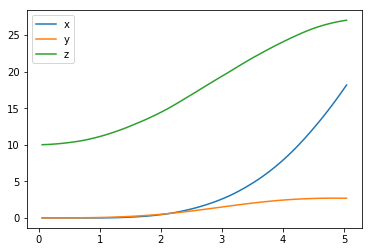

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

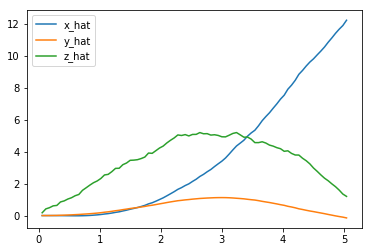

In [14]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

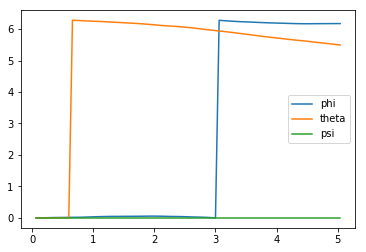

In [15]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

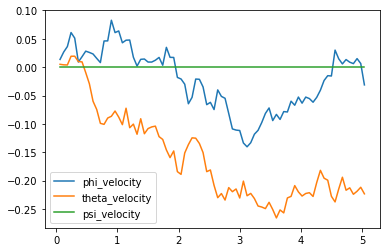

In [16]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

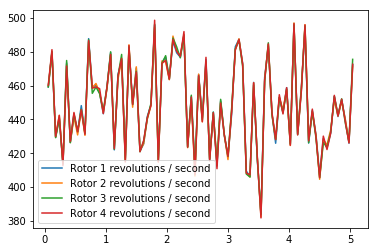

In [17]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [18]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 18.16365239   2.68100933  27.02072215   6.17445252   5.49573961   0.        ]
[ 12.20425226  -0.14733871   1.19795633]
[-0.03118398 -0.22326791  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [19]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 200

target_pos = np.array([50., 50., 50.])
init_pos = np.array([0., 0., 0., 0., 0., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

None None None 5.0 [ 50.  50.  50.]
<method-wrapper '__str__' of PhysicsSim object at 0x000001B4D7295BA8>
x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001410524982113
x: -0.0033620172639863663, y: -3.8547089924953586e-07 z: 10.002004964571226
x: -0.009526758028974024, y: -1.4433290674379444e-05 z: 9.995085214753272
x: -0.012431887554646118, y: -3.7316967365032384e-05 z: 9.98149983504817
x: -0.010103192045358459, y: -4.196377488826049e-05 z: 9.965677803175288
x: -0.0029732709723839738, y: -3.5232631358718497e-06 z: 9.948614361981937
x: 0.00895620571165553, y: 0.00013198668805895254 z: 9.931839399831865
x: 0.025488627341093653, y: 0.0004354193125064111 z: 9.916782285712554
x: 0.045643040466754436, y: 0.0009712481230297529 z: 9.904115586743721
x: 0.06835651009505096, y: 0.0018045679623408099 z: 9.894430940316767
x: 0.09252172760874844, y: 0.0030051426344838393 z: 9.888132929975164
x: 0.11699368177072961, y: 0.004635891735975502 z: 9.885354133242858
x: 0.1401345089215985, y: 0.0068976394355

Episode =    2, score =  -2.000 (best =  -2.000), noise_scale = 0.1x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001411882309952
x: -0.003353201350717064, y: -4.802274723286904e-07 z: 10.001901684725759
x: -0.009290313414147076, y: -1.3258775612639877e-05 z: 9.994810761297959
x: -0.011836437655922374, y: -3.2125712298236705e-05 z: 9.981339188523187
x: -0.009349451822263247, y: -2.99349449016739e-05 z: 9.966093644194466
x: -0.002342067003163828, y: 1.8306753259890783e-05 z: 9.950010863713851
x: 0.009073830811589264, y: 0.00016662726553353134 z: 9.934616578460314
x: 0.02460235018232145, y: 0.0004858439762548698 z: 9.921325035286038
x: 0.043218656053011055, y: 0.0010389080737427637 z: 9.910718304567375
x: 0.06382462582807502, y: 0.0018871549633741305 z: 9.903296564614939
x: 0.08529171601893426, y: 0.0030962041968668787 z: 9.899373736687147
x: 0.10647360764139263, y: 0.004724434824182873 z: 9.898990866567845
x: 0.12555555876930777, y: 0.006959087791424459 z: 9.904414611221853
x: 0.1468114053

Episode =    4, score =  -1.788 (best =  -1.788), noise_scale = 0.1x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001412004447397
x: -0.0033734254032939917, y: 7.498830648248959e-08 z: 10.002330636499092
x: -0.010197248937345124, y: -1.217843487313557e-05 z: 9.99600901975705
x: -0.014300969843172012, y: -3.81180469656331e-05 z: 9.982208780081287
x: -0.012829650952064798, y: -6.093306065869853e-05 z: 9.964681041830064
x: -0.0059328549250298925, y: -6.333975648282775e-05 z: 9.944530303879347
x: 0.006728803291797354, y: -5.235957343751419e-06 z: 9.923223593557356
x: 0.02528954518021912, y: 0.00016864997024182036 z: 9.902158179101917
x: 0.049002309767772444, y: 0.0005148467307485964 z: 9.882226851470298
x: 0.07701912785245166, y: 0.001096632393649072 z: 9.864263339796832
x: 0.1084032197544959, y: 0.0019839269283455146 z: 9.848938113218288
x: 0.1421160303428663, y: 0.0032439330051907377 z: 9.836683155279779
x: 0.17706073905347297, y: 0.004933676398135245 z: 9.827827574769113
x: 0.2120983356708

Episode =    6, score =  -1.848 (best =  -1.727), noise_scale = 0.1x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001413896437288
x: -0.0033757836199440946, y: 1.1081469131634402e-08 z: 10.002287090121733
x: -0.010106471849685252, y: -1.3767759183024345e-05 z: 9.995868108704856
x: -0.014012671676225164, y: -4.183427703239788e-05 z: 9.982086936226995
x: -0.012353187190491307, y: -6.416792813170997e-05 z: 9.96480773510208
x: -0.0053188498343201, y: -6.105162868711025e-05 z: 9.945113806104747
x: 0.007393225989752483, y: 1.2457471874570383e-05 z: 9.92447664559874
x: 0.02588763631474159, y: 0.00021734537494394997 z: 9.904294011723326
x: 0.04939673762291204, y: 0.0006144815208622203 z: 9.885425254019777
x: 0.07705748211015477, y: 0.0012711588703809417 z: 9.868672323339402
x: 0.10792165248728168, y: 0.0022613804123836107 z: 9.854676338580362
x: 0.14094318838638853, y: 0.0036558843511913276 z: 9.843840005197714
x: 0.17502126748016733, y: 0.005514164369887727 z: 9.836465895838897
x: 0.209016702540

x: 3.5743207472136347, y: 0.23926914379813133 z: 5.515289927200815
x: 3.598832611085856, y: 0.24482587024938593 z: 5.3322509534261515
x: 3.6328011981888504, y: 0.2504219503238143 z: 5.1401346958466085
x: 3.6761463400443404, y: 0.25598238102071347 z: 4.948815144506853
x: 3.7195072247379803, y: 0.26138086960892387 z: 4.753514554114761
x: 3.7649960845177515, y: 0.2664958552845349 z: 4.547753284924568
x: 3.8155005153989876, y: 0.27154040171812605 z: 4.336743025063522
x: 3.8671784574252985, y: 0.27673991529612585 z: 4.123221819921016
x: 3.919807611157371, y: 0.2819961268656524 z: 3.9064064677850623
x: 3.971451713189082, y: 0.28701714210141965 z: 3.684368878777869
x: 4.022160516701818, y: 0.29168838101005695 z: 3.456597029496624
x: 4.074436655058721, y: 0.29616262619447453 z: 3.2242701624573513
x: 4.128816254825431, y: 0.30075685262091445 z: 2.988773466760606
x: 4.183492917319421, y: 0.3054653329587347 z: 2.750158962297878
x: 4.237822235535954, y: 0.30989254094842256 z: 2.5070084369292034
x:

x: -0.30797164718258435, y: 0.2503624831993701 z: 5.081043913427867
x: -0.35551141134406716, y: 0.2500957948674258 z: 4.868817845722479
x: -0.40628580261284525, y: 0.25251250979843604 z: 4.651730147793252
x: -0.456142821333322, y: 0.259212944220623 z: 4.429828460838675
x: -0.5023570707891871, y: 0.26718072645690527 z: 4.202942445200489
x: -0.5452521317205921, y: 0.2730250982861942 z: 3.9705973670837227
x: -0.5872521335778522, y: 0.2749529876484344 z: 3.732245500308339
x: -0.6309092073053222, y: 0.2731075699419204 z: 3.4876998983885317
x: -0.6781048862022799, y: 0.26898526293108477 z: 3.237250090190983
x: -0.7290454367383105, y: 0.26468801909338413 z: 2.981519996897017
x: -0.7820383322496139, y: 0.26242576003512075 z: 2.7213630747354465
x: -0.8349504060343483, y: 0.262989030181575 z: 2.4571942261280304
x: -0.8863981315757122, y: 0.26539185568373336 z: 2.1886379572646635
x: -0.9363364669189371, y: 0.26785569777600043 z: 1.914751054110853
x: -0.985835137801659, y: 0.2695763671296376 z: 1.

Episode =   12, score =  -2.360 (best =  -1.500), noise_scale = 1.6x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001779557164047
x: -0.0035764460451227996, y: -9.504387568030953e-07 z: 10.002277987603469
x: -0.008609474069049435, y: -1.0748427207412779e-05 z: 9.994671082651724
x: -0.009392412181268373, y: -1.607481299428679e-05 z: 9.982487812959048
x: -0.006221800819988338, y: 1.3342825024227223e-05 z: 9.971480563875474
x: 0.00025702563959188935, y: 0.00010095409366997967 z: 9.962091589799059
x: 0.00981831009143284, y: 0.00029949363576729126 z: 9.955979629617463
x: 0.02189169124280143, y: 0.0007186512520326069 z: 9.954793426341208
x: 0.035128831440405704, y: 0.0014866783417565262 z: 9.958808408368126
x: 0.04818561391960713, y: 0.0027313860787489272 z: 9.96862724170666
x: 0.05612356005215141, y: 0.004431623319333984 z: 9.981764608030398
x: 0.05501982360117985, y: 0.006004970459048444 z: 9.990366211341351
x: 0.0492130582273684, y: 0.0068061150969487795 z: 9.988876551104655
x: 0.04439069300

x: 1.038647832019624, y: 0.31953603522917406 z: 8.788338393754174
x: 1.1038261550964779, y: 0.34277615666081224 z: 8.713095259813569
x: 1.1640381519677432, y: 0.3695648352873247 z: 8.636102497129977
x: 1.2176451050139538, y: 0.3952310010761968 z: 8.554871224710029
x: 1.2672583169592089, y: 0.4165202898304377 z: 8.468010759989337
x: 1.316636904240702, y: 0.4325714545655303 z: 8.375409123672819
x: 1.368650019491549, y: 0.4439765877632836 z: 8.277511883278416
x: 1.4253083689922992, y: 0.4526375970667748 z: 8.175090404623962
x: 1.4873284008399283, y: 0.46124982685073357 z: 8.068938774892617
x: 1.553972594110269, y: 0.4725764429857624 z: 7.959630503948391
x: 1.6231968056011712, y: 0.4886164338449594 z: 7.847383935842449
x: 1.6921566060247337, y: 0.5100289760623723 z: 7.732090992673314
x: 1.7581063561567178, y: 0.5359399507404282 z: 7.613483943332314
x: 1.819366872040407, y: 0.564251064840628 z: 7.49134747327218
x: 1.87583888779799, y: 0.5917320783983228 z: 7.365675650288033
x: 1.92929021161

Episode =   15, score =  -2.385 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001986254238734
x: -0.003839399728579173, y: 2.987767801600088e-07 z: 10.004916979394084
x: -0.01326144477262826, y: 4.013527669837973e-07 z: 10.001301642874083
x: -0.020601588412416393, y: 1.8109962966120861e-06 z: 9.986973215377622
x: -0.019701631694087247, y: 2.935109732283818e-07 z: 9.9678497052408
x: -0.014597731657151496, y: -2.173101875257223e-05 z: 9.952181848119984
x: -0.020109823374806084, y: -8.260090421352135e-05 z: 9.943300066173583
x: -0.024837185452087802, y: -0.00011000778999435691 z: 9.940133668995013
x: -0.030221899315869744, y: -0.00010001393727575148 z: 9.936313047163274
x: -0.0422246806809425, y: -9.402889523831264e-05 z: 9.928289918725214
x: -0.05386727467934445, y: -0.0001267161094657049 z: 9.914766929203438
x: -0.06832040063758577, y: -0.0001348130256735431 z: 9.900176333922516
x: -0.07820085539785761, y: -5.929316479502557e-05 z: 9.88738282131941
x: -0

x: 2.639320581211268, y: 0.24523466641307923 z: 6.5167372259980585
x: 2.6929360556134156, y: 0.2621240225174847 z: 6.362159210289394
x: 2.755116913380985, y: 0.2776709760845318 z: 6.207417457799844
x: 2.8184002554971954, y: 0.28995435265931674 z: 6.057680138852677
x: 2.8714887649399494, y: 0.29955878179171724 z: 5.910753228290876
x: 2.924060449284243, y: 0.306781652144458 z: 5.7662186429614515
x: 2.98498124795614, y: 0.3147963752981511 z: 5.613683401619887
x: 3.0518359887222952, y: 0.32427790060260914 z: 5.452854139186743
x: 3.1233295234834983, y: 0.3331620379053016 z: 5.285789077017549
x: 3.20050986601306, y: 0.3424137179437765 z: 5.110199146047201
x: 3.2842152635145014, y: 0.35227640728913306 z: 4.93340049692661
x: 3.3671978191435246, y: 0.36191479220706424 z: 4.752525051074086
x: 3.44847108285749, y: 0.3711303579696789 z: 4.566975266552579
x: 3.5288027909904995, y: 0.3807558871507501 z: 4.37881369376759
x: 3.609677346730984, y: 0.3903791851801072 z: 4.187176971832884
x: 3.6909803309

x: 0.8672786061215353, y: 0.0628553433506154 z: 9.23204013199389
x: 0.9373524210989332, y: 0.07288203260166676 z: 9.18189602672715
x: 1.0134628905398786, y: 0.08557391924945398 z: 9.133135977893929
x: 1.0921945767325743, y: 0.10151438533051464 z: 9.086499831002966
x: 1.169828153958387, y: 0.12043126376671454 z: 9.041076127949454
x: 1.243539959123676, y: 0.14169798905784675 z: 8.995534148351451
x: 1.3116901131053016, y: 0.16405270087135093 z: 8.947776786610508
x: 1.3743823241265414, y: 0.18532796868034154 z: 8.894777299617438
x: 1.4340442540345573, y: 0.20335739269718595 z: 8.833865170403483
x: 1.4942327133218278, y: 0.21763364619943637 z: 8.764688614119928
x: 1.5577866879235767, y: 0.22896525587536595 z: 8.688442304721915
x: 1.626359282403127, y: 0.2388084239174297 z: 8.606843907331784
x: 1.7003635116143272, y: 0.24911138667995844 z: 8.52185090455772
x: 1.7788217621122298, y: 0.26187987435274107 z: 8.435196016319846
x: 1.859584435192205, y: 0.27857668915904626 z: 8.347915462662403
x: 1

Episode =   20, score =  -2.286 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002074437055704
x: -0.002762928687397079, y: -8.383872871784617e-06 z: 10.001319238767003
x: -0.004260710096876991, y: -2.3416880023343833e-05 z: 9.99393864447589
x: -0.00435359487116636, y: -2.174663189763634e-06 z: 9.985517353052478
x: -0.008831362390279405, y: -2.244421348227931e-05 z: 9.972534935853924
x: -0.011610385201431426, y: -0.00016755927142063885 z: 9.950970475654572
x: -0.009294690283443915, y: -0.00020231653265377945 z: 9.927306438582706
x: -0.0049386315629209145, y: 0.00014349052090057124 z: 9.9064904220566
x: -0.0009980131687433807, y: 0.0009745404774666787 z: 9.88881607161791
x: -0.001644608328591017, y: 0.0026058082623678248 z: 9.876675064213318
x: -0.005793861304349011, y: 0.00403786592843972 z: 9.85953890850871
x: -0.003739356994608775, y: 0.005185642120288219 z: 9.835251445839775
x: 0.0018545301607348816, y: 0.007187206808462559 z: 9.813890831909132
x: 0.0

x: 2.513621704310985, y: 0.5303323724833913 z: 4.181800618115932
x: 2.5730947913523776, y: 0.5439836206727623 z: 3.985423576602456
x: 2.63122634898026, y: 0.5571127511799617 z: 3.784154739300767
x: 2.6885639610436147, y: 0.5696749441725333 z: 3.5776808735549794
x: 2.745839897055272, y: 0.5818742176933853 z: 3.36647110471881
x: 2.803316862957775, y: 0.5940021459374235 z: 3.1514650147337617
x: 2.8607058298764363, y: 0.6062086676098137 z: 2.933263641078811
x: 2.917766022688523, y: 0.6184991466080192 z: 2.711937639462431
x: 2.9748760892788764, y: 0.6308398863453536 z: 2.487337458060654
x: 3.032726596891068, y: 0.6432357357650925 z: 2.259635661644892
x: 3.0913994423193976, y: 0.6557075381204693 z: 2.0293217419182126
x: 3.1501883551486034, y: 0.6682395012464034 z: 1.7963151507035633
x: 3.2084432898719175, y: 0.680766728770398 z: 1.5595788630246283
x: 3.2663193519428204, y: 0.6932164001883893 z: 1.3179149023741232
x: 3.324455570906451, y: 0.7054767732255343 z: 1.070868939278252
x: 3.383073428

x: 6.035734558600363, y: -0.23748870043132153 z: 0.8761234259087478
x: 6.110100041408948, y: -0.24965625451043066 z: 0.6032315581519485
x: 6.180118485585439, y: -0.25913725215898464 z: 0.3181778509949809
x: 6.254636754212786, y: -0.2680013495172728 z: 0.028220831049569
Episode =   24, score =  -1.667 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001434489123787
x: -0.003005411357621516, y: -3.2935037346702375e-09 z: 10.000759562216661
x: -0.00621049882553238, y: 6.025437399044892e-08 z: 9.992665343577832
x: -0.005516483247600616, y: -5.084475047264082e-07 z: 9.984781502878558
x: 0.0010713058643445706, y: -1.7745776503547253e-05 z: 9.97517927873756
x: 0.009063691735205402, y: 1.7356850036893265e-06 z: 9.962925434024235
x: 0.008804734837172203, y: 7.105529021209229e-05 z: 9.951706657646406
x: -3.4765576001649125e-05, y: 6.207624330329957e-05 z: 9.933295973809768
x: -0.013963798609376243, y: -0.00016520120665943416 z: 9.903205252775056
x: -0.02845822345828

Episode =   26, score =  -1.897 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001042293956916
x: -0.0023905215096590563, y: 7.378151945824932e-06 z: 10.002984359202454
x: -0.010053701667145339, y: 1.3751630451229838e-05 z: 10.001975853398411
x: -0.021495208435635776, y: -3.0733078975143596e-05 z: 9.993777414713506
x: -0.03397936850256715, y: -0.00018834564371756498 z: 9.976662393290665
x: -0.046002996366122664, y: -0.0005147294723665634 z: 9.950551045888393
x: -0.05596777945390285, y: -0.0010706205357068532 z: 9.915533417797445
x: -0.06257117543824232, y: -0.001896688240826846 z: 9.871963759861721
x: -0.06497095451555794, y: -0.0029948126610419143 z: 9.820598672349618
x: -0.062434440454426685, y: -0.0043407416664693116 z: 9.762318077792
x: -0.0544420919421909, y: -0.0058874830692104835 z: 9.69802327234277
x: -0.04072170490885527, y: -0.007562997666597105 z: 9.628621838507163
x: -0.021157155280456, y: -0.009265648608149615 z: 9.555061533728198
x: 0.00421

Episode =   28, score =  -2.429 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001542902866792
x: -0.0021020055473508006, y: 2.3823605001260975e-05 z: 10.005470981770541
x: -0.009684813173208552, y: 8.482020732701045e-05 z: 10.009207967955502
x: -0.023696343692292378, y: 0.00013679303125840777 z: 10.008679884513441
x: -0.043434883643255276, y: 0.00013901145069004968 z: 10.001029616941356
x: -0.06801052447992001, y: 9.1814426479351e-05 z: 9.985042194138266
x: -0.09639556747237275, y: 1.747599983638347e-05 z: 9.959513769369574
x: -0.12763113284512315, y: -2.3701162848709495e-05 z: 9.92361449600681
x: -0.1607928926140961, y: 5.97507840515495e-05 z: 9.87704461190667
x: -0.19522691109829238, y: 0.0005456928228607797 z: 9.815059785287954
x: -0.23813913237465498, y: 0.0012735400337293798 z: 9.742955263806637
x: -0.2882448320827416, y: 0.0015768404019534774 z: 9.676756155685359
x: -0.341785050032382, y: 0.0017464021545175585 z: 9.610410829349318
x: -0.4044608338

x: -1.9247391473095574, y: -0.09662634025634187 z: 0.0
Episode =   30, score =  -2.565 (best =  -1.500), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001265392289998
x: -0.00172138278308462, y: -7.216170129333101e-06 z: 9.999104502527677
x: -0.0022432652255160637, y: -1.2415314694317895e-05 z: 9.991659823255414
x: -0.0024079642598268097, y: -7.661673505943731e-07 z: 9.982280835012025
x: -0.005838218699003365, y: -3.818818619954032e-05 z: 9.967058459489019
x: -0.007594449223561466, y: -0.00017173901449677988 z: 9.944228756712747
x: -0.0049995702516371174, y: -0.00024963746591322736 z: 9.918283063593288
x: 0.00030776447310507636, y: -7.263473342510431e-05 z: 9.893033500594184
x: 0.005776109226235774, y: 0.0004579262375383993 z: 9.869231240530521
x: 0.007034775171967603, y: 0.001580215543256796 z: 9.848943157985097
x: 0.008338987844434168, y: 0.0026380667186491503 z: 9.824762775404738
x: 0.013231995503186997, y: 0.003907595778231262 z: 9.797885486402441
x: 0.01366284242592

x: -0.9141192119231245, y: -0.19748165832289585 z: 5.696346069086067
x: -0.9581417485532785, y: -0.20551053825224636 z: 5.512705810408786
x: -1.0057443747818757, y: -0.21445429102792296 z: 5.32808293005166
x: -1.058885728725565, y: -0.22297287343908653 z: 5.136506452818254
x: -1.112103716494308, y: -0.2308744100228927 z: 4.935386396205941
x: -1.1603745656656772, y: -0.23848056770460346 z: 4.726527494509816
x: -1.2018554794962084, y: -0.24615565455894217 z: 4.5139926584777825
x: -1.2385032059028036, y: -0.25431077872200103 z: 4.301081991576156
x: -1.274318017142307, y: -0.2627161464300502 z: 4.089101668868007
x: -1.314093807572589, y: -0.2707694337589512 z: 3.877275611786588
x: -1.3575079840055921, y: -0.27877032249357864 z: 3.6625797771472284
x: -1.4010957388462715, y: -0.28687981173829924 z: 3.4439994671742924
x: -1.4437144106651392, y: -0.29483939373900586 z: 3.222203100198624
x: -1.486661348260916, y: -0.3030858302169443 z: 2.996227553084076
x: -1.5294218051176915, y: -0.31154576381

x: -1.92131274976721, y: -0.509313224918556 z: 6.128296987757558
x: -1.9923347461344727, y: -0.5108036552043516 z: 5.901718356528609
x: -2.0614594303791662, y: -0.5075117055241463 z: 5.666210775882801
x: -2.1245336241831794, y: -0.5009111620591133 z: 5.4232424920602895
x: -2.1797331679561376, y: -0.49462072665789253 z: 5.175362191386847
x: -2.2287896241292153, y: -0.4919107360101573 z: 4.92425041302433
x: -2.2778469874729628, y: -0.4943142498699369 z: 4.670533787289282
x: -2.3326935611531394, y: -0.49923279754242866 z: 4.4128813049185025
x: -2.392577114188438, y: -0.5025428890646428 z: 4.149064229295861
x: -2.4540126655253682, y: -0.502603706105613 z: 3.878072539559485
x: -2.513970557030283, y: -0.4992087472674866 z: 3.599699744463714
x: -2.5699779087787618, y: -0.49354412356983973 z: 3.314583113271295
x: -2.6211956266577707, y: -0.48828981912362296 z: 3.0242193085501436
x: -2.6687632597812767, y: -0.48594559409355254 z: 2.729961224259962
x: -2.714866783827078, y: -0.48744271816378093 

x: 0.30019339763179975, y: 0.5467159322728686 z: 8.064554429938013
x: 0.31348942521127615, y: 0.5561215737000993 z: 7.959364026560702
x: 0.31766409188296985, y: 0.5628912029752005 z: 7.854748332543625
x: 0.31629599745542486, y: 0.5739113734171755 z: 7.739860287563993
x: 0.3241890655191312, y: 0.5891643494156003 z: 7.614802126391688
x: 0.34194383431533243, y: 0.6024575599323861 z: 7.487923971431605
x: 0.36115338323405344, y: 0.6107651446768151 z: 7.362576148551175
x: 0.38045358310234145, y: 0.6190736733895551 z: 7.233279247356204
x: 0.40389159067467795, y: 0.6289719269452202 z: 7.098125428877159
x: 0.4273916774958624, y: 0.6388369278649808 z: 6.958832631293238
x: 0.4499578206536668, y: 0.6515150354522163 z: 6.8126707190395654
x: 0.47789540103325767, y: 0.6649172854184409 z: 6.66157223625073
x: 0.510793094978268, y: 0.6749375620394571 z: 6.509059167451042
x: 0.5447504823335922, y: 0.6798433567596648 z: 6.356169926388153
x: 0.5733661363956176, y: 0.6784895963692779 z: 6.203212571991333
x:

x: 0.8671322590417355, y: 0.24486482060090506 z: 5.4306542967672184
x: 0.854594902896813, y: 0.25591365371200503 z: 5.215207346635725
x: 0.8386553162121413, y: 0.2667231869705998 z: 4.992564185303701
x: 0.8227179015430945, y: 0.2770694678083159 z: 4.764121829463532
x: 0.809682383769202, y: 0.2869507175772225 z: 4.530717576899348
x: 0.796453755017856, y: 0.296392704687309 z: 4.292652291654301
x: 0.7830754972356032, y: 0.3054579457699567 z: 4.049930831940614
x: 0.769886296040129, y: 0.3145046005899547 z: 3.8037300618012266
x: 0.7566666679847398, y: 0.3235626379199323 z: 3.5539193423385433
x: 0.7434723731260673, y: 0.3326039383377985 z: 3.300578246782217
x: 0.7307213627440485, y: 0.3417562037319003 z: 3.04461182610674
x: 0.7176300028373885, y: 0.3509552809889407 z: 2.785737777461074
x: 0.7039165303615174, y: 0.3601853070111235 z: 2.5220436485988094
x: 0.6889543508539379, y: 0.3693692771623874 z: 2.254123249034895
x: 0.672061070645631, y: 0.3783829995000916 z: 1.9819216256956325
x: 0.65531

x: -2.0129899300779166, y: 0.408226195405071 z: 5.816463496203038
x: -2.0851414111995576, y: 0.40937886856847444 z: 5.650695184854579
x: -2.1536325619102494, y: 0.4085790673266816 z: 5.4810223609810445
x: -2.2232452972917818, y: 0.4059363645225965 z: 5.307380125435513
x: -2.2951752462581, y: 0.4059275073445487 z: 5.128856013401295
x: -2.365212157954033, y: 0.40931625925328186 z: 4.945432516727184
x: -2.431929791483746, y: 0.41224865788560494 z: 4.757169466468866
x: -2.497346444723289, y: 0.4118951488075501 z: 4.563597070038398
x: -2.5658313538821704, y: 0.407232030842988 z: 4.363991001438729
x: -2.6409603290950447, y: 0.3993808914275004 z: 4.158440528494103
x: -2.7238351436140853, y: 0.39169853432756785 z: 3.94828283381367
x: -2.811856330775369, y: 0.3861599200951244 z: 3.7345481977905615
x: -2.900595612889187, y: 0.38275550417163035 z: 3.5174468993533816
x: -2.98743118353538, y: 0.38038660505953675 z: 3.296384513975599
x: -3.07218374636992, y: 0.3775221564935121 z: 3.070076830122507
x

x: 1.3481261582616515, y: 0.5714015694026049 z: 2.1166068340424644
x: 1.3968877317848316, y: 0.5866342734291895 z: 1.842786556744491
x: 1.446032431095263, y: 0.6012662231431837 z: 1.5653427068488928
x: 1.495570848211458, y: 0.6157823036469873 z: 1.2852021559605427
x: 1.5450826213708266, y: 0.6297517841783715 z: 1.0021682096819862
x: 1.5946503588864491, y: 0.6432304715457241 z: 0.7164134036736882
x: 1.6436071257960603, y: 0.6561630018333457 z: 0.42807496558690544
x: 1.6917819309402349, y: 0.6676053324179757 z: 0.13676375123287818
x: 1.7400787516808178, y: 0.6771818033714372 z: 0.0
Episode =   42, score =  -1.400 (best =  -1.400), noise_scale = 1.6x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002881495677869
x: -0.0028303913543067417, y: -0.00017078227141563537 z: 10.002756686546741
x: -0.0038897799440659898, y: -0.0003905401025079012 z: 9.996283873216028
x: -0.004200412579880061, y: -0.0002984425925671705 z: 9.989076385185433
x: -0.010669475665692676, y: -0.0003486669905584032 z: 9.976126

x: -1.3156210541930724, y: -0.5014175714920405 z: 4.398298275354096
x: -1.3396050918102693, y: -0.5257531184839549 z: 4.181361677998971
x: -1.3630152545317722, y: -0.5514021434285373 z: 3.959541744760338
x: -1.3846653630154246, y: -0.5774066682304445 z: 3.7339544654938748
x: -1.4065132152454183, y: -0.6030584689011056 z: 3.505419862343921
x: -1.4299690532453848, y: -0.6289570999281631 z: 3.2733274274128585
x: -1.454706125634075, y: -0.6556662981846263 z: 3.0371237321159192
x: -1.4795828395922122, y: -0.6830210210932843 z: 2.7970337709265927
x: -1.5044723727632756, y: -0.7108367403095828 z: 2.5532956980364054
x: -1.5292760653132185, y: -0.7391720538527055 z: 2.3059025180299937
x: -1.5535284572634138, y: -0.7682143375244539 z: 2.054729073292317
x: -1.5764459295346465, y: -0.7979537426205413 z: 1.799840022775686
x: -1.5975387423022613, y: -0.8280325956521871 z: 1.5416102119133193
x: -1.617004204403202, y: -0.8579724160994591 z: 1.2805013793403957
x: -1.6355398227688214, y: -0.887610572347

Episode =   45, score =  -1.294 (best =  -1.294), noise_scale = 1.6x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002353368671946
x: -0.00036857407585166424, y: -8.458719031990217e-05 z: 10.000800100783046
x: -0.00029368940987704005, y: -0.00010403965996283327 z: 9.995258506812075
x: -0.000941769397954534, y: -0.00012732969476446907 z: 9.986758377606765
x: -0.000373945126173455, y: -0.00038798832649294306 z: 9.968725518891189
x: 0.006166291102033779, y: -0.0006934428976813143 z: 9.946062695695565
x: 0.016187660652381954, y: -0.0009135235436902662 z: 9.92526114173285
x: 0.024399243462323462, y: -0.0010888993985232309 z: 9.908295279881335
x: 0.026926798768165283, y: -0.0012940132538415083 z: 9.893087773839259
x: 0.01612646749840332, y: -0.0015373425244521875 z: 9.876390313129694
x: 0.0013170895971031868, y: -0.004519231346693909 z: 9.848749189680028
x: -0.012219262765922775, y: -0.004615829698782289 z: 9.816360945377937
x: -0.0244779668210772, y: -0.0009967742056073872 z: 9.785474374232138


Episode =   47, score =  -2.167 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001600373099798
x: -0.0028533392057490587, y: 1.1675635048105967e-05 z: 10.004971649791218
x: -0.011959482590894625, y: 2.56174944304128e-05 z: 10.005488567462606
x: -0.0254984664855335, y: -5.20250689621563e-07 z: 9.997989013040064
x: -0.04031991276404844, y: -7.00468393124504e-05 z: 9.98034799597637
x: -0.054844298564179036, y: -0.00014449273228604823 z: 9.952449697828687
x: -0.06596301973955158, y: -0.00015151319531413082 z: 9.911059568005493
x: -0.07773265436779828, y: -0.0001538698661078837 z: 9.853277999645362
x: -0.09411778567801063, y: 7.437525463624683e-06 z: 9.792383204542299
x: -0.11573814036309002, y: 0.0002906675510855804 z: 9.732789086265235
x: -0.1443540820567343, y: 0.0002610624857470659 z: 9.66434360246573
x: -0.17700206209746827, y: -0.0002830221461427914 z: 9.584528066576611
x: -0.21035974167604807, y: -0.0013674942144373636 z: 9.493546822483578
x: -0.240380

Episode =   49, score =  -2.455 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002235178223371
x: 0.002512629954846399, y: -3.173803625103671e-05 z: 10.001382369369324
x: 0.003562034071475614, y: -7.360948693425586e-05 z: 9.994584287008335
x: 0.006087816516322835, y: -8.657930859162271e-05 z: 9.985566533439844
x: 0.008602943848461964, y: -9.246295949319427e-05 z: 9.972971565844988
x: 0.010512044135979308, y: -0.0001090581397466812 z: 9.953931738360787
x: 0.016327304311228027, y: -0.00015306609546466134 z: 9.933748631877332
x: 0.01822789498939896, y: -0.0002595279664079008 z: 9.919410580990835
x: 0.020554572565832464, y: -0.000484865989231621 z: 9.909811220519293
x: 0.0244505362454901, y: -0.0005969905397711378 z: 9.893121105010888
x: 0.03231976024289114, y: -0.0004427193885758379 z: 9.87002299138379
x: 0.04238484623513278, y: -0.0005502498168239981 z: 9.84121501337392
x: 0.05472445211009168, y: -0.0010478957676239994 z: 9.8012270835175
x: 0.0702037666007

x: 0.3808087344679724, y: 0.20537187155005904 z: 5.815461505929024
x: 0.35927690786840316, y: 0.18792313250042655 z: 5.652187569427152
x: 0.3486937214927891, y: 0.17335826088152378 z: 5.483027032003162
x: 0.3453906421196551, y: 0.15248133252619897 z: 5.311656048705483
x: 0.3436368516730945, y: 0.13129549802551704 z: 5.135855599526523
x: 0.3393021723940481, y: 0.11246676191774323 z: 4.954602366272224
x: 0.33278475262808127, y: 0.09664308334316753 z: 4.767739537785691
x: 0.3318314235462641, y: 0.08671402059312833 z: 4.574350908100657
x: 0.33933018197925013, y: 0.07745995759999336 z: 4.375983021977926
x: 0.35303115244877864, y: 0.06414080426034977 z: 4.173880262062464
x: 0.36519228910544993, y: 0.048073918531855345 z: 3.9676394503092007
x: 0.37355341667809094, y: 0.035110760759344856 z: 3.755662266190372
x: 0.3833952912984009, y: 0.026646316440869976 z: 3.537501305304581
x: 0.396839565325657, y: 0.017609020684419406 z: 3.314528562318784
x: 0.410969329193434, y: 0.004135812330831271 z: 3.0

Episode =   52, score =  -2.273 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001415978066953
x: -0.0033661040040151137, y: -8.654997707199391e-08 z: 10.002004305227983
x: -0.009505546917474754, y: -6.543953317167951e-07 z: 9.995061665112887
x: -0.010670010641353637, y: -2.190059631634521e-06 z: 9.981882533457078
x: -0.0117492863853664, y: -8.495086695428122e-06 z: 9.964458546750423
x: -0.012638076503171971, y: -1.7526266301159392e-05 z: 9.942082736781597
x: -0.011277832481491739, y: -1.910820136856817e-05 z: 9.917444879879204
x: -0.01476187662040838, y: -1.566182560363311e-05 z: 9.890539555110044
x: -0.023362844575900862, y: -5.297608993338582e-06 z: 9.859268380815404
x: -0.04126834806683893, y: 0.00010854355629366751 z: 9.817990650805193
x: -0.07081833060193161, y: -0.00011603855433074402 z: 9.760371282540476
x: -0.10530907860666687, y: 0.0003434645871620358 z: 9.700230150188874
x: -0.14394764041065689, y: 0.0021861881929783463 z: 9.646021675650786
x:

x: 4.321931424367298, y: 0.07437914729695771 z: 4.516212660634628
x: 4.446653076595671, y: 0.08015846914153128 z: 4.323016713791682
x: 4.567821040834931, y: 0.08632462282153083 z: 4.127347042704532
x: 4.685076376863241, y: 0.09195326059415997 z: 3.9268449760076614
x: 4.801228603474963, y: 0.0966870428982558 z: 3.7207031171144846
x: 4.919554101812195, y: 0.10137846834649338 z: 3.5109436010525275
x: 5.039799044816827, y: 0.10688406956829413 z: 3.299516998521753
x: 5.159841364046188, y: 0.11300189893646594 z: 3.085976339912581
x: 5.277985123607788, y: 0.11886870967049452 z: 2.8685813760444177
x: 5.3936638821312375, y: 0.12342116653954352 z: 2.6454794534165402
x: 5.508536590512317, y: 0.12642506534486908 z: 2.416318378036442
x: 5.624156970129763, y: 0.12847775919329907 z: 2.182155455953476
x: 5.741827688450412, y: 0.13009673984177236 z: 1.9439195019349103
x: 5.86240327219869, y: 0.1322722456089501 z: 1.7033614716346954
x: 5.984720695358097, y: 0.1357502057626701 z: 1.461770311292479
x: 6.1

x: 3.776740509521811, y: 1.1128714549742094 z: 1.582777549839153
x: 3.835552948624191, y: 1.142845139695392 z: 1.2824665707986542
x: 3.8913448113712743, y: 1.1714344383997677 z: 0.9762491773036734
x: 3.9449193400803932, y: 1.2035208215286946 z: 0.6641933183222004
x: 3.998083252924454, y: 1.235881723399417 z: 0.3459221165543246
x: 4.0491530910141895, y: 1.2679251135875211 z: 0.0214412181640815
x: 4.100167606819777, y: 1.3035402585189464 z: 0.0
x: 4.150848817338607, y: 1.3401046494918594 z: 0.0
Episode =   56, score =  -1.800 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001204545539283
x: -0.0020573259396301355, y: 4.1677832864881006e-05 z: 10.004058257101232
x: -0.009306895894220586, y: 0.00013868491680639898 z: 10.005836500332888
x: -0.022107068783375802, y: 0.00018433598185082784 z: 10.002534062579281
x: -0.03914212876103589, y: 9.350177011194684e-05 z: 9.991459696352956
x: -0.05905654084286206, y: -0.0001266167928920205 z: 9.971525900563377
x: -0.080

Episode =   58, score =  -2.524 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002193713815837
x: 0.0025484944855018216, y: -2.6956181467121942e-05 z: 10.001337362524303
x: 0.0036634660501851848, y: -6.447271358711784e-05 z: 9.99445868982944
x: 0.006142502760300105, y: -7.479288994097562e-05 z: 9.985478436092087
x: 0.009533320170844895, y: -4.5692137602218745e-05 z: 9.976260520928443
x: 0.008142026095856285, y: 3.921805568532738e-06 z: 9.96079458583395
x: 0.011565658515576522, y: 4.010596117021204e-05 z: 9.936822431452349
x: 0.015714324506990833, y: 9.224216173475393e-05 z: 9.90696229514904
x: 0.02055871094296992, y: 0.00015965708841874472 z: 9.871382343710296
x: 0.024726039497847088, y: 0.00020551417043158558 z: 9.83947516447242
x: 0.031467106606107076, y: 0.00035001972044341166 z: 9.813108771959591
x: 0.05254643969618565, y: 0.0011905745629241242 z: 9.792163056960796
x: 0.08035251374690919, y: 0.003260499732674587 z: 9.778302404444965
x: 0.104434774857

Episode =   60, score =  -2.182 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002029503953308
x: -0.003675292097471966, y: 5.254958924843271e-05 z: 10.005682269599273
x: -0.013851680569600285, y: -1.7702894480434926e-05 z: 10.004153766427905
x: -0.025501178332061718, y: -0.0005502698573360469 z: 9.992533073269772
x: -0.033689831448015774, y: -0.0015794960229742936 z: 9.970688655393934
x: -0.03702974132401883, y: -0.002950775774744055 z: 9.939606829715736
x: -0.03379484155243183, y: -0.00453294485151844 z: 9.900244589036355
x: -0.022637824714800903, y: -0.00622248987152165 z: 9.853589158880606
x: -0.0031441449480269796, y: -0.007942468862241705 z: 9.800893187061043
x: 0.027005698691600074, y: -0.00966228930213789 z: 9.743429145701194
x: 0.0653077077285107, y: -0.011592122587008938 z: 9.68805359187406
x: 0.10037959615512762, y: -0.013942316666271874 z: 9.638776528981696
x: 0.11882704685578623, y: -0.01614768095404207 z: 9.584647959993111
x: 0.114234002202

x: -1.3504119171019493, y: -0.46452273571061103 z: 1.3525557130108576
x: -1.372511200779574, y: -0.47220782223664026 z: 1.0907961760052334
x: -1.3957871675993454, y: -0.4794462102686144 z: 0.8262700295421235
x: -1.4200980991098477, y: -0.4863615197738599 z: 0.559023269470045
x: -1.445273913602459, y: -0.4930702850083304 z: 0.2891036242156612
x: -1.4712591354983513, y: -0.4996766877695604 z: 0.016556774059159472
x: -1.49784072969063, y: -0.5062441377647121 z: 0.0
x: -1.5247565106656333, y: -0.5128055922843123 z: 0.0
Episode =   62, score =  -2.565 (best =  -1.294), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001568957368312
x: -0.002351718028068088, y: 2.9247637202122795e-05 z: 10.005378289470276
x: -0.010568868224722082, y: 9.429297848914042e-05 z: 10.00823784805267
x: -0.024933798503638274, y: 0.00011727757345677893 z: 10.005514606873056
x: -0.043806897081100804, y: 4.6800246700976175e-05 z: 9.994147516242014
x: -0.06549000696313068, y: -9.292552986456915e-05 z: 9.972

x: -0.14104036153323044, y: -0.39863388150721735 z: 3.7966425819162986
x: -0.15798392071204764, y: -0.4182989139164061 z: 3.605726998814133
x: -0.17413632308667712, y: -0.4389418072276498 z: 3.410019797723706
x: -0.1895310643557962, y: -0.45966908481030566 z: 3.210678296488644
x: -0.20488616234880233, y: -0.4803501561681634 z: 3.007861049923393
x: -0.22241899151017788, y: -0.5008194910178071 z: 2.8018205652224375
x: -0.2443385882484947, y: -0.5211992561408643 z: 2.5923627929299755
x: -0.27057128679716647, y: -0.5422697605173064 z: 2.3782742022210055
x: -0.2987554329642049, y: -0.5640838760553247 z: 2.159435813769476
x: -0.32670856321245223, y: -0.58593513888902 z: 1.9370008869191795
x: -0.35453589641349803, y: -0.6074905957985031 z: 1.7115406492605962
x: -0.382038837653447, y: -0.628908883782693 z: 1.482758491963507
x: -0.40867636847091643, y: -0.6501551081028617 z: 1.2507487384137057
x: -0.43483044287678774, y: -0.6711295456241247 z: 1.0157420262410912
x: -0.46123491500916197, y: -0.6

x: -0.4402870034429073, y: 0.04324965283993005 z: 7.422530681380481
x: -0.43764655492319293, y: 0.04267727689799999 z: 7.307415663588041
x: -0.4398239946815622, y: 0.041811973650366464 z: 7.192759727577502
x: -0.44391143529434135, y: 0.040686523001803906 z: 7.078141909085627
x: -0.4474065129193455, y: 0.03973798291111077 z: 6.956966594348115
x: -0.4458182687425481, y: 0.0385189312477065 z: 6.834812582449859
x: -0.44662934882241073, y: 0.036629372489402894 z: 6.71587601685876
x: -0.45562709966550535, y: 0.034538934171692834 z: 6.594513972101033
x: -0.4703056150998089, y: 0.032814090045484745 z: 6.462391199008562
x: -0.4832198524454599, y: 0.03133598109141946 z: 6.318262125472558
x: -0.4890846598183154, y: 0.029885216347756174 z: 6.168207502382452
x: -0.4891136855540247, y: 0.028421932123677014 z: 6.019373279637201
x: -0.4889274623772979, y: 0.026964381210194024 z: 5.8731477311741696
x: -0.49338818752729086, y: 0.02550901008800268 z: 5.724827734031079
x: -0.5022732370604899, y: 0.0240079

x: -0.33212029910832225, y: 0.0228035895958224 z: 9.510132699277156
x: -0.3647610291353525, y: 0.02363009868598688 z: 9.446285023670807
x: -0.3978999331206862, y: 0.02338775973915911 z: 9.37143210703497
x: -0.4286474420226285, y: 0.02231497922786444 z: 9.285897266154757
x: -0.4545232787606549, y: 0.020726896179685744 z: 9.191069634213136
x: -0.47372714902121743, y: 0.018932402302362473 z: 9.08952588492474
x: -0.4856776577412033, y: 0.01713242041866044 z: 8.984485817867077
x: -0.4894569702674606, y: 0.015345115715476181 z: 8.880140479219113
x: -0.4871986952846184, y: 0.013866240571871016 z: 8.781030642392066
x: -0.48542990734888236, y: 0.013293422800142184 z: 8.688965241454852
x: -0.49049876043923774, y: 0.013898083772880996 z: 8.60243943046328
x: -0.5069089619339634, y: 0.015173737817438013 z: 8.51689878097025
x: -0.5357044064761372, y: 0.01644208352921684 z: 8.425954833123102
x: -0.5733803674134512, y: 0.017690193786776352 z: 8.325408524790861
x: -0.6152724210684656, y: 0.019320699066

x: -2.282263919349061, y: -0.08372848886418216 z: 1.2900078136586541
x: -2.3251493258760307, y: -0.09023465715236778 z: 1.0358449272148307
x: -2.3685845845376603, y: -0.09775077486909019 z: 0.7778908604095204
x: -2.412257321390005, y: -0.1062780944906892 z: 0.5158723710786416
x: -2.4557629959207214, y: -0.11568140518295887 z: 0.24964442117564062
x: -2.498692171198078, y: -0.12574290492315737 z: 0.0
Episode =   69, score =  -2.143 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002333370079795
x: -0.0039868388936023695, y: 1.8974783404773115e-05 z: 10.006636094964419
x: -0.01488195744191892, y: -8.086757387628407e-06 z: 10.005465071273408
x: -0.027139359276512263, y: -0.00018747499362199472 z: 9.993902984911983
x: -0.034779915215179424, y: -0.0004905621891762248 z: 9.97307139693315
x: -0.03570133013319259, y: -0.0008323158117487197 z: 9.946071134158153
x: -0.029104645779548147, y: -0.0011694869596557838 z: 9.916746438281812
x: -0.01633255364741763, y: -0.0

Episode =   71, score =  -2.630 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001922952564286
x: -0.0028482178156960113, y: -1.810600586830095e-05 z: 10.00116534532261
x: -0.004672205763579582, y: -5.770944241267204e-05 z: 9.993543662910938
x: -0.004466200808467923, y: -6.294454346413237e-05 z: 9.984496230541323
x: -0.008605468600907024, y: -4.539777655089789e-05 z: 9.972094270574097
x: -0.013064728354564748, y: -4.157526561407785e-05 z: 9.951000076941249
x: -0.010097028802765596, y: -6.047648268064727e-05 z: 9.92638216279707
x: 0.0014725416573902702, y: -0.00010506306062949217 z: 9.89580470995272
x: 0.017250397417047522, y: -7.775461588047501e-05 z: 9.86225218338348
x: 0.0343249154347132, y: 0.00011443361406774582 z: 9.833949856010765
x: 0.04926736529237777, y: 0.0005734166570945984 z: 9.806985020868838
x: 0.058371386012577464, y: 0.0011399020931068774 z: 9.77762497998788
x: 0.06189686206622848, y: 0.0011882863893618153 z: 9.74144321655623
x: 0.0619875

x: -3.4611670460896513, y: 1.4614447309494796 z: 5.120270625179533
x: -3.5840595464510465, y: 1.5095830013412068 z: 4.880622603721573
x: -3.7048860376058914, y: 1.556339452365135 z: 4.638165401450709
x: -3.8269737768878738, y: 1.6017144686865405 z: 4.3936956704594925
x: -3.953260370089818, y: 1.6465019994357815 z: 4.146174656665918
x: -4.082373064669359, y: 1.6913741567203273 z: 3.893836730053762
x: -4.2117983877144916, y: 1.7361881017873417 z: 3.6371214863317007
x: -4.340910206520972, y: 1.7807296554164502 z: 3.3760277530095726
x: -4.468580723213304, y: 1.8246191680477168 z: 3.10984537666813
x: -4.596799344649683, y: 1.8680640602261838 z: 2.8397891135436266
x: -4.725471004788768, y: 1.910127775515832 z: 2.566416494110622
x: -4.852799131626745, y: 1.9517279864053219 z: 2.290220340001987
x: -4.980606698970765, y: 1.9952579523280678 z: 2.0124476777940266
x: -5.109852363822138, y: 2.0404996340231167 z: 1.7328920482347219
x: -5.24052443372683, y: 2.086640664344599 z: 1.451320318583498
x: -

Episode =   75, score =  -2.455 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00197863700949
x: -0.00036180150373308636, y: -4.356505484436092e-06 z: 10.000050506118628
x: -0.00029507586859406994, y: -8.141129202904728e-06 z: 9.9941336067211
x: -0.0009799372825185322, y: -8.565579141917383e-06 z: 9.985015295634952
x: -0.0005127689743561993, y: -2.4555707188667067e-05 z: 9.966612786661521
x: 0.0056902391466562285, y: -3.835681550300718e-05 z: 9.943778836263876
x: 0.01490917524223175, y: 7.303332918813381e-06 z: 9.923112446267098
x: 0.019903453806878052, y: 9.216035277100562e-05 z: 9.90162208767685
x: 0.02189283371842967, y: 0.00019533713631298612 z: 9.870724786925782
x: 0.032284271086217765, y: 0.0003221485494510589 z: 9.831616273799353
x: 0.0427193215394188, y: 0.0004312869074804604 z: 9.789184611524739
x: 0.04697622493064499, y: 0.0002505864904041824 z: 9.750598070134531
x: 0.048131990594042454, y: -0.000497941570582125 z: 9.721501854323618
x: 0.049739

Episode =   77, score =  -1.769 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001840992928644
x: -0.003109931285906652, y: -1.4626796634577478e-05 z: 10.00137263448252
x: -0.005749712435999085, y: -5.8027455587799655e-05 z: 9.993511395312794
x: -0.005449910864036853, y: -7.283789612750629e-05 z: 9.983713315065318
x: -0.00892493861182558, y: -5.4901694498553266e-05 z: 9.972125779541859
x: -0.014421516472648459, y: -6.578789787098078e-05 z: 9.9523428082539
x: -0.015580697115854154, y: -9.313492651314208e-05 z: 9.926009669461504
x: -0.0113842189912299, y: -0.00011235193872704924 z: 9.898727846993182
x: -0.004769818891162044, y: -0.00012416599243693808 z: 9.873222289997013
x: -0.0009467934631993673, y: -0.0001395097195332791 z: 9.853036937350232
x: -0.005287086289826892, y: 0.0008043171778433577 z: 9.839285992678127
x: -0.012374171464985394, y: 0.00531204511174951 z: 9.831748720377362
x: -0.01670884844887279, y: 0.01113816744703941 z: 9.82423878084766
x: -0

x: -1.74012061667734, y: -0.1331842360599316 z: 3.60495554545327
x: -1.7621122427382385, y: -0.1364446855764185 z: 3.383284929772305
x: -1.7826972659677491, y: -0.1401408879177789 z: 3.156296267622118
x: -1.8038458921523368, y: -0.14334492966622875 z: 2.9253741207117865
x: -1.8239047970413842, y: -0.14606317090822743 z: 2.692433353225346
x: -1.8439131269682856, y: -0.14945047235448922 z: 2.4559085336148403
x: -1.8632327661936428, y: -0.15322821508083417 z: 2.2160915622407447
x: -1.8816500465508161, y: -0.15701842346241096 z: 1.9733305826688115
x: -1.899718486689213, y: -0.16078641184763892 z: 1.7276902014632811
x: -1.9181367872493293, y: -0.16461741601017962 z: 1.4791343458215973
x: -1.9386829491172737, y: -0.1683945832082701 z: 1.2277785017579608
x: -1.9626156551436826, y: -0.1729002354567015 z: 0.9730438112692413
x: -1.9891115219987552, y: -0.17928389775868336 z: 0.7140460127446078
x: -2.016404010459159, y: -0.1867703698530257 z: 0.4513926649655478
x: -2.043492524165543, y: -0.194184

Episode =   81, score =  -1.929 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00136736219183
x: -0.0021992442713551306, y: 2.8882218422730202e-05 z: 10.004639301474924
x: -0.009905809637382804, y: 9.406458073533662e-05 z: 10.006856252936416
x: -0.02334005893400838, y: 0.00012194585002448167 z: 10.003763848876847
x: -0.040573321443564826, y: 5.994269151291673e-05 z: 9.992343380835658
x: -0.059264525651906846, y: -7.072801684581811e-05 z: 9.971366577819207
x: -0.07614093919753792, y: -0.00021609858210274563 z: 9.939164375064244
x: -0.08642775310277404, y: -0.0003578259301671781 z: 9.899116393863231
x: -0.0903996633020051, y: -0.0006123608510882996 z: 9.859930011943545
x: -0.09763517770980722, y: -0.0011994141967115915 z: 9.827356399041037
x: -0.11513511534739913, y: -0.002489108005058112 z: 9.791310087231457
x: -0.1417377897026866, y: -0.005711850999274349 z: 9.738929288919172
x: -0.17365751080077968, y: -0.009358836564420145 z: 9.678718275221145
x: -0.20

Episode =   83, score =  -2.231 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00263072548666
x: -0.0027844671732888304, y: -5.416066474293441e-05 z: 10.002278991065568
x: -0.003919554947517174, y: -0.00013127352580361254 z: 9.99554322315847
x: -0.0038748128682772978, y: -0.00011758493871211878 z: 9.98782443640002
x: -0.009840450085816686, y: -0.0001039132719991135 z: 9.975471815253774
x: -0.017568626535265953, y: -0.00020334704577823373 z: 9.953180767364673
x: -0.02049118944339254, y: -0.0003638689624935523 z: 9.922241888543493
x: -0.015804865342549084, y: -0.0005335251600781784 z: 9.887418647579695
x: -0.004716467590931545, y: -0.0007297382051852568 z: 9.852883538355321
x: 0.011082050175193023, y: -0.0010915648415655062 z: 9.827013353649598
x: 0.0203473217260519, y: -0.0017002879049479152 z: 9.802104907249195
x: 0.025221755476055468, y: -0.00299608922371904 z: 9.759743106209058
x: 0.03754903142820849, y: -0.005077980267352261 z: 9.702844882736246
x: 0.

x: 0.21830584252232965, y: 0.29871805551880304 z: 0.41470348434086973
x: 0.20531916141470666, y: 0.30436708272234103 z: 0.14450587631870757
x: 0.19070709977409667, y: 0.30953268312029814 z: 0.0
x: 0.17598804078191949, y: 0.3146551334768127 z: 0.0
Episode =   85, score =  -2.385 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002475270833873
x: -0.0014194373951740176, y: 6.824621418801942e-05 z: 10.009666780122958
x: -0.006995478650652788, y: 0.00030538734235422186 z: 10.020625593732724
x: -0.018891126572008234, y: 0.000727447835019427 z: 10.033378437959195
x: -0.03840599790259609, y: 0.0012730713291741428 z: 10.045654568768455
x: -0.06616732372838803, y: 0.0018607152800946675 z: 10.055335065518046
x: -0.10224269867890808, y: 0.002436043374113527 z: 10.060192709378907
x: -0.14623348235179168, y: 0.002999962453902451 z: 10.058312023708217
x: -0.19739808371365689, y: 0.0036150032833339517 z: 10.048178152437485
x: -0.2579080282517125, y: 0.004516617234914327 

x: -3.1777277106657866, y: 0.11056929120751424 z: 0.054170361775487334
x: -3.2299245411904494, y: 0.10632807159178238 z: 0.0
Episode =   87, score =  -2.214 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001939021114612
x: -0.001392848803943973, y: 0.000193619337213884 z: 10.007493435452426
x: -0.006821211527423021, y: 0.0009033614617301372 z: 10.015611779898357
x: -0.018289547358948555, y: 0.0022177551140276377 z: 10.024221516724923
x: -0.03686841708387106, y: 0.003934674707560631 z: 10.03097022205984
x: -0.06285284767798208, y: 0.005588518655946042 z: 10.033702598575582
x: -0.09603788497480174, y: 0.006418164377728018 z: 10.03027192957819
x: -0.13552191567533878, y: 0.005470201960937059 z: 10.018755489296376
x: -0.17962115265307174, y: 0.0017754216559714925 z: 9.997730481339508
x: -0.22628766344650195, y: -0.005601021874270603 z: 9.96628050946269
x: -0.2734194090366558, y: -0.017320280345801208 z: 9.924106252761275
x: -0.3190060526377129, y: -0.0336360

Episode =   89, score =  -2.407 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001664034650888
x: -0.002759445993294807, y: -2.188339608514995e-06 z: 10.000678162138055
x: -0.004699407737377898, y: -7.140929737949631e-06 z: 9.992838965060848
x: -0.004465680435443025, y: -1.2102531371333164e-05 z: 9.983324481661692
x: -0.00874713080117909, y: -1.5274225091489674e-05 z: 9.972160533889818
x: -0.016831610800842965, y: -4.094421476013104e-06 z: 9.953445017807642
x: -0.0190099032806894, y: 5.595997507772462e-05 z: 9.921723556930996
x: -0.023386091342298118, y: 0.00021273149010450854 z: 9.881551593685357
x: -0.03090933200417606, y: -0.000133495969385841 z: 9.832068151240993
x: -0.03303880777275561, y: -0.0013587510517252416 z: 9.769092307399026
x: -0.038237238151444856, y: -0.002890081399911502 z: 9.699586598592596
x: -0.048303958579999286, y: -0.004268042589614779 z: 9.62810290095657
x: -0.05760536555324073, y: -0.005639831612095621 z: 9.552251480833213
x: -0.

Episode =   91, score =  -1.720 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002194840702956
x: -0.00019650596147886577, y: -7.547584181696107e-05 z: 10.000471693019598
x: -0.00011747759223189493, y: -6.074505848913491e-05 z: 9.99479842708906
x: -0.0006305089855526713, y: -8.527667130539662e-05 z: 9.986217216854643
x: 0.0003225473426492118, y: -0.0004822875989468999 z: 9.968505682833127
x: 0.006843311910163272, y: -0.0009302040030941065 z: 9.946034975767262
x: 0.017174374674299855, y: -0.0008862042080155344 z: 9.924527818715301
x: 0.02561527545048061, y: -0.0001487863967329679 z: 9.9053058194643
x: 0.027676511528443807, y: 0.0008550064855554005 z: 9.884374274169986
x: 0.023677744996255513, y: 0.0013969874511437024 z: 9.856469460750485
x: 0.018508471709894933, y: 0.0009727546483769238 z: 9.818633232106215
x: 0.017880417729740396, y: -0.0002329144786322336 z: 9.772329220803917
x: 0.02400540398401135, y: -0.0013774918293077666 z: 9.722276841979776
x: 0.03

x: 0.6576755428798216, y: 0.03670900749657309 z: 5.77314405163437
x: 0.6960575157467321, y: 0.011829999351498964 z: 5.616242669295151
x: 0.7422543209673417, y: -0.006266248748067919 z: 5.45084562744128
x: 0.7979637740917124, y: -0.02593731072360488 z: 5.281732840792732
x: 0.8604102019667138, y: -0.049340472758089594 z: 5.1101075120405595
x: 0.9229225972020423, y: -0.07459630245201825 z: 4.935016063337225
x: 0.9803370620988365, y: -0.09617445625281502 z: 4.752673418449551
x: 1.0421325927204141, y: -0.11487644595275308 z: 4.563737259215599
x: 1.1091067538270913, y: -0.1398092792139451 z: 4.374992950039877
x: 1.1700932176125485, y: -0.1715341025334603 z: 4.187076322418057
x: 1.2229098241233676, y: -0.20143092436612162 z: 3.9926870588047767
x: 1.2769125353534738, y: -0.22420193333685054 z: 3.786936088718646
x: 1.3381994412067397, y: -0.2444683887938956 z: 3.5740606339583167
x: 1.4045205806602707, y: -0.2673397744419626 z: 3.3595989665303616
x: 1.4713112590667203, y: -0.2908095514780533 z: 

x: 0.864825601985092, y: -0.1681229529537014 z: 7.618690773517454
x: 0.899952038224718, y: -0.19076132507221957 z: 7.498930340174003
x: 0.9260366710540876, y: -0.21827427990744935 z: 7.377603380685532
x: 0.9422093986189021, y: -0.24184347764187328 z: 7.249785998411498
x: 0.9555744834143506, y: -0.25700932918405184 z: 7.112926728930589
x: 0.9751118036933414, y: -0.26772684052322093 z: 6.969205561449475
x: 1.0028221457211715, y: -0.28207199670349276 z: 6.823082952482448
x: 1.0321609520864998, y: -0.304956108869492 z: 6.67710517929018
x: 1.0552283650380079, y: -0.33482494038463145 z: 6.530376122213174
x: 1.0682684276864345, y: -0.36526875630151623 z: 6.379479955630214
x: 1.0744081651949429, y: -0.3903184908263307 z: 6.221095210052718
x: 1.0823169161076305, y: -0.40901165636063713 z: 6.054557520939511
x: 1.0984539977288175, y: -0.4261840260979639 z: 5.882609687594954
x: 1.1212666427957976, y: -0.44778790426533055 z: 5.708798223785633
x: 1.143563618418786, y: -0.4756379180631571 z: 5.534404

Episode =   96, score =  -2.407 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001744279611872
x: 0.0027389760091862778, y: -4.2154345198958295e-05 z: 10.000774798602697
x: 0.004516160964980086, y: -0.00013324449327016354 z: 9.993204150211424
x: 0.006639770456786121, y: -5.8470655639599253e-05 z: 9.984329957738789
x: 0.015805057177200196, y: -9.512477797992804e-05 z: 9.970434951613075
x: 0.02304254255774268, y: -0.00041376305589579135 z: 9.948742512771874
x: 0.030170638884458315, y: -0.000663768794626426 z: 9.923840694432826
x: 0.03746953605249579, y: -0.0006925472735250036 z: 9.89711236240407
x: 0.04104415782434002, y: -0.001153486754836919 z: 9.86314740784137
x: 0.04835463653879194, y: -0.002128855245027366 z: 9.82105831682068
x: 0.06080073606464791, y: -0.002767320749277138 z: 9.77721998643758
x: 0.07694249777102191, y: -0.0026948535147712123 z: 9.733558899366093
x: 0.09476450598137327, y: -0.0012895404547051132 z: 9.692696495296694
x: 0.1103272857456

x: 2.338757496190972, y: 2.374211673819958 z: 7.332174466802773
x: 2.3942467909011818, y: 2.4640953440226814 z: 7.201233231242995
x: 2.4554253650533386, y: 2.5548232220154725 z: 7.0667624193793825
x: 2.5214797794323784, y: 2.644332166605223 z: 6.92492080140427
x: 2.5891966295066724, y: 2.7305872459343457 z: 6.773589193376342
x: 2.6541678940094, y: 2.812556194956033 z: 6.613588609272713
x: 2.713650932461948, y: 2.8920398838634442 z: 6.447265721286293
x: 2.767384298609776, y: 2.972645589769489 z: 6.276763700493193
x: 2.8171983574245605, y: 3.0575218310720023 z: 6.103751973342047
x: 2.8666793629699643, y: 3.1479567384448264 z: 5.9292720029579735
x: 2.9196805749184396, y: 3.242905550189388 z: 5.752963733098313
x: 2.9784727486177873, y: 3.339674034150025 z: 5.573000032100028
x: 3.042875423750986, y: 3.4353956088549444 z: 5.3868240647026315
x: 3.109749100341937, y: 3.526745960947435 z: 5.19368099890419
x: 3.174677293282094, y: 3.6126975752936428 z: 4.995642564931901
x: 3.2318352734596303, y:

x: -0.004287739437796441, y: 0.004953437034077947 z: 9.82171745996668
x: -0.011564079669599894, y: 0.0038015011897220277 z: 9.780568964656803
x: -0.012072268593855193, y: 0.001996190813495555 z: 9.73398129313426
x: -0.005749827304440182, y: 0.0016270810352529235 z: 9.686377360550882
x: 0.00493941916277472, y: 0.0040732433812710155 z: 9.640362915387106
x: 0.016551292728334808, y: 0.01050387092511027 z: 9.597977978394715
x: 0.022781135210908448, y: 0.019648084290564947 z: 9.556591397734776
x: 0.021029092314392463, y: 0.026648265136433577 z: 9.508953329919796
x: 0.016839865862844923, y: 0.02855833176384263 z: 9.452057613824756
x: 0.015420839295801526, y: 0.02589198599399943 z: 9.386832963811699
x: 0.019318575122839354, y: 0.020058174235293335 z: 9.314549656027815
x: 0.030531016470413595, y: 0.013058888611483464 z: 9.237206507516248
x: 0.04956224789329076, y: 0.007279865697345849 z: 9.15728640275625
x: 0.07475145215974459, y: 0.00500857560769945 z: 9.077161093448886
x: 0.10320839669704217,

Episode =  101, score =  -1.667 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00243923639718
x: -0.004091619652707859, y: 0.00018585138503334685 z: 10.006966163694784
x: -0.015242521058509605, y: -0.00021142736483085328 z: 10.006022065806055
x: -0.027577386988428966, y: -0.0027140964441881663 z: 9.994561053560242
x: -0.03414860179181947, y: -0.006970811745266103 z: 9.974876598344563
x: -0.033363171119708684, y: -0.010471064490627511 z: 9.952390515180232
x: -0.028209443543363737, y: -0.009825781823264849 z: 9.93210750460182
x: -0.02616102335358664, y: -0.00411563445944628 z: 9.914458089125299
x: -0.03314089548134214, y: 0.002503563456218978 z: 9.894153180640298
x: -0.046636747185668646, y: 0.004840762087776304 z: 9.866198215134036
x: -0.05875665011138368, y: 0.0015080581492784685 z: 9.829895434928943
x: -0.06363013428716174, y: -0.0038714863126036534 z: 9.788157403104691
x: -0.06137274367781605, y: -0.005049212863850841 z: 9.744717941651286
x: -0.0574941

Episode =  103, score =  -2.652 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001715303180221
x: -0.003667038008791552, y: 1.0323269783568184e-07 z: 10.003457053961036
x: -0.011504299058478978, y: -4.4461295599273146e-06 z: 9.997905469002244
x: -0.016713659201923227, y: -1.5819543656426625e-05 z: 9.984044206651157
x: -0.016133992109144988, y: -2.0043122273633995e-05 z: 9.967325793849039
x: -0.012286709499074455, y: 1.0587776290870147e-05 z: 9.95164734164326
x: -0.0101218924160246, y: 0.00011274616312509033 z: 9.93905873510588
x: -0.013635437369312105, y: -0.00010624993612218302 z: 9.923475033844152
x: -0.017710532611758284, y: -0.0014807415690212536 z: 9.897634257606866
x: -0.01585415805473671, y: -0.0032003861641067633 z: 9.865805059962957
x: -0.008889922889224768, y: -0.0036720959842625935 z: 9.834022415560407
x: 0.0006021174208154014, y: -0.0024365533289958563 z: 9.804180365095515
x: 0.009303490354511525, y: 0.0008083331481202466 z: 9.77802533751995


x: -0.4372478714042456, y: 0.12547120768538392 z: 6.973357243195975
x: -0.42011240646691766, y: 0.13525803442895967 z: 6.789524537509007
x: -0.4101444740827126, y: 0.1455773954927309 z: 6.606975803378528
x: -0.4038695820335826, y: 0.15658532962665528 z: 6.4247959746316345
x: -0.4004768428623675, y: 0.16776923464160892 z: 6.239828485560296
x: -0.4024816762941547, y: 0.17886696454729475 z: 6.050812965251345
x: -0.4050967200459361, y: 0.1898324931625008 z: 5.857628817641134
x: -0.4044971882072354, y: 0.20075779930682644 z: 5.6603565239607185
x: -0.40270003913148644, y: 0.21217092701078627 z: 5.462086371952558
x: -0.40201467338702956, y: 0.22349079831048324 z: 5.259682255211528
x: -0.4012413820711629, y: 0.23451614621967506 z: 5.052047431767618
x: -0.3988630176994547, y: 0.2454791934870197 z: 4.840462398835405
x: -0.39540550786117545, y: 0.2565125260220249 z: 4.625705714219495
x: -0.39205333333539705, y: 0.26755659998107106 z: 4.4073431648553045
x: -0.3924765858997701, y: 0.278512927660645

x: -0.05062402141370581, y: -0.030039738583339113 z: 7.404867988300341
x: -0.051001986502757383, y: -0.030669857117394787 z: 7.271547532841006
x: -0.054904567804690066, y: -0.031480369053890074 z: 7.132810863139257
x: -0.06121656773594969, y: -0.03239012418436771 z: 6.987819148630241
x: -0.06879866180320032, y: -0.03320803572059069 z: 6.836225633138125
x: -0.07638618825474554, y: -0.033395838759423875 z: 6.675868002518861
x: -0.08364227210397915, y: -0.033736212512417034 z: 6.511487449898182
x: -0.09365594616664162, y: -0.0341588868669025 z: 6.343992745015144
x: -0.10312930555790267, y: -0.03334187626389324 z: 6.167635749326959
x: -0.11160294007253338, y: -0.030944769443625345 z: 5.9820359345696135
x: -0.12018124537434827, y: -0.02874588958489568 z: 5.792419199814525
x: -0.1305810490966705, y: -0.02780440400746961 z: 5.601855242331003
x: -0.1458987601200673, y: -0.02630242173630241 z: 5.404538388794281
x: -0.1595820837270689, y: -0.02398471138921839 z: 5.197924791344487
x: -0.167790174

Episode =  108, score =  -1.929 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002726079794348
x: 0.0028264372102320932, y: -2.5183529377335634e-05 z: 10.002476970967503
x: 0.0040230498517340755, y: -5.2657517735722533e-05 z: 9.996014781381515
x: 0.006912893428670516, y: -4.356338377315764e-05 z: 9.9875826297318
x: 0.011803595166318754, y: -0.000216281466978928 z: 9.971167136133891
x: 0.01568500765927796, y: -0.0002609794831546447 z: 9.951555450467644
x: 0.019730127999259904, y: -0.00016757057065374198 z: 9.931051664616833
x: 0.02079142873859374, y: -0.0006501940839885764 z: 9.90065899447704
x: 0.024459303981746026, y: -0.0018689347659514382 z: 9.860007312368275
x: 0.03538623833018079, y: -0.0035202753101951654 z: 9.812259969063367
x: 0.054496615552537264, y: -0.004704879187970697 z: 9.763041656047934
x: 0.07787940643211777, y: -0.004388655747803844 z: 9.717371540981675
x: 0.09960874204354807, y: -0.001994939787932173 z: 9.676971698690966
x: 0.1137211029

Episode =  110, score =  -2.565 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002017808464945
x: -0.0010204593385884965, y: 1.7583976474790543e-05 z: 10.007937735401292
x: -0.005077331732391454, y: 9.06511928477007e-05 z: 10.017209449631968
x: -0.013927608503116785, y: 0.00025268714366959665 z: 10.028614954635074
x: -0.02881667605637193, y: 0.0005310488955261595 z: 10.040715014680034
x: -0.05057287434356904, y: 0.0009353848801797178 z: 10.05213111015503
x: -0.07977854570789951, y: 0.0014305439491389491 z: 10.061323637858376
x: -0.1166806070296497, y: 0.0019310724948497164 z: 10.066783986784944
x: -0.16116307182719491, y: 0.0022844007440816824 z: 10.067103669100462
x: -0.2129206432714287, y: 0.002244848114663539 z: 10.060889916064903
x: -0.2714656482538152, y: 0.0014979551994325846 z: 10.04696171306037
x: -0.33610494846426814, y: -0.0003243156836651896 z: 10.02440529066623
x: -0.40605153461030613, y: -0.0036735152502743 z: 9.992376372698446
x: -0.4804675

x: -2.656869884349271, y: -2.0764776507308107 z: 0.9257672450148758
x: -2.761403111978749, y: -2.1182942646586436 z: 0.6675252905331247
x: -2.8663158095994548, y: -2.1602149165053515 z: 0.40585603120981956
x: -2.9728048752176774, y: -2.202605108781545 z: 0.14020154943591637
Episode =  112, score =  -2.000 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002862823472832
x: -0.0033886040485461965, y: -3.238841708287353e-05 z: 10.003192890875404
x: -0.0053427630228594265, y: -9.607081187906477e-05 z: 9.996216036335007
x: -0.00523598113545224, y: -4.1433248914335874e-05 z: 9.988577637167657
x: -0.010417957571832694, y: -9.611530773450452e-05 z: 9.97683154441989
x: -0.0146028139605052, y: -0.0006143814832214733 z: 9.955421253536423
x: -0.01242800537880452, y: -0.0009348518925744888 z: 9.930856599631145
x: -0.007823019369402336, y: -0.00015122120966819556 z: 9.909639353809219
x: -0.006740901197276113, y: 0.0018180460074010522 z: 9.891479023041118
x: -0.013164803

Episode =  114, score =  -2.304 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00240423780992
x: 0.0037646326182373337, y: -0.00010886136880488214 z: 10.003042429783035
x: 0.0073796366138838875, y: -0.0005284140335747721 z: 9.995626822249697
x: 0.00904825764320076, y: -0.00032269712568005256 z: 9.987305313271007
x: 0.013691818636901297, y: -0.00026225679671702026 z: 9.974801629141808
x: 0.018211810582637163, y: -0.00011258187656151874 z: 9.958320873079279
x: 0.019717677711235247, y: -0.00011100464705695928 z: 9.937694064047113
x: 0.019220055050005257, y: 0.0001922921790692559 z: 9.91337381758234
x: 0.015971301985926542, y: 0.0004262417810902703 z: 9.885793741199434
x: 0.013181674484238293, y: -0.0009897508152409786 z: 9.849176525852439
x: 0.01635044045380818, y: -0.0020226776377504176 z: 9.809519176295124
x: 0.024473116869822335, y: -0.001617400642634309 z: 9.769047677380252
x: 0.03608860004844576, y: 0.0019602610607901937 z: 9.730710257775543
x: 0.04753

x: -0.6402040762571315, y: -0.05982897388134912 z: 5.526048711337079
x: -0.6711083612706549, y: -0.05864545411981505 z: 5.3399079973185675
x: -0.7039667896413327, y: -0.058101236217045764 z: 5.148972167722692
x: -0.7378455232955152, y: -0.05816033889634839 z: 4.9531952259780025
x: -0.7721715776788167, y: -0.058670996593948185 z: 4.752787019911871
x: -0.806625946471506, y: -0.05943498080822193 z: 4.548131197743605
x: -0.8409448002865783, y: -0.060364323291279075 z: 4.339364813956425
x: -0.8746235942768891, y: -0.0614861953110096 z: 4.126311404713356
x: -0.9069701630370407, y: -0.06275076837677222 z: 3.909055103584986
x: -0.9374809094742579, y: -0.06400332269034635 z: 3.688176631563646
x: -0.9663111504419368, y: -0.06509918543968866 z: 3.4643656431566843
x: -0.9941621734351378, y: -0.06601376736376847 z: 3.237845554203327
x: -1.021771920073049, y: -0.06684525233697818 z: 3.0081239179163832
x: -1.0494982955363303, y: -0.06775976242647068 z: 2.7744518092674553
x: -1.0773049828115449, y: -0

x: 0.43654095376389246, y: -0.0710764033735761 z: 7.787191279572993
x: 0.44669967408506206, y: -0.07615958824987272 z: 7.646207314743435
x: 0.45629933337186407, y: -0.08231376289036521 z: 7.497413362731117
x: 0.46712689888189884, y: -0.08929553271101309 z: 7.341025396275535
x: 0.48087502182629566, y: -0.09678410688375921 z: 7.177895881950271
x: 0.49887624841705647, y: -0.10443588227176652 z: 7.009769205165376
x: 0.5213895214019507, y: -0.11200812458194533 z: 6.838844907912126
x: 0.547374314227902, y: -0.11945308626576051 z: 6.6668020679204
x: 0.5750822094327401, y: -0.12668253299385032 z: 6.4942911004765165
x: 0.6027257558995428, y: -0.13350978642372274 z: 6.321243570608602
x: 0.6273973837095442, y: -0.13960336271899643 z: 6.148688622429613
x: 0.6460169303368004, y: -0.14543998952126402 z: 5.972632034167113
x: 0.6613077885755039, y: -0.1515904550868511 z: 5.786751790920415
x: 0.678405996112162, y: -0.1577606444058298 z: 5.5925111656642965
x: 0.6993517902390958, y: -0.16392557851423306 

x: 0.7409255665625964, y: 0.1679643790965163 z: 5.921584937332692
x: 0.7683059516299384, y: 0.17368770980624582 z: 5.7478163855778135
x: 0.7971203553731039, y: 0.17911913236349425 z: 5.569960936130121
x: 0.8225201903050541, y: 0.18361125534563313 z: 5.391497711525121
x: 0.8406392818257346, y: 0.18708757013944574 z: 5.21185159753224
x: 0.8592921290798077, y: 0.19035139031340756 z: 5.028571677982296
x: 0.8819725761127525, y: 0.19353401527948463 z: 4.841587130777621
x: 0.9039013255422452, y: 0.19486744715103133 z: 4.656095916887387
x: 0.9206886639485572, y: 0.19489580377050952 z: 4.470065627245132
x: 0.9299314842033937, y: 0.1952267333230346 z: 4.2791780533731645
x: 0.9342097518450435, y: 0.19759981688885495 z: 4.079251191320564
x: 0.9395192467132605, y: 0.20258503823331261 z: 3.8690829467005354
x: 0.9505989710280331, y: 0.20903162380740273 z: 3.6513703240582056
x: 0.9686421773540299, y: 0.2148682287523903 z: 3.430888789635634
x: 0.9910306976309874, y: 0.2188745287859689 z: 3.210957074308

Episode =  122, score =  -1.538 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002042079923509
x: -0.0028062929424803457, y: -2.0985270964073753e-05 z: 10.001308732007457
x: -0.004416362147909898, y: -6.194430770879776e-05 z: 9.993854972959525
x: -0.0044239565957336245, y: -2.1159955989891624e-05 z: 9.985292676029994
x: -0.008094473003856828, y: -2.7940144329915173e-05 z: 9.972134279045507
x: -0.009377141222094133, y: -0.0001725691615387583 z: 9.951409943385203
x: -0.007008908341082064, y: -0.00013651101271787533 z: 9.930264074029816
x: -0.007382996069588947, y: 0.0002950980500070992 z: 9.91142732171684
x: -0.014232363440497957, y: 0.0009396287686743047 z: 9.8912552561338
x: -0.027849852425935184, y: 0.001315176346505016 z: 9.865086009838192
x: -0.0448657229032395, y: 0.0009506484047235346 z: 9.82918140546394
x: -0.060023832968107774, y: -0.00025152137945767757 z: 9.782719129691248
x: -0.06906412406336734, y: -0.0019757601921785665 z: 9.728211962184805
x

x: -3.582359874271061, y: 0.1074900365351435 z: 7.323699760580542
x: -3.731131746899209, y: 0.11953744329735878 z: 7.150376331906903
x: -3.8757921481758775, y: 0.13501339255293351 z: 6.971388097870727
x: -4.019244592073579, y: 0.150381097493044 z: 6.787336682240783
x: -4.164702860756093, y: 0.16184002062269573 z: 6.599615383149283
x: -4.310276758492621, y: 0.1748969028652659 z: 6.407072116279638
x: -4.45261394813157, y: 0.18574050704724254 z: 6.2096786061313605
x: -4.597566034909045, y: 0.19212285555874545 z: 6.007396580873343
x: -4.744281198144939, y: 0.20086881903678777 z: 5.800532064494162
x: -4.886918972890543, y: 0.21161143445265723 z: 5.5889357499069465
x: -5.027650548411227, y: 0.21817080678830644 z: 5.371779575945715
x: -5.17174020490698, y: 0.22373505574080493 z: 5.149584267486601
x: -5.316483816822298, y: 0.23341543105673504 z: 4.923352435992077
x: -5.4572699003446905, y: 0.24426484138040486 z: 4.692313055297608
x: -5.597930941464083, y: 0.25581578397872123 z: 4.4564744307035

x: -0.42620605522797095, y: -0.012164066158678037 z: 9.478669181780031
x: -0.4796107978285879, y: -0.013669720178057466 z: 9.417658870778043
x: -0.5349238153432117, y: -0.017250086620264782 z: 9.344996575920458
x: -0.5875829192171277, y: -0.020953813204582335 z: 9.267843882133235
x: -0.6414305041787516, y: -0.023343301463462172 z: 9.191221190035487
x: -0.7034743390922522, y: -0.026147642752065863 z: 9.109486422162307
x: -0.7734214028551071, y: -0.03160298437551889 z: 9.015785500003897
x: -0.8456176117993508, y: -0.04073654562172584 z: 8.907401279754598
x: -0.9153660472546219, y: -0.052807361422303474 z: 8.78678922880812
x: -0.9804022961498908, y: -0.06527931342761711 z: 8.66114368525393
x: -1.0429241359817287, y: -0.07606625104336004 z: 8.5360105205879
x: -1.1103497447893804, y: -0.08441762083434329 z: 8.413138131040427
x: -1.1881912399865409, y: -0.09101699404179388 z: 8.290704266689293
x: -1.2772372371933822, y: -0.09765554707261434 z: 8.164398619929845
x: -1.3737862357093102, y: -0.

Episode =  127, score =  -1.741 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001247652851552
x: -0.002895335317687522, y: 2.6902222307886622e-05 z: 10.00316569733207
x: -0.01115431640496259, y: -6.961585134754468e-06 z: 10.000495415460753
x: -0.021203871326533584, y: -0.00031540414893392816 z: 9.989183543531492
x: -0.02840383623642635, y: -0.0009645535162722272 z: 9.969583415747813
x: -0.030674289778840392, y: -0.001778525037948529 z: 9.944267161431647
x: -0.027175128538051162, y: -0.00234234905009887 z: 9.916797377290463
x: -0.019439759160806067, y: -0.0019144418490158323 z: 9.890516032734924
x: -0.011378604317519503, y: 0.0002427702325568954 z: 9.866834075584736
x: -0.009065986851839725, y: 0.005012346571503954 z: 9.846758747434011
x: -0.005296428077910607, y: 0.01063975274527617 z: 9.825018092287001
x: -0.0010320747740821682, y: 0.016646443257950744 z: 9.80038028823842
x: -0.0011447161336726216, y: 0.02211469140744939 z: 9.770382381798088
x: 0.00457

Episode =  129, score =  -2.111 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002318336991404
x: -0.00426474562427557, y: 2.6436475567915427e-06 z: 10.005356686360429
x: -0.013470267943583695, y: -6.36691048948323e-05 z: 10.000608929928449
x: -0.019924419660830105, y: -0.00022850232796074488 z: 9.986783427498022
x: -0.019726299075539785, y: -0.00036058035947474445 z: 9.969587944061558
x: -0.01466210243246544, y: -0.0002656071914060091 z: 9.953090427767192
x: -0.008657737884324158, y: 0.00034507131057185064 z: 9.940922449703598
x: -0.00834302415541547, y: 0.0010982084082695204 z: 9.928567206450474
x: -0.01197099478091162, y: 0.0005351404050910114 z: 9.905966440042091
x: -0.010920959571224256, y: -0.001208826276386951 z: 9.87425866511101
x: -0.0028592645934892315, y: -0.0026541646936203566 z: 9.839686445729233
x: 0.0111198014202274, y: -0.0030364266223445032 z: 9.804994628539987
x: 0.029426905061835488, y: -0.0015548637560496663 z: 9.773215542130657
x: 0.

x: 0.7392927350933859, y: 0.3430675667899674 z: 6.494966093998854
x: 0.77886807126916, y: 0.3587687773263489 z: 6.339569857586558
x: 0.8163180033975342, y: 0.37902530370945325 z: 6.182204231110496
x: 0.8506320439302915, y: 0.4023393340366971 z: 6.022069546102165
x: 0.8815985669450915, y: 0.4267712920750353 z: 5.858732131891868
x: 0.9090155198591522, y: 0.4508562456127786 z: 5.692010305489938
x: 0.9333978200067338, y: 0.4732833617169069 z: 5.521606170703608
x: 0.955753280569679, y: 0.4930922621701723 z: 5.347182161166863
x: 0.9772620590991744, y: 0.5097593037657168 z: 5.168450784201608
x: 0.9991541065783427, y: 0.5234219933522377 z: 4.9853310766866885
x: 1.022540272717084, y: 0.5346686947138674 z: 4.797945685949582
x: 1.0483173087532975, y: 0.5443007212910865 z: 4.606582377678034
x: 1.076966260891276, y: 0.5533453369520436 z: 4.411738655152397
x: 1.108359914693419, y: 0.5629266549652835 z: 4.214056147720023
x: 1.1417727759549547, y: 0.5739506157449784 z: 4.014073315605775
x: 1.176212166

Episode =  133, score =  -2.083 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001806053632214
x: -0.001288336285639935, y: 9.699375824451187e-06 z: 10.00699677983411
x: -0.006326231381908144, y: 4.893621458927516e-05 z: 10.014655659155038
x: -0.01700891819263034, y: 0.00012931873193253567 z: 10.022926643739165
x: -0.03437905792337299, y: 0.00024968105580236194 z: 10.029779340019111
x: -0.05884570850164202, y: 0.00038509220346951404 z: 10.033425458124782
x: -0.09044525440357845, y: 0.00046517351499666395 z: 10.031993459196736
x: -0.12882362100833383, y: 0.00037178358745750884 z: 10.023836007715767
x: -0.17323751369165033, y: -6.274356617994492e-05 z: 10.007633863510911
x: -0.2227414677559263, y: -0.0010657023922283678 z: 9.982188979635595
x: -0.2763288245752039, y: -0.0028877075311070158 z: 9.946624586481777
x: -0.3329464859492439, y: -0.005780410470041611 z: 9.900431472147332
x: -0.3914695949891381, y: -0.010019893566657926 z: 9.843220954180284
x: -0.45

Episode =  135, score =  -2.481 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002351069772628
x: -0.004162917790039886, y: -5.8564205969685294e-05 z: 10.00396525600697
x: -0.010287235420935466, y: -0.0005836321005723865 z: 9.996843672664454
x: -0.011331676015710057, y: -0.0010478960518597084 z: 9.98477148333061
x: -0.009411507717267294, y: -0.0002834822219842196 z: 9.975306530487643
x: -0.010017944364807527, y: 0.0018674815485190776 z: 9.96868321439224
x: -0.02103397195030102, y: 0.004932106226058769 z: 9.962240251515803
x: -0.04034824094663638, y: 0.010256301193601849 z: 9.960711770755946
x: -0.05326209872917632, y: 0.016521790447529536 z: 9.959216893164015
x: -0.062186598586979724, y: 0.022042894456972585 z: 9.951073502926661
x: -0.07709521554830737, y: 0.02782363349455944 z: 9.939878947345983
x: -0.09792487216514742, y: 0.033131841333935326 z: 9.92364728541608
x: -0.12491571871727597, y: 0.036663187381501275 z: 9.899793315730246
x: -0.156323103170550

Episode =  137, score =  -1.815 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001812011350783
x: -0.0032730256355806247, y: -2.570612002037438e-06 z: 10.001595534524009
x: -0.006556055872800496, y: -1.488032324824574e-05 z: 9.99368151280697
x: -0.006337394850854198, y: -1.0777305444429412e-05 z: 9.983204820419514
x: -0.00834928806177808, y: 3.984173774855082e-05 z: 9.974200414153312
x: -0.01606261181604158, y: 0.0001063256196007674 z: 9.962931432132901
x: -0.029061978360523735, y: 0.0001121774133207339 z: 9.944472311803608
x: -0.04245889305869869, y: -3.8222787843442666e-05 z: 9.91626234994402
x: -0.050743045773525744, y: -0.0003048053780964609 z: 9.880823487128694
x: -0.05274204649870991, y: -0.0003830823365128668 z: 9.844033901182245
x: -0.05161886608630357, y: 0.00010963223258929447 z: 9.810131689808257
x: -0.052314396065950924, y: 0.001351481544638323 z: 9.779672675943546
x: -0.06182535396748022, y: 0.0033926757095258616 z: 9.751947837052155
x: -0.0

Episode =  139, score =  -1.643 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00210444853303
x: -0.0006688575081609681, y: 0.0003827265770926327 z: 10.008343678008318
x: -0.0033665420712747944, y: 0.0019073711678385665 z: 10.018405780644411
x: -0.009462892533930688, y: 0.005266018887809229 z: 10.031641429241605
x: -0.020465863883400992, y: 0.01082665832090085 z: 10.046935803555103
x: -0.037851634751054734, y: 0.018485573035729865 z: 10.062716750096117
x: -0.0627837371795988, y: 0.0277114662618641 z: 10.077206845329972
x: -0.09581179037631117, y: 0.03695919766833664 z: 10.087927028438898
x: -0.13613297728201115, y: 0.04381361579896548 z: 10.092105041957117
x: -0.181499656808186, y: 0.04593847777812965 z: 10.087863537904164
x: -0.22823260608599477, y: 0.0417839987567766 z: 10.074476532834268
x: -0.27203650127302054, y: 0.03136448373379035 z: 10.052545764968368
x: -0.30926120640290977, y: 0.01621804663381082 z: 10.023619628597041
x: -0.33777664680158065, y

x: -0.4129481653234312, y: -0.3062851843800966 z: 0.6914626473111702
x: -0.422364250515395, y: -0.3149514849201784 z: 0.4321703615017335
x: -0.4317434460216401, y: -0.3237440417639396 z: 0.1689685537199498
Episode =  141, score =  -2.520 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002002387039683
x: -0.00396135197524931, y: 7.855546452699448e-06 z: 10.004197231085541
x: -0.012144919688733788, y: -0.0004087336622850811 z: 9.99868826298658
x: -0.017092727905125622, y: -0.0013354365995793653 z: 9.984879188996308
x: -0.015213500800012828, y: -0.0021110701105556237 z: 9.967835925467183
x: -0.0074949969189170955, y: -0.002100234674908932 z: 9.95041500136202
x: 0.00448677989913507, y: -0.0003739984872130533 z: 9.935882481588624
x: 0.018125363226349226, y: 0.004426474982712836 z: 9.926309722504818
x: 0.02981389105645069, y: 0.013457469807820196 z: 9.92117090785509
x: 0.0369400678551724, y: 0.026620001348223087 z: 9.918315109350214
x: 0.03857706826578856, y: 0

Episode =  143, score =  -1.323 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00232080091704
x: -0.002182955386690301, y: 0.00011042028879193491 z: 10.008682956961259
x: -0.010335926734120785, y: 0.0004410196322176276 z: 10.016797555191674
x: -0.026215057440329172, y: 0.0008602556796071556 z: 10.022700662565596
x: -0.049370361436723444, y: 0.0011260767158680505 z: 10.02229487362889
x: -0.077834931501942, y: 0.0010914649879162014 z: 10.012448959985106
x: -0.10848294960174779, y: 0.0007511911536013502 z: 9.9912464518053
x: -0.13786380583852317, y: 0.0002116489505342343 z: 9.958351538589
x: -0.1629112453335456, y: -0.0003888010233433922 z: 9.91493532756885
x: -0.1784671296143719, y: -0.0009437731915363449 z: 9.861974377557965
x: -0.18321980452243672, y: -0.0015809571372451701 z: 9.808096240786817
x: -0.1805619843245052, y: -0.0025045243572356024 z: 9.762433607910477
x: -0.16555965558035562, y: -0.0035664456675425804 z: 9.718374283647101
x: -0.1481392177957

Episode =  145, score =  -2.333 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002199837024458
x: -0.0013785688376035529, y: -2.839853623084112e-05 z: 10.000711383613078
x: -0.0014955001707068157, y: -3.098026254671692e-05 z: 9.994587263339007
x: -0.002204943054924176, y: -1.9821681457163165e-05 z: 9.9863523914587
x: -0.006096361247980801, y: -0.00020496314858186308 z: 9.969275829724163
x: -0.00682509045556804, y: -0.0006400589195493634 z: 9.94311176910181
x: -0.0008176648445716115, y: -0.0010462837096760396 z: 9.913201763519572
x: 0.01000717259791155, y: -0.001028729626503317 z: 9.885047485194907
x: 0.020405906155774357, y: -0.00039428687461196926 z: 9.86051406909783
x: 0.02270945720055273, y: 0.0008943515370107814 z: 9.839492454093536
x: 0.023854233214898494, y: 0.0029945899975403496 z: 9.82354744467661
x: 0.026800659558376898, y: 0.004993407281090014 z: 9.802338182694863
x: 0.031426683328686505, y: 0.00665586788008176 z: 9.773544556512258
x: 0.0443710

x: 4.470440279579136, y: 1.6311257684878464 z: 0.2445574532674543
Episode =  147, score =  -1.880 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002716076485644
x: 0.004085363716862636, y: -2.0863694978697104e-06 z: 10.003907988334726
x: 0.008157170024041342, y: -1.231100681165682e-05 z: 9.99664569278472
x: 0.010027508537611802, y: 2.7522702838993946e-06 z: 9.989104886832687
x: 0.01736658291543817, y: 5.41949053854589e-06 z: 9.978472687757467
x: 0.023289560638832384, y: 5.304996011785237e-06 z: 9.962515414985651
x: 0.027964614872061186, y: -2.1097711708707185e-05 z: 9.941103470933784
x: 0.033386339276094364, y: -3.539520933607496e-05 z: 9.916210396544392
x: 0.03352691117924279, y: -6.618567256225658e-05 z: 9.88705950275431
x: 0.03496516683067183, y: -0.00020736448355730718 z: 9.847242622044647
x: 0.043561242822037716, y: -0.00034472880467535324 z: 9.803566531234518
x: 0.058598933323046346, y: -0.0004055373624890459 z: 9.759073969267167
x: 0.0789264017474

Episode =  149, score =  -2.417 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002563187596438
x: -0.004506858577181939, y: -4.052346461295976e-06 z: 10.005322162552348
x: -0.012671693282100842, y: -0.00011351006565014118 z: 9.999308411073706
x: -0.016363802747318336, y: -0.0002895197027183825 z: 9.985833064334097
x: -0.01396739066585639, y: -0.0002978989155902322 z: 9.972142618290261
x: -0.008560231711864853, y: 3.66576284118892e-05 z: 9.961019562140553
x: -0.004700713067949538, y: 0.0009197446507061212 z: 9.954699079027325
x: -0.005237301508636448, y: 0.0013240268919234503 z: 9.9445996351133
x: -0.002607569813158412, y: 0.0009252544479181303 z: 9.92573792330725
x: 0.004875789362087381, y: 0.0019079327444508636 z: 9.906924355586304
x: 0.008024453005188661, y: 0.0048738494416669465 z: 9.88995559959878
x: 0.0034633407730924153, y: 0.008054244488033721 z: 9.869653013136134
x: -0.00726256325735382, y: 0.009820604034375466 z: 9.840824377361836
x: -0.02051367

Episode =  151, score =  -2.241 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002266247652686
x: -0.0027288639071693225, y: 5.941567005762599e-08 z: 10.00806605649673
x: -0.012365407699616082, y: 2.7897946563811586e-07 z: 10.013808400959315
x: -0.02955552337167813, y: -3.0373476621144225e-07 z: 10.01410839401829
x: -0.05237396635535331, y: -6.128259609398353e-06 z: 10.005022600164642
x: -0.0782416723635873, y: -2.7481149759425377e-05 z: 9.984788994142958
x: -0.10406308483440041, y: -8.237489885676478e-05 z: 9.952287887849598
x: -0.1267567886710955, y: -0.00019688580452345038 z: 9.907554928626602
x: -0.1437305750870212, y: -0.00038607517165595225 z: 9.852095462583309
x: -0.15280679044612616, y: -0.0006390432929427096 z: 9.787996016146302
x: -0.15265532059276224, y: -0.0009491538935352086 z: 9.717495332492726
x: -0.1429472266253429, y: -0.0012585045034475286 z: 9.642841605113574
x: -0.12365968701026854, y: -0.0013909034306702562 z: 9.566334802574817
x: -0

Episode =  153, score =  -1.621 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001598152416513
x: -0.002897301327084464, y: -8.441854701285322e-05 z: 10.00076567636499
x: -0.005324413585897633, y: -0.0003537570662490739 z: 9.992793553895112
x: -0.005036466969593324, y: -0.00030613588681667177 z: 9.982730747750212
x: -0.008109803979330692, y: -8.191378114973005e-05 z: 9.970272708053324
x: -0.012132364889542994, y: -0.000580730211032456 z: 9.949953592847748
x: -0.011955646455631692, y: -0.0012545394307140927 z: 9.924591325596356
x: -0.008045652586952917, y: -0.001013706068300585 z: 9.899084218191149
x: -0.002953779107939325, y: 0.0005868280260615921 z: 9.874765237223118
x: -0.0013456812256640665, y: 0.004685473061250899 z: 9.854901006263969
x: 0.0007956981439899273, y: 0.012320869552479977 z: 9.842117582394799
x: 0.008459236846333536, y: 0.01946030509648652 z: 9.82448976030186
x: 0.017441653573682728, y: 0.026303142068747867 z: 9.801733118320822
x: 0.02077

x: -3.3401348357327514, y: -0.12004684239610185 z: 4.667798564484903
x: -3.4437484249807486, y: -0.13519315418035188 z: 4.445793364452787
x: -3.547360687047784, y: -0.1513276912322507 z: 4.218539688037841
x: -3.651109900004447, y: -0.16810477330431106 z: 3.9863703794856744
x: -3.755068535593942, y: -0.18528332348442855 z: 3.74955448108791
x: -3.8592551973512297, y: -0.20267812063066099 z: 3.508348691777669
x: -3.963771943896193, y: -0.2202316507546742 z: 3.2626391844001543
x: -4.0692327543859586, y: -0.23795560532782326 z: 3.0118846892690065
x: -4.176737585658129, y: -0.25579387798445563 z: 2.755760191559384
x: -4.287387644322223, y: -0.2736634203260752 z: 2.4948088563640525
x: -4.40127514165006, y: -0.29160593022160075 z: 2.2301723977957577
x: -4.5175635097157425, y: -0.3099716604726494 z: 1.9636496669394123
x: -4.632290878072718, y: -0.32859536774669906 z: 1.693549207780662
x: -4.744589057446334, y: -0.34712147383817515 z: 1.4193477989604733
x: -4.8576332395024195, y: -0.365735218144

x: -0.12741024328312625, y: 0.016749279173735514 z: 9.607143761280058
x: -0.15614812156695104, y: 0.0175550012297525 z: 9.551396438542803
x: -0.18232734028582254, y: 0.016940667838186436 z: 9.48217894120998
x: -0.20295488094185005, y: 0.01613730972585756 z: 9.407782104189607
x: -0.21920758050365027, y: 0.015872746936672864 z: 9.333554177247242
x: -0.23548838242063425, y: 0.016470004981746167 z: 9.262182330703927
x: -0.2561000421554638, y: 0.01796459701891711 z: 9.193335872666031
x: -0.2838038945360143, y: 0.020056358413818035 z: 9.12414679600956
x: -0.318517470230036, y: 0.022172409156413848 z: 9.051275760195317
x: -0.3583213661433682, y: 0.02373212887777158 z: 8.97172326055393
x: -0.4010005656990166, y: 0.024384869109971893 z: 8.883389466095908
x: -0.44385649287179196, y: 0.024065127709240953 z: 8.785479174095983
x: -0.48409642999601676, y: 0.022930653312458336 z: 8.678470830203482
x: -0.5194366842276467, y: 0.021294775156479068 z: 8.56402906300253
x: -0.5486363382959799, y: 0.0195027

Episode =  158, score =  -2.615 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001914702300033
x: -0.0037740655806450434, y: 2.0557088343445193e-05 z: 10.00466751370622
x: -0.01300094719562025, y: -0.00011537469909458128 z: 10.00089214471986
x: -0.02121499002863824, y: -0.0006109646026571935 z: 9.9874905137149
x: -0.02325399395962993, y: -0.001271849993860962 z: 9.968132912375511
x: -0.01927224225765512, y: -0.001654710500535562 z: 9.94740628643861
x: -0.01197839454046787, y: -0.001175133019510891 z: 9.929970709761697
x: -0.007124811091713369, y: 0.0018094592960643597 z: 9.916688034614365
x: -0.010419124287751338, y: 0.007002239482234874 z: 9.902951817894143
x: -0.021822610567299904, y: 0.01028238273984229 z: 9.884880978455136
x: -0.03441651156259839, y: 0.008125304094245528 z: 9.861184378914972
x: -0.04118465514492657, y: 0.0035028163555542065 z: 9.832789530448233
x: -0.042690608765473766, y: 0.0036843375853789 z: 9.802386539441692
x: -0.046494275207091

x: 0.38947630230779406, y: 2.254633252910902 z: 1.3838519724577567
x: 0.3897651694984611, y: 2.305328578700615 z: 1.089644823892665
x: 0.38757484470612485, y: 2.3549499397491642 z: 0.7903718995385092
x: 0.3823971960454306, y: 2.4052912483163715 z: 0.48523884149233487
x: 0.37767259013139864, y: 2.4576569683542426 z: 0.1736022021029449
x: 0.375197807748042, y: 2.51031618095869 z: 0.0
x: 0.37274178913334427, y: 2.5621742844528717 z: 0.0
Episode =  160, score =  -2.440 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001871514216726
x: -0.0033720497145542164, y: 2.618347780651058e-06 z: 10.00547570199237
x: -0.013291093105077574, y: -6.132814950590238e-07 z: 10.004831537433239
x: -0.026039649081304246, y: -3.756300161575447e-05 z: 9.994758110120246
x: -0.03591724282077763, y: -0.00013300935529076384 z: 9.975163231347647
x: -0.039895275882860654, y: -0.0002630288877320871 z: 9.949349410567315
x: -0.03732780442015583, y: -0.0003102226864805575 z: 9.9219685464084

x: 0.03415740310288805, y: -0.007104846555736795 z: 7.912471452006744
x: 0.039279777651887456, y: -0.001472130666217288 z: 7.809043171843281
x: 0.03977735724126545, y: 0.0038489566993158983 z: 7.700868048530641
x: 0.03633948687124937, y: 0.008570522592195413 z: 7.586762377389779
x: 0.030023570374555893, y: 0.012638151623877044 z: 7.46588546535815
x: 0.021909670640630492, y: 0.016148997823025216 z: 7.3377186805582335
x: 0.013112839597980291, y: 0.01930127447820954 z: 7.202205677339852
x: 0.004774181588347105, y: 0.02231357009598606 z: 7.0595252612241115
x: -0.0019351062001137017, y: 0.025371840537648165 z: 6.909956483170652
x: -0.0039650926461844175, y: 0.028751009757625116 z: 6.752682897531605
x: -0.006894966355748124, y: 0.03232643251353555 z: 6.5894141314447765
x: -0.010246167749824342, y: 0.03619070848225953 z: 6.420884070170853
x: -0.009946541080915892, y: 0.03949268259312903 z: 6.250084289448965
x: -0.009683110510671436, y: 0.040829128682733265 z: 6.082009007717484
x: -0.006065056

Episode =  163, score =  -2.333 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001798311770784
x: -0.003739466523478743, y: -2.0421704819094356e-06 z: 10.003038689021965
x: -0.01040067011796855, y: -5.160026421288347e-05 z: 9.996291022472583
x: -0.013243060821171474, y: -0.00012727090702457293 z: 9.982844865593242
x: -0.01085006054054818, y: -0.00011076869822648202 z: 9.96856273221939
x: -0.005210027079779524, y: 0.00011718476558736883 z: 9.955508109029884
x: 0.0008839228245359667, y: 0.0007924230625454994 z: 9.946420786632268
x: 0.0014693185751121635, y: 0.0018387233527026336 z: 9.938854585284183
x: -0.005136495890881377, y: 0.002180640192576906 z: 9.923501998019116
x: -0.012121820761552236, y: 0.0011551145647405807 z: 9.897159595395397
x: -0.014339893971761407, y: -0.0008279356124540299 z: 9.862618739490523
x: -0.010331774856151303, y: -0.0032245817697850875 z: 9.822325379010728
x: 0.0009588194379216613, y: -0.005365920287403415 z: 9.779182360221192
x:

x: -0.1716188193468018, y: -0.056148058846175034 z: 4.967682959531748
x: -0.18767747148061648, y: -0.06029366636153252 z: 4.763149898488659
x: -0.20564130123788005, y: -0.06274350094935081 z: 4.549887793381803
x: -0.22001513613212925, y: -0.06433357330921743 z: 4.329425293077234
x: -0.22842331995505127, y: -0.06611962617566296 z: 4.105742539457147
x: -0.233061796600744, y: -0.06875652197307316 z: 3.882033798301313
x: -0.23732284339195364, y: -0.07168258525395267 z: 3.6590020585615863
x: -0.24487122878889908, y: -0.0739335713356875 z: 3.435974320021702
x: -0.2555779672812146, y: -0.07603059481657057 z: 3.210446869428046
x: -0.26661116524947737, y: -0.07862162680027616 z: 2.9809835741819324
x: -0.27737065858600984, y: -0.08156087300173794 z: 2.7479470871457097
x: -0.2878017481602191, y: -0.08458166434210386 z: 2.511714067860109
x: -0.29904297900545596, y: -0.08785008895646708 z: 2.2723178681776233
x: -0.3114034432422043, y: -0.09223799535098842 z: 2.0292712078566417
x: -0.323588553008195

Episode =  167, score =  -2.556 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001781811323283
x: -0.0030659474473061113, y: 1.1790777628168916e-08 z: 10.005531640044381
x: -0.012695465931363755, y: -6.760641731562813e-08 z: 10.006172157006192
x: -0.02659147825722648, y: -9.313428562653169e-07 z: 9.998387404250707
x: -0.0406246865379815, y: -9.026759182757073e-06 z: 9.980314599034992
x: -0.05213913763452851, y: -3.7017204259197455e-05 z: 9.952466440059842
x: -0.05849099632044124, y: -9.647314351497025e-05 z: 9.916057512726685
x: -0.05781491182195253, y: -0.00018718612325584587 z: 9.872978505309932
x: -0.049588616673104116, y: -0.0002794640953268707 z: 9.825707555342298
x: -0.033859884889702145, y: -0.0003110530032562053 z: 9.77678912425973
x: -0.0112900967071477, y: -8.602584271391633e-05 z: 9.7283689266262
x: 0.01680044697052287, y: 0.0007536472182729306 z: 9.68197670252889
x: 0.04888208195668583, y: 0.0026448973660531125 z: 9.638979112677276
x: 0.08306

Episode =  169, score =  -2.360 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002075547920299
x: -0.0037157374285472756, y: -4.153447715548849e-05 z: 10.002686151958217
x: -0.00822813482266729, y: -0.0002583186430100128 z: 9.99500889618226
x: -0.00848106474942807, y: -0.0004134829454352051 z: 9.983628498897748
x: -0.007812468135658787, y: -0.00020581063561987952 z: 9.974597478703037
x: -0.00954616957408802, y: 0.0002690444970467844 z: 9.967544877898098
x: -0.016678557267731837, y: 0.0008830431845872972 z: 9.96080500714684
x: -0.029797747432416123, y: 0.0014644699098577635 z: 9.948988692722708
x: -0.04413745311554596, y: 0.0018891705209654857 z: 9.926976056703388
x: -0.053599777589152485, y: 0.0022143276830143446 z: 9.896712799022824
x: -0.05597952516699323, y: 0.0025215436755719207 z: 9.862368785353208
x: -0.05175313613042166, y: 0.0027722023140566722 z: 9.826684254516179
x: -0.03874134856083867, y: 0.0025826098580554375 z: 9.796674199164897
x: -0.01516

Episode =  171, score =  -2.308 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002573222387538
x: 0.0035708942443923963, y: 7.752168844443925e-05 z: 10.008551732206621
x: 0.014996557849736396, y: 0.0001432681115327341 z: 10.011916983460885
x: 0.029853424959612497, y: -0.0004538730119036179 z: 10.003983160509659
x: 0.03820009835178697, y: -0.0019382943807635244 z: 9.984325437501695
x: 0.041384069838624804, y: -0.0024279602626011993 z: 9.964636427189394
x: 0.045621633858397216, y: -0.0024747957886344365 z: 9.943748061139084
x: 0.05328042537563302, y: -0.003798510172957208 z: 9.914390432148608
x: 0.06692974411224344, y: -0.005299498238387919 z: 9.88048912228795
x: 0.0866132259056457, y: -0.0055454629353131404 z: 9.847285603984204
x: 0.10673965088143678, y: -0.0035510177646650705 z: 9.81791871693707
x: 0.11955898636764507, y: -0.00018680669626121917 z: 9.789070020810206
x: 0.12435087445027815, y: 0.002459983512220285 z: 9.754325409270322
x: 0.125458500758171

Episode =  173, score =  -2.391 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002075239038245
x: -0.001253160139124552, y: -4.520048125427283e-06 z: 10.000426502761677
x: -0.0013364651858875105, y: -2.8252357334413893e-06 z: 9.994243637741235
x: -0.00201794408086708, y: -3.441496151190021e-07 z: 9.985820141990937
x: -0.004201122288514497, y: -5.56855794197978e-05 z: 9.968898123699415
x: -0.001624453370145993, y: -0.0001360312202427814 z: 9.946021472143912
x: 0.004332772330612429, y: -8.737257062763338e-05 z: 9.924056911003957
x: 0.007349622641842525, y: 0.00017953984300278324 z: 9.90430502098796
x: 0.003506451149563273, y: 0.0005096826384742226 z: 9.882180826145138
x: -0.006294046742803155, y: 0.0005694347845881483 z: 9.852508955958406
x: -0.017425955772125704, y: 0.0001848833073514752 z: 9.812541674614884
x: -0.02467171095775335, y: -0.0005249390464660031 z: 9.763188315488392
x: -0.024950736483210792, y: -0.001323587128841995 z: 9.708268914108597
x: -0

x: 1.0515911037046717, y: -0.20377638099680057 z: 7.314613381363512
x: 1.1030421508338433, y: -0.2116914173151464 z: 7.207716708760417
x: 1.1626192566412328, y: -0.22633853051197866 z: 7.102675270315718
x: 1.2185737012275017, y: -0.25036005947671425 z: 7.001162518392544
x: 1.26239705502655, y: -0.2776120473144098 z: 6.8980046096419825
x: 1.295765339302463, y: -0.2984974140174795 z: 6.786694326675512
x: 1.3285640492092947, y: -0.30906305602733053 z: 6.665171610881744
x: 1.3696575363432275, y: -0.3175301740328546 z: 6.53806330086784
x: 1.4159342652386397, y: -0.3345907881986853 z: 6.410390872174476
x: 1.4539026494086469, y: -0.3620412571271663 z: 6.282394613692576
x: 1.480708245251204, y: -0.40248827188804553 z: 6.154065770129687
x: 1.5025745300346864, y: -0.4425183169417158 z: 6.021798711180967
x: 1.5272829550260736, y: -0.4726377103387194 z: 5.882984941413852
x: 1.5600739070416465, y: -0.4986623103955684 z: 5.739258956988293
x: 1.5928095980323045, y: -0.5186670171572907 z: 5.5905920362

Episode =  176, score =  -2.259 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002976997298966
x: -0.004473608453508274, y: 3.424900149804345e-06 z: 10.00906139167387
x: -0.017163841355350734, y: -3.954827318175709e-06 z: 10.010092427208763
x: -0.03243528378762274, y: -6.007740805446012e-05 z: 9.99983847915838
x: -0.04437006671360965, y: -0.00024379724447910655 z: 9.97781517249656
x: -0.05109224032575296, y: -0.0006574911591357441 z: 9.945127965025371
x: -0.05047235635409794, y: -0.001381349562442241 z: 9.902947837915885
x: -0.0408076654272507, y: -0.002409390649251471 z: 9.852738736532762
x: -0.021437703864719347, y: -0.0036224286267444203 z: 9.796494285666945
x: 0.007963935369418577, y: -0.004830044363899903 z: 9.736296313606784
x: 0.04732074862285114, y: -0.005783865486943881 z: 9.67411014489385
x: 0.0961085459674568, y: -0.006189102688762497 z: 9.611710689994469
x: 0.1535118554360084, y: -0.005708132844710494 z: 9.550769299298512
x: 0.218368226299663

x: -0.960382303950653, y: 0.03752316145371 z: 8.231537925848682
x: -1.0075892322244848, y: 0.03595488198953242 z: 8.118099149569208
x: -1.0528068094729826, y: 0.036018085460966937 z: 8.006830683528358
x: -1.0933515080486664, y: 0.03603900650784074 z: 7.893910352469022
x: -1.1330257457424655, y: 0.03724695704807367 z: 7.777535085212951
x: -1.1777763778195933, y: 0.03686905467678843 z: 7.6575701031115
x: -1.2236508302320181, y: 0.028322641724317133 z: 7.529662682607576
x: -1.2657472317099479, y: 0.012160296626424457 z: 7.393982711556568
x: -1.301930671722898, y: -0.008650804093476598 z: 7.252081067569766
x: -1.3321079364048418, y: -0.03022162858149072 z: 7.106153488278607
x: -1.3569750776179057, y: -0.04959307720224453 z: 6.957995259386381
x: -1.3785221720437177, y: -0.06476403200415654 z: 6.808937683812735
x: -1.4000252858248474, y: -0.074749341003115 z: 6.659499814709685
x: -1.4252711054899596, y: -0.08018123602418198 z: 6.509076451210671
x: -1.4553454443246956, y: -0.08343436629116407

Episode =  179, score =  -2.385 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002114220037761
x: -0.003596545598829039, y: 3.579725068925246e-06 z: 10.006298724702116
x: -0.014139357958002897, y: 4.910641723999531e-06 z: 10.006155427783668
x: -0.027621690686721396, y: -6.1869647529910305e-06 z: 9.996346384684804
x: -0.03832280191984132, y: -4.9885171426194096e-05 z: 9.976695134707045
x: -0.04327581936214058, y: -0.00013445258878029556 z: 9.949945264464612
x: -0.04135366560440147, y: -0.00018217290540107316 z: 9.92000569126334
x: -0.03394390087378074, y: -1.541348362985861e-05 z: 9.890742483698732
x: -0.02464570224164214, y: 0.0005688401282003178 z: 9.86449128794565
x: -0.019097202835620213, y: 0.0019078801251281026 z: 9.843772172859953
x: -0.012426991222745407, y: 0.003114876329304919 z: 9.820025473910718
x: -0.00382172635829475, y: 0.004781647814185925 z: 9.793607880776156
x: -0.0004347811805829119, y: 0.006431953163249583 z: 9.764603161947496
x: 0.002

Episode =  181, score =  -2.500 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001763741845947
x: -0.0025804580524628486, y: 2.4485829106876294e-05 z: 10.006016265053326
x: -0.011465226162352866, y: 7.53458946325748e-05 z: 10.009122114186953
x: -0.026561521995953363, y: 4.495355950121791e-05 z: 10.00604520004232
x: -0.045333632699626265, y: -0.00023383088229965822 z: 9.993492505711389
x: -0.06497146817048619, y: -0.0009165474711292417 z: 9.970418645902706
x: -0.08230536887414718, y: -0.002146321947513422 z: 9.936658124468055
x: -0.09459698134013546, y: -0.003957871651355673 z: 9.89316920357655
x: -0.10010644595490298, y: -0.006204623217153101 z: 9.84208531912629
x: -0.09761129493721167, y: -0.008604213156264551 z: 9.785905742541276
x: -0.08672880797477214, y: -0.010711091193291439 z: 9.727052091997404
x: -0.0681093758771581, y: -0.011834427270719563 z: 9.667606580612805
x: -0.04267988004522136, y: -0.010981336738543112 z: 9.609507126685463
x: -0.01201268

x: 0.5297179004522728, y: 0.26840227753901164 z: 5.737966265357983
x: 0.5678464925543708, y: 0.2765042731537897 z: 5.563261002470744
x: 0.60967247996074, y: 0.2854114200198866 z: 5.385978898855587
x: 0.6540786629532332, y: 0.2960914704372987 z: 5.207120395185128
x: 0.6996083260777021, y: 0.30905921534848385 z: 5.027231869232395
x: 0.74469497379572, y: 0.32474178037093027 z: 4.846296786052771
x: 0.7876766899480391, y: 0.3432457106378462 z: 4.663713485529489
x: 0.8280688301452245, y: 0.3634965189645659 z: 4.478648988497933
x: 0.866075614370166, y: 0.3840373962642919 z: 4.290513888297253
x: 0.9016391633934662, y: 0.40384736987284464 z: 4.098962116062161
x: 0.9352525277701171, y: 0.4221404028107281 z: 3.9035875380185083
x: 0.9677387255715527, y: 0.4385336848365505 z: 3.7040531724559167
x: 0.9998587053192617, y: 0.453016849189102 z: 3.5001760328405713
x: 1.0322016465053947, y: 0.46593806591967146 z: 3.2920213008915273
x: 1.0653040328363872, y: 0.4776975756023611 z: 3.0797488482672084
x: 1.0

Episode =  185, score =  -2.391 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001546474670938
x: -0.0031343676708426695, y: -3.0092473925799002e-06 z: 10.001101402401757
x: -0.006579750543464104, y: -1.9550012048338328e-05 z: 9.993074278708155
x: -0.0065436329919018495, y: -2.0431938087014486e-05 z: 9.981817169271228
x: -0.007201500361938073, y: 3.797474137314206e-05 z: 9.971925610267466
x: -0.011845466390980022, y: 0.00014836075932015503 z: 9.96172861360803
x: -0.02222568749634252, y: 0.0002620654626415318 z: 9.947977377638855
x: -0.036270886241497574, y: 0.00025886169171161896 z: 9.926436544536266
x: -0.048482773971537205, y: 5.766715792117603e-05 z: 9.895738684882435
x: -0.05502400844593124, y: -0.00020416143311398344 z: 9.859596627040705
x: -0.055752553010743326, y: -0.0002738695673523176 z: 9.822239750862474
x: -0.052672439286802125, y: 6.95900675017639e-05 z: 9.786125225915907
x: -0.04852289494675616, y: 0.0010672092638221659 z: 9.753293191119148


x: 0.17892088733994582, y: 0.061812056088734864 z: 6.1533531807310755
x: 0.20308645631842276, y: 0.07623964615658634 z: 5.943804179539513
x: 0.22197382584822897, y: 0.08601206686185214 z: 5.7357172753350945
x: 0.23188875815981652, y: 0.09520477265027119 z: 5.5238657042064405
x: 0.23804068167297285, y: 0.10746889839017142 z: 5.303228277731335
x: 0.2488490349678894, y: 0.12271470219970612 z: 5.074005920546313
x: 0.2676294381646748, y: 0.13739816884824002 z: 4.840872707602148
x: 0.2910103684574734, y: 0.1485452771300545 z: 4.6079599435707514
x: 0.3132599977435013, y: 0.15593090465153933 z: 4.376267973889757
x: 0.3268538273411639, y: 0.16096290532012605 z: 4.144227184190306
x: 0.3361859557917725, y: 0.16271488287779834 z: 3.914333020520728
x: 0.3421456252054068, y: 0.1632967064545685 z: 3.682249251372423
x: 0.34441103874771933, y: 0.16691159299764757 z: 3.4391728488786732
x: 0.35445351829406646, y: 0.17204577184739597 z: 3.1884296986129357
x: 0.3732604846628372, y: 0.17620453837131178 z: 2

x: -0.6932011351271297, y: 0.06781557690176655 z: 7.726784997752275
x: -0.7747284508811974, y: 0.07322687849676883 z: 7.56745609907291
x: -0.8592894709815246, y: 0.07960012403065819 z: 7.404509610130163
x: -0.9502859134795734, y: 0.08583853475427843 z: 7.240656754059561
x: -1.0461444573498957, y: 0.09078593014000247 z: 7.068885718682714
x: -1.142819350482601, y: 0.09551896094607511 z: 6.893165075342363
x: -1.2422907186256333, y: 0.10079765000283157 z: 6.715741168586364
x: -1.3454652624473933, y: 0.10625879008183925 z: 6.5353541148256165
x: -1.4501218831877725, y: 0.11176430614818543 z: 6.351901650086387
x: -1.555106791512621, y: 0.11732972186922323 z: 6.164606037505215
x: -1.6552505990089452, y: 0.12314723567736206 z: 5.969564791840235
x: -1.74541082764194, y: 0.1286623733657071 z: 5.771035661974549
x: -1.831968541997843, y: 0.1323497019617353 z: 5.57753257829455
x: -1.9253183639141553, y: 0.133483103816264 z: 5.3896124585437715
x: -2.021830608043834, y: 0.1313964359693877 z: 5.2072508

Episode =  190, score =  -1.786 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00179069230937
x: -0.0036423701060424073, y: -4.3951332741746395e-08 z: 10.002507429901254
x: -0.009151160767953814, y: 1.9877711733267818e-07 z: 9.99509200745265
x: -0.008777079706240174, y: -7.4278012829013e-07 z: 9.983843250448226
x: -0.004453854034469305, y: -8.66020426419501e-06 z: 9.977393667517996
x: 0.003706622177349226, y: -2.734551047177796e-05 z: 9.975877512520027
x: 0.010852534539054024, y: -4.5675585978942844e-05 z: 9.970956356229877
x: 0.007568695380434361, y: 0.00040974098201519054 z: 9.9612408180699
x: -0.0026517832780368024, y: 0.0036241657300954203 z: 9.954902498372205
x: -0.01751928347016537, y: 0.010733488357171103 z: 9.952128336283078
x: -0.031617037148365994, y: 0.020303019458328214 z: 9.949104810309146
x: -0.04581033589786339, y: 0.03141235550222655 z: 9.944668502723752
x: -0.06598641806121903, y: 0.040607620298489994 z: 9.932699967072598
x: -0.086931051

Episode =  192, score =  -2.440 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.001748133033496
x: -0.003261474393291243, y: -2.810623369099463e-06 z: 10.00151426747874
x: -0.006669820877750237, y: -1.2563316169653451e-05 z: 9.99357327945881
x: -0.006522202570242548, y: -2.2225396743442574e-05 z: 9.982750378464605
x: -0.008162966216087222, y: -3.180907646193408e-05 z: 9.973201099596587
x: -0.01510483436553444, y: -4.3601867988469956e-05 z: 9.96151532976087
x: -0.030115760935570175, y: 7.005585658471052e-06 z: 9.939016349425767
x: -0.05137552787839482, y: 0.0012848145432198517 z: 9.914092491809942
x: -0.06696226506971714, y: 0.004970746667365193 z: 9.897518797336474
x: -0.07548633024231853, y: 0.009079898282545485 z: 9.87938957271482
x: -0.08306548016950992, y: 0.013055073254822903 z: 9.857208286966621
x: -0.08791241921897018, y: 0.017480180001804044 z: 9.832185307783954
x: -0.09508913660452736, y: 0.02265639702060909 z: 9.805731654573176
x: -0.11185708931

Episode =  194, score =  -1.483 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.002200693873252
x: -0.003808587214230925, y: -6.0571761833263276e-05 z: 10.002961639308426
x: -0.008340407682154879, y: -0.0003977969721523046 z: 9.995335056444455
x: -0.008465804292843071, y: -0.0005418159789112248 z: 9.984286046505122
x: -0.008466265927662076, y: 0.00023823678998185225 z: 9.975920608941381
x: -0.012700624357284775, y: 0.0018688080533658836 z: 9.968795395068186
x: -0.02384866031588497, y: 0.0037764643651805206 z: 9.959305431737059
x: -0.03939616645265443, y: 0.004752515401948931 z: 9.94185910225815
x: -0.052073831933444656, y: 0.004370877186682725 z: 9.914906234437602
x: -0.05779366437973512, y: 0.004095716286227303 z: 9.884169697155276
x: -0.05817231849314698, y: 0.005696319832109066 z: 9.854963187349421
x: -0.05715741658130645, y: 0.010213737890899036 z: 9.82907092868471
x: -0.06089892308033566, y: 0.01928817091589574 z: 9.808922359716908
x: -0.062082705948

x: 0.15842418461238503, y: -0.03324945233043389 z: 7.907848380821884
x: 0.1875176650995934, y: -0.035210931675887826 z: 7.812012951376231
x: 0.22135788868289796, y: -0.03847963446904946 z: 7.726435077989365
x: 0.25825119742349834, y: -0.04232766341272435 z: 7.650409743166059
x: 0.29660972801992375, y: -0.04651268635198092 z: 7.573070982509765
x: 0.34968253227255336, y: -0.05075817164002115 z: 7.4887611940555106
x: 0.41357710770332684, y: -0.054685101824263956 z: 7.4110603946225195
x: 0.47796053007467726, y: -0.05827947004944719 z: 7.3402354251216435
x: 0.5366947166742495, y: -0.06183339670782396 z: 7.267918925586567
x: 0.5932668579328401, y: -0.06628216378512226 z: 7.188368915062962
x: 0.6527434967602893, y: -0.07204940248015271 z: 7.100678329187586
x: 0.7125413586393823, y: -0.07888034634567648 z: 7.006182036404842
x: 0.772892755679034, y: -0.08592813560159612 z: 6.907334253635055
x: 0.8335906657491016, y: -0.09227334695877049 z: 6.807112279067577
x: 0.8907572159815692, y: -0.09839139

x: 1.732064739303693, y: 0.5154430924138086 z: 1.275266019367868
x: 1.76417669068992, y: 0.5223014131930906 z: 1.0114427925398863
x: 1.7944931383736147, y: 0.529197964119285 z: 0.7434831723238224
x: 1.8236884602786332, y: 0.5357659947085099 z: 0.47100148790847407
x: 1.8516193865768322, y: 0.5419060823365299 z: 0.19354606445635109
x: 1.879423337930748, y: 0.5478096094537929 z: 0.0
Episode =  197, score =  -2.037 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00178606425007
x: 0.0014859108220886025, y: -9.840252425545726e-06 z: 9.999955783373188
x: 0.0018121705692081247, y: -1.836640826092626e-05 z: 9.993413665820677
x: 0.003858358802044687, y: -2.7779162373017653e-05 z: 9.982613351108048
x: 0.005773310501387062, y: -4.828364480262657e-05 z: 9.96211764686947
x: 0.005543987559994052, y: -9.179807219355787e-05 z: 9.939634734471104
x: 0.0033389681375736117, y: -8.962142361192789e-05 z: 9.91109991267765
x: -0.004345760018950391, y: 0.0007303522445007174 z: 9.8

Episode =  199, score =  -1.923 (best =  -1.258), noise_scale = 3.2x: 0.0, y: 0.0 z: 10.0
x: 0.0, y: 0.0 z: 10.00175741790039
x: -0.0037020485088571095, y: 6.805857772686067e-07 z: 10.003668223168967
x: -0.011776030736607187, y: -1.637702149288387e-05 z: 9.998354674633518
x: -0.01768898233818161, y: -6.000643922622279e-05 z: 9.984591305156442
x: -0.018128788983412095, y: -7.609671996808077e-05 z: 9.967367686068279
x: -0.014823360831188395, y: 7.357196703709389e-05 z: 9.950289943441803
x: -0.011627436598010316, y: 0.000642037082737232 z: 9.936068938477403
x: -0.01356746085190845, y: 0.0013529236135231652 z: 9.920373958486584
x: -0.01825771118230078, y: 0.0014732165952603274 z: 9.89512319283265
x: -0.018776730764362207, y: 0.0011405073314706598 z: 9.861840545665821
x: -0.013540788548567603, y: 0.0009650874084369836 z: 9.825726084127508
x: -0.0034675801158095252, y: 0.0013021571601596078 z: 9.78896544729977
x: 0.010179941253896721, y: 0.002651092524871339 z: 9.753952384066867
x: 0.0247630

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [21]:
## TODO: Train your agent here.
from agents.DDPG import DDPG
import numpy as np

initial_pos = np.array([0., 0., 20., 0., 0., 0.])
initial_velocity = (0., 0., 20.)

run_time= 100.0
target_pos = np.array([0., 0., 30.])
task = Task(init_pose=initial_pos, target_pos=target_pos)
agent = DDPG(task) 

highest_score = -np.Inf
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    
    total_reward = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        
        total_reward += reward
        
        agent.step(action, reward, next_state, done)
        state = next_state
        if done:
            if (total_reward > highest_score):
                highest_score = total_reward
                
            print("Episode: {}  Reward: {} highScore: {}".format(i_episode, total_reward, highest_score))
            break
    sys.stdout.flush()

[  0.   0.  20.   0.   0.   0.] None None 5.0 [  0.   0.  30.]
<method-wrapper '__str__' of PhysicsSim object at 0x000001B4DB7F6710>
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 19.998969045537436
x: -2.4253387599427356e-05, y: 0.0003151764636810739 z: 19.995820770745993
x: -0.00011695054788137998, y: 0.0015241623022802758 z: 19.990351905141697
x: -0.00031574093083995547, y: 0.0041078585565640325 z: 19.982228220353015
x: -0.0006645584415733918, y: 0.008404083752711199 z: 19.971010469745558
x: -0.0012096529590841349, y: 0.014573911979665807 z: 19.956202142472073
x: -0.0019955617826758446, y: 0.022725282015817347 z: 19.937334274342835
x: -0.0030904547125383333, y: 0.03284665192639282 z: 19.913955700480084
x: -0.00457049777024489, y: 0.04475767175064632 z: 19.885680581228417
x: -0.006502371827457197, y: 0.058302853016376374 z: 19.8522091766999
x: -0.008969922804132552, y: 0.07334141308759133 z: 19.81334533783299
x: -0.01205627923860565, y: 0.08973352871754912 z: 19.769013602423687
x: -0.01582

x: -2.101887922794778, y: 2.0152000745232224 z: 3.116771476001752
x: -2.110098938722091, y: 2.042234406344427 z: 2.7700365567334204
x: -2.119440966342148, y: 2.066333884154993 z: 2.4190561114990774
x: -2.130999839281648, y: 2.0876965957098244 z: 2.0633045855819483
x: -2.1459685300462046, y: 2.106840637592486 z: 1.7025477274800767
x: -2.164966721792119, y: 2.1244463933602407 z: 1.3368286974294576
x: -2.1879474314469904, y: 2.1410897626344445 z: 0.9663104290296494
x: -2.213939116752189, y: 2.1572777922218878 z: 0.5912159350801169
x: -2.2420553375638663, y: 2.173321420800151 z: 0.21144646772093392
Episode: 2  Reward: -102.0 highScore: -102.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 19.9991681889451
x: -4.72532843020192e-06, y: 0.0007382961631560147 z: 19.996398195403398
x: -2.1555844018865963e-05, y: 0.0033270462192390073 z: 19.990760477345862
x: -5.378326807163836e-05, y: 0.008050265651473374 z: 19.98089798523956
x: -0.0001036704559091967, y: 0.014341750023954717 z: 19.96561481537415
x: 

x: -1.6635726625707614e-05, y: -0.037850306638000965 z: 19.753917296135985
x: -2.3048811895518847e-05, y: -0.05107537454665649 z: 19.715711043700985
x: -3.103536428257274e-05, y: -0.06712735318919147 z: 19.67468801029153
x: -4.076273002783615e-05, y: -0.08619067348739042 z: 19.62991465583422
x: -5.2420306303769745e-05, y: -0.10815951249979001 z: 19.5803300501273
x: -6.617836532296935e-05, y: -0.13254351541817272 z: 19.52496684995368
x: -8.21661590093731e-05, y: -0.15845765161542869 z: 19.46312597362887
x: -0.00010063484439025662, y: -0.18475683946677152 z: 19.39433885662128
x: -0.00012190041684212883, y: -0.2101773770291166 z: 19.318568857191043
x: -0.00014626601504545553, y: -0.23350604452864637 z: 19.236392790625505
x: -0.0001741866460093481, y: -0.25372603519820536 z: 19.148872339180983
x: -0.00020609592250350015, y: -0.2704103379832652 z: 19.057378350558164
x: -0.000242251292774353, y: -0.2839252186757054 z: 18.96328650332116
x: -0.00028293070930043824, y: -0.2951766764244722 z: 18

x: -0.0002469195639601048, y: 0.27465811980738863 z: 18.5014938886523
x: -0.00027741354313642294, y: 0.29217586087043845 z: 18.391532215094617
x: -0.00030556176877680153, y: 0.30984952299772583 z: 18.277240517011933
x: -0.0003311877940789865, y: 0.3277044237988575 z: 18.15862780546021
x: -0.00035487917839127544, y: 0.3456836732442787 z: 18.035789923505895
x: -0.00037755680288621734, y: 0.3636826660001553 z: 17.90882494866151
x: -0.0003998884869976518, y: 0.3816103122080199 z: 17.7777395945409
x: -0.00042274921489634555, y: 0.3993600766334009 z: 17.642505917767753
x: -0.00044707851917196004, y: 0.4168412229027208 z: 17.503057308355263
x: -0.0004736994183668823, y: 0.43400980327896005 z: 17.359299674825007
x: -0.0005032175043033526, y: 0.45087996191158813 z: 17.211137263306533
x: -0.0005357899024478932, y: 0.46753563233244116 z: 17.058505089793904
x: -0.0005709207351198541, y: 0.4841252712414588 z: 16.90140149188872
x: -0.0006075136853020075, y: 0.5008220002685131 z: 16.739905901516536
x

x: 6.367175276597622e-05, y: 0.04342866427192566 z: 15.968949573474193
x: 7.090277329165466e-05, y: 0.04680187962599704 z: 15.780239817193674
x: 7.856057591832753e-05, y: 0.050177419908830415 z: 15.586908500560343
x: 8.662438680088204e-05, y: 0.053527013813371334 z: 15.38892100098111
x: 9.506177137829135e-05, y: 0.05681875355444162 z: 15.18624019268144
x: 0.00010383327186778423, y: 0.06002097657541266 z: 14.978824773021204
x: 0.00011289758843443066, y: 0.06310630849163239 z: 14.766627761094096
x: 0.00012219935826705762, y: 0.06604529223025314 z: 14.549599182825842
x: 0.00013167692762442598, y: 0.06881168111381532 z: 14.32768469471082
x: 0.00014127091598428683, y: 0.0713878855771344 z: 14.10082447405118
x: 0.00015090771701192996, y: 0.0737569518049258 z: 13.868956007670175
x: 0.00016051127611709488, y: 0.07590895215383305 z: 13.63201347727947
x: 0.00017001594007532968, y: 0.07784748062795138 z: 13.38992749616506
x: 0.00017934441729303222, y: 0.079579701317759 z: 13.142627738340952
x: 0.

x: 0.00012100242563047465, y: 0.25348513287221947 z: 11.304187774016764
x: 0.0001370932637046848, y: 0.2749654505637866 z: 10.994969334942535
x: 0.00015543280488391575, y: 0.2976894913122384 z: 10.679219932947824
x: 0.000176394935371838, y: 0.32167527167019244 z: 10.35689584800136
x: 0.0002004011428902015, y: 0.34692105442583726 z: 10.027967914283515
x: 0.000227934551778024, y: 0.3734162331925151 z: 9.692408707301997
x: 0.00025957386542386487, y: 0.40115221894216935 z: 9.350180297719406
x: 0.00029594472041785035, y: 0.43009309015445507 z: 9.001259546958496
x: 0.0003377417818969264, y: 0.4601906218942795 z: 8.645622970137197
x: 0.0003857762713638856, y: 0.4913994611773966 z: 8.283232125981002
x: 0.0004408598115997982, y: 0.5236393990842743 z: 7.914060907836508
x: 0.0005038420896599372, y: 0.5568158731903937 z: 7.538078459700004
x: 0.0005756780975601595, y: 0.590840526965717 z: 7.155232838150786
x: 0.000657155277356692, y: 0.6255801214142447 z: 6.7654812949313445
x: 0.0007489757752710982

x: -0.00023258847160284737, y: -0.274440758286244 z: 5.180413285111076
x: -0.00014968184726455689, y: -0.27849166696568417 z: 4.840312384175866
x: -1.7589988777193485e-05, y: -0.2822634873824638 z: 4.498447453207077
x: 8.973848832529519e-05, y: -0.28698425302208735 z: 4.152888202955995
x: 0.00010310904275964582, y: -0.29256316103121704 z: 3.8015666772233434
x: -6.888271649741322e-06, y: -0.2981438466080348 z: 3.443644128055815
x: -0.0002114639034306132, y: -0.30354731703147775 z: 3.079662976449499
x: -0.0004085567027338443, y: -0.3102772510989052 z: 2.7105973398277303
x: -0.0005043788585451195, y: -0.32004444736438653 z: 2.336620985032095
x: -0.00044966892906330076, y: -0.33359148668512434 z: 1.9568614355094693
x: -0.00021870188817241763, y: -0.35062981126086196 z: 1.570064159241583
x: 0.00014013135903322187, y: -0.36920147005701026 z: 1.176032076283105
x: 0.0004964873987277565, y: -0.3869776801351582 z: 0.7769308916503445
x: 0.0007084313293758531, y: -0.4035006331663021 z: 0.376018814

Episode: 9  Reward: -102.0 highScore: -93.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 19.998125624777398
x: -1.3404236449854608e-15, y: 7.387830583438834e-07 z: 19.992502152615273
x: 9.553702045043377e-12, y: 3.4510464400312026e-06 z: 19.983128201142407
x: 2.117653256184027e-10, y: 1.7056101171438774e-05 z: 19.97046710742378
x: 9.60893730323238e-10, y: 0.00022193342599415226 z: 19.95495123562835
x: 3.456875362779362e-09, y: 0.0009338866628871128 z: 19.936472588932915
x: 1.31839288904336e-08, y: 0.0027521906287815588 z: 19.915123502050722
x: 3.948172589277515e-08, y: 0.00628587196480943 z: 19.8901280422594
x: 9.218941941114105e-08, y: 0.011052267094792855 z: 19.859945552729297
x: 1.8997658027227434e-07, y: 0.015484526240853261 z: 19.82370968483284
x: 3.5476510054977066e-07, y: 0.01808876433970172 z: 19.783001241880342
x: 6.027839425337286e-07, y: 0.01982930377720656 z: 19.74031189382359
x: 9.553938111241834e-07, y: 0.023263079327761026 z: 19.695410005815646
x: 1.4362342198288616e-06, y: 

x: 4.6480938177275954e-05, y: 0.11613566595646346 z: 19.281913103087575
x: 5.6997723866139545e-05, y: 0.1257061440728532 z: 19.219909144859916
x: 6.986710454482584e-05, y: 0.13188453776882783 z: 19.15566569147822
x: 8.534469750808444e-05, y: 0.13461489237348526 z: 19.089080690431235
x: 0.00010369029830643799, y: 0.13370214902180907 z: 19.019467607436006
x: 0.0001251744909734521, y: 0.12912189474777347 z: 18.94565595608721
x: 0.00015006549886908656, y: 0.12131580857816657 z: 18.86631059465633
x: 0.00017847036955534457, y: 0.11134658376840431 z: 18.78045677922524
x: 0.00021049627080400117, y: 0.1006486309578069 z: 18.687630926337516
x: 0.00024649241942670155, y: 0.090764496956971 z: 18.58787446890616
x: 0.00028683120310418736, y: 0.08304885308243344 z: 18.48197181690889
x: 0.00033195567587227757, y: 0.0783490718781802 z: 18.371278295535408
x: 0.00038233210749276543, y: 0.07675537070660378 z: 18.25727244581246
x: 0.00043769195190905975, y: 0.077400854412655 z: 18.140974829141317
x: 0.0004

x: 0.003136617970926369, y: 0.45619043776274487 z: 17.667800403038093
x: 0.003464146773146571, y: 0.47352682107991734 z: 17.526547753966383
x: 0.0038140126794980007, y: 0.49282784681347824 z: 17.382248830663595
x: 0.004185242113197355, y: 0.5135576998190577 z: 17.235380425004443
x: 0.004572092018608729, y: 0.5349587106549654 z: 17.08579481866562
x: 0.004968622358021438, y: 0.556522626739516 z: 16.93309269905073
x: 0.0053727050438973235, y: 0.5780858509795975 z: 16.777079462891102
x: 0.005786404662332184, y: 0.5993889886192953 z: 16.61782711082503
x: 0.006215312860800908, y: 0.6199125164760202 z: 16.45542882853679
x: 0.006665871557666265, y: 0.638978096385137 z: 16.28957922630176
x: 0.007148036459010627, y: 0.6558747851447236 z: 16.119615862855024
x: 0.007668352474338056, y: 0.6704345549510353 z: 15.94473765044148
x: 0.00822454664275033, y: 0.6832641016432782 z: 15.764415515640698
x: 0.008806946630894463, y: 0.6952466346769863 z: 15.578784277085346
x: 0.009404019308566436, y: 0.70701250

x: 0.02679555362023907, y: 0.23930540067513825 z: 14.501131777475058
x: 0.027865637800612682, y: 0.2415681995343274 z: 14.295093927079728
x: 0.02882876930274085, y: 0.2436676155158829 z: 14.085931600267696
x: 0.029735982850656026, y: 0.2458457023035422 z: 13.873432222611928
x: 0.030637275486857615, y: 0.24839693818105069 z: 13.657578765918466
x: 0.0315761090901706, y: 0.2515501937493203 z: 13.438526719699254
x: 0.03258888351173522, y: 0.25540545053764824 z: 13.216483868751277
x: 0.0336798122475394, y: 0.25976546827306446 z: 12.991626053256741
x: 0.0348234083878049, y: 0.2642299173803285 z: 12.763955482310909
x: 0.03597214735098108, y: 0.26835852230078283 z: 12.53322217203014
x: 0.03704813351556093, y: 0.2717262741533753 z: 12.298890803729238
x: 0.03795704178946119, y: 0.27408126255171716 z: 12.060236528522866
x: 0.038603726575397894, y: 0.2754394704980386 z: 11.816493752913132
x: 0.038893105336834974, y: 0.27604921009694733 z: 11.566939378914313
x: 0.038748909262208635, y: 0.2763234424

x: 0.04494517945516621, y: 0.6671849180436101 z: 12.592054762941476
x: 0.03999567771223473, y: 0.6722314665521708 z: 12.351654783510812
x: 0.033817118269846715, y: 0.6775259026112301 z: 12.105771495234686
x: 0.02641490133069844, y: 0.6831792098526975 z: 11.854460424844284
x: 0.01794731120758094, y: 0.689142792071039 z: 11.597969181346741
x: 0.008606638970913077, y: 0.6952825520307409 z: 11.336533755986931
x: -0.0014915390104599416, y: 0.7014770097279023 z: 11.070196692196706
x: -0.01222030379336101, y: 0.7075875806364774 z: 10.798935712308642
x: -0.023416507324834326, y: 0.7134462458266307 z: 10.522671314466267
x: -0.03487125560310165, y: 0.7188627617675128 z: 10.241279652485183
x: -0.04641052172171092, y: 0.7237420435613773 z: 9.954556643853284
x: -0.05789239151185211, y: 0.7280918782185932 z: 9.66226344935314
x: -0.0692074472586932, y: 0.7320139744567666 z: 9.364189247572666
x: -0.0803503250481184, y: 0.7357722245358276 z: 9.060200442318882
x: -0.09141053432086209, y: 0.7397297540961

x: 0.4253389242570442, y: 0.45435105229952716 z: 6.8706241368894725
x: 0.45154106788171716, y: 0.44708508858490786 z: 6.551853118331855
x: 0.4784912077334533, y: 0.43967137852304183 z: 6.226911714976555
x: 0.5062510270529087, y: 0.4326862193565018 z: 5.895830191039326
x: 0.534746738368767, y: 0.426828900112676 z: 5.559118452992325
x: 0.5638886749981216, y: 0.422607570718478 z: 5.21762622540051
x: 0.5936976277982317, y: 0.4201836704096826 z: 4.872359054802175
x: 0.6240834869243322, y: 0.4193726441221065 z: 4.524376010780935
x: 0.6549404933589419, y: 0.4197310178449081 z: 4.174507539756955
x: 0.6862417165143072, y: 0.42069251043560457 z: 3.823251731892302
x: 0.7178964869265393, y: 0.4216864181814942 z: 3.470812766294789
x: 0.7498203264801367, y: 0.42229868328380626 z: 3.1171354380520055
x: 0.7819988880851095, y: 0.4223348418545334 z: 2.7620095720264013
x: 0.8143697420972363, y: 0.4218241103912608 z: 2.4051812442529625
x: 0.8468750393500472, y: 0.4209592850561627 z: 2.0464608490576914
x: 

x: -6.742099657667666, y: -0.5822221027804121 z: 0.0
x: -6.891764465860749, y: -0.5984765833021604 z: 0.0
Episode: 16  Reward: -84.0 highScore: -84.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00184993808883
x: -0.0004848475078932853, y: 0.0037055351126708885 z: 20.002836735669305
x: -0.0023769294514923295, y: 0.009908138331513439 z: 19.995652968503677
x: -0.006541130980204876, y: 0.011414626736385446 z: 19.982292485133648
x: -0.013942769605653422, y: 0.010246854604891944 z: 19.96961182155872
x: -0.025559073978758652, y: 0.013063579774501066 z: 19.956621951338757
x: -0.04191452861447343, y: 0.02058699534266644 z: 19.937839394022454
x: -0.06308403087930074, y: 0.02842342795052118 z: 19.91068913621737
x: -0.08902813740056327, y: 0.03246921507638243 z: 19.876599937691626
x: -0.11993608606354773, y: 0.03103989714248132 z: 19.838791498637562
x: -0.1561713378463816, y: 0.023959643192618483 z: 19.79891572265115
x: -0.19795241880123046, y: 0.011416544110667764 z: 19.756826055037703
x: -0.2454

x: -0.763640695134906, y: -0.675930500046723 z: 18.53159679758305
x: -0.8076783777978372, y: -0.7254872650695391 z: 18.404235648942453
x: -0.8517295756961916, y: -0.7749485313915053 z: 18.27252268610046
x: -0.8957083196308715, y: -0.8242268882387527 z: 18.136442474060097
x: -0.9394905632711645, y: -0.8732097006637225 z: 17.99603864007733
x: -0.9829670052643562, y: -0.9217925451764801 z: 17.851452816999434
x: -1.0260954544550898, y: -0.9699275144332767 z: 17.702918878179933
x: -1.0688627194030076, y: -1.0176465202362388 z: 17.55068246258952
x: -1.1112728006362524, y: -1.065048742942156 z: 17.394948371080194
x: -1.1533284948263771, y: -1.1122672720126892 z: 17.235845729938198
x: -1.195023936458714, y: -1.1594273779403852 z: 17.073418352833208
x: -1.2363273459155013, y: -1.2066184722299136 z: 16.907640189482677
x: -1.2771797786835573, y: -1.253882496014003 z: 16.73844222155008
x: -1.3175354171624332, y: -1.3012079748702026 z: 16.56574260558689
x: -1.3573822664623425, y: -1.348538914272724

x: -1.148276853615198, y: 0.6209737993516624 z: 16.872781620605018
x: -1.172627060911026, y: 0.6348224187370988 z: 16.72458116997789
x: -1.1968662400556165, y: 0.6484263955009297 z: 16.572355977696112
x: -1.220997964281502, y: 0.6618024994003661 z: 16.4159854877296
x: -1.2450209639679903, y: 0.6749974116535864 z: 16.255344298288637
x: -1.2689354442219525, y: 0.6880824500066544 z: 16.090316050743713
x: -1.2927389311501152, y: 0.7011599470179428 z: 15.920799616367336
x: -1.316433353006609, y: 0.7143445647927145 z: 15.746720574397896
x: -1.3400308228277564, y: 0.7277403627218033 z: 15.568037404813388
x: -1.363548443764495, y: 0.7414386510265295 z: 15.384739027164013
x: -1.3870095654061307, y: 0.75549408619874 z: 15.196836460609976
x: -1.4104425478787157, y: 0.7699049542522322 z: 15.004347481176254
x: -1.4338715094990537, y: 0.7846262927356643 z: 14.807284876276077
x: -1.4573115620196275, y: 0.7995625083748107 z: 14.605632010278955
x: -1.4807628766848677, y: 0.8145697546189569 z: 14.399319

x: -1.9358049174943892, y: -2.509132083914545 z: 12.093197466560197
x: -1.9716215637292802, y: -2.5654079054638004 z: 11.822538987314172
x: -2.0073587050492097, y: -2.6212129911473445 z: 11.5489173542913
x: -2.0432994706710566, y: -2.676765250024073 z: 11.27283019678874
x: -2.079825953641205, y: -2.732427209033842 z: 10.994691756466054
x: -2.11727456511173, y: -2.7885634237384873 z: 10.714715476206656
x: -2.155801265968198, y: -2.8454183696859645 z: 10.432868043482426
x: -2.195476316959216, y: -2.9032484655521538 z: 10.148942982455075
x: -2.236195740601824, y: -2.9622569132544427 z: 9.862563044073232
x: -2.2776565045597708, y: -3.022532273374337 z: 9.573182689851755
x: -2.319793515273006, y: -3.0841970740441162 z: 9.280004409564942
x: -2.3626754693695493, y: -3.147261337510226 z: 8.982217780845302
x: -2.4063037047742255, y: -3.211486388744997 z: 8.679158502024917
x: -2.451159182938074, y: -3.2765043397652276 z: 8.370157194054398
x: -2.4978625677019197, y: -3.341967607472815 z: 8.054811

x: -5.15054304683314, y: -0.954051605923528 z: 3.06529795386456
x: -5.191692390015471, y: -0.9616574463315606 z: 2.682736278696934
x: -5.226856525421669, y: -0.9640026663814029 z: 2.2946133812234026
x: -5.2550216283912405, y: -0.9636418306526301 z: 1.9024869082928146
x: -5.276943551723896, y: -0.9626665694380389 z: 1.506071669481694
x: -5.294477800278297, y: -0.9615782153742545 z: 1.1053771347953574
x: -5.308959394055032, y: -0.9603971983842592 z: 0.702190051879655
x: -5.321102178362408, y: -0.9610652199650705 z: 0.2987358874256036
x: -5.3318602412930645, y: -0.9667970373273628 z: 0.0
Episode: 21  Reward: -97.0 highScore: -84.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.001626483015116
x: -0.000464176721977404, y: 0.0034441394124921014 z: 20.00381132152983
x: -0.00227559723652083, y: 0.012177403070416254 z: 20.00001799918899
x: -0.0060106446520799646, y: 0.021132413596239345 z: 19.98707010076873
x: -0.012063291466020117, y: 0.025768818176889315 z: 19.96774164756994
x: -0.0208627706639

x: -0.08566605256275353, y: 0.05230057620362597 z: 19.857100473728423
x: -0.12171470007651652, y: 0.05059942062892668 z: 19.817852669600512
x: -0.1635790062192676, y: 0.04967729500121146 z: 19.773645332896685
x: -0.21130284031863106, y: 0.049384380047677486 z: 19.72479535683411
x: -0.2652107679599587, y: 0.04947697024676559 z: 19.671639876042676
x: -0.32559635948974225, y: 0.049658761526647534 z: 19.614436894129515
x: -0.3924254443517625, y: 0.049553669977281264 z: 19.55334070248979
x: -0.4659099024430509, y: 0.04858622623604986 z: 19.488393209460032
x: -0.5462181417809531, y: 0.04623340554602775 z: 19.419441531086193
x: -0.633168116372754, y: 0.04211499220328391 z: 19.346113119196307
x: -0.7267390312054446, y: 0.03576253263674872 z: 19.267739845179513
x: -0.826894725339865, y: 0.02704363374341726 z: 19.183564166632035
x: -0.9332980614808389, y: 0.01628358968958893 z: 19.09285541806078
x: -1.0456620930305984, y: 0.003977192469332588 z: 18.99462214656702
x: -1.1637978438213576, y: -0.00

x: -3.0168343750359647, y: 0.4640596815437411 z: 16.23263451012865
x: -3.1447479745722546, y: 0.5056067253025269 z: 16.044207091775622
x: -3.272931690123174, y: 0.5466862983502374 z: 15.852478297467451
x: -3.4016205807510187, y: 0.5870379236999334 z: 15.657180352372546
x: -3.5305639280542294, y: 0.6268127085029293 z: 15.458302238469386
x: -3.6593583458578123, y: 0.6662939100443236 z: 15.255981786475
x: -3.787878114497683, y: 0.7056138987533559 z: 15.050297838919526
x: -3.914687721277498, y: 0.7449022079617489 z: 14.841408405341651
x: -4.038325107021649, y: 0.7839035403748635 z: 14.629216197283334
x: -4.158701548848898, y: 0.8219880224212286 z: 14.413607068441813
x: -4.275030380472567, y: 0.8581034910255535 z: 14.194685802424377
x: -4.38689849375323, y: 0.8923328428445079 z: 13.972950156447464
x: -4.4949063629894885, y: 0.9258566855546053 z: 13.748833483638228
x: -4.5984498084117025, y: 0.9594647490093808 z: 13.523033066118733
x: -4.695525543324987, y: 0.9932382482120584 z: 13.294158446

x: -8.631590385077077, y: 3.5143121676613247 z: 9.595458783653404
x: -8.825846501917784, y: 3.5945345461935534 z: 9.335037471127267
x: -9.016296926981965, y: 3.665040489615902 z: 9.075026157448363
x: -9.197478103214438, y: 3.729047533502066 z: 8.812694842763756
x: -9.366316332698739, y: 3.7919041783056744 z: 8.545648418118814
x: -9.523204716881647, y: 3.860468335415639 z: 8.272739219376977
x: -9.672675272430283, y: 3.940669686960866 z: 7.994655524674312
x: -9.822122300893376, y: 4.034807277068785 z: 7.713159488953955
x: -9.978934830521322, y: 4.140494768434813 z: 7.42915610070002
x: -10.147737418741475, y: 4.251993383168458 z: 7.141390071532677
x: -10.329088992634519, y: 4.36296427186617 z: 6.846674366752415
x: -10.519855849220235, y: 4.468873612036652 z: 6.541166827103308
x: -10.714601508007954, y: 4.567769451510063 z: 6.2216773723461465
x: -10.906570382328013, y: 4.659781889769676 z: 5.886387860196409
x: -11.089740967132785, y: 4.746682845725569 z: 5.535767072141575
x: -11.2602813447

x: -0.012983328701623373, y: 0.07474273720887785 z: 19.981890834191812
x: -0.025969548396784496, y: 0.09393316758970417 z: 19.95294658325144
x: -0.04538733728527151, y: 0.11114889670107145 z: 19.918524023659764
x: -0.07170483242054856, y: 0.1290606475643583 z: 19.880628258850653
x: -0.10238675266646396, y: 0.14874958797058535 z: 19.840054825794788
x: -0.13512042807941393, y: 0.16999897366081185 z: 19.796554216017952
x: -0.169971120757508, y: 0.19281920548548195 z: 19.749924397864984
x: -0.20701227087614088, y: 0.21712987830415437 z: 19.699982836656552
x: -0.24631715318078584, y: 0.24280326530550222 z: 19.646610346106954
x: -0.28797296066320766, y: 0.26968540255104473 z: 19.58973645294508
x: -0.3324846692343792, y: 0.29771096297213645 z: 19.529332530276974
x: -0.38034463156528087, y: 0.32678483149713855 z: 19.465374124369806
x: -0.43161911093551925, y: 0.3566324329064434 z: 19.397759633733994
x: -0.4869018790945389, y: 0.3869451638834959 z: 19.326340011483346
x: -0.546743503845795, y: 0

x: -0.4392343938911923, y: -0.20440198165781492 z: 17.801555311961895
x: -0.4447677670849841, y: -0.2106456350871618 z: 17.670163450180294
x: -0.44979266834854464, y: -0.21687812538664622 z: 17.535052864188643
x: -0.4543406000275514, y: -0.22310572226173708 z: 17.396202571984272
x: -0.45845990185418356, y: -0.2293341066975807 z: 17.253593844800704
x: -0.4622196789627525, y: -0.2355689746210316 z: 17.107218899572906
x: -0.46571105549510716, y: -0.24181742008567222 z: 16.95709013731781
x: -0.46860402792140976, y: -0.24804546222074306 z: 16.802760241201725
x: -0.4701306444678974, y: -0.25424632050439017 z: 16.644098108711113
x: -0.4699136423195363, y: -0.2605090968072043 z: 16.481821870220834
x: -0.4684656970782796, y: -0.26691468502706767 z: 16.316386063693077
x: -0.4662318868887036, y: -0.2735003707600741 z: 16.147853341424334
x: -0.46308258103951044, y: -0.2802907590087461 z: 15.976200631996582
x: -0.45882608378042644, y: -0.2872993651785592 z: 15.801356442922284
x: -0.4533055326603056

x: 1.2041837458574924, y: -0.0043226158596790685 z: 15.322065923669433
x: 1.2382252329309456, y: -0.0003999542942854932 z: 15.145737448197535
x: 1.2737262739952242, y: 0.003606304555020419 z: 14.966382185408733
x: 1.3107260414995268, y: 0.007642218158502947 z: 14.78375043186349
x: 1.3490818465150372, y: 0.011677943789854445 z: 14.597535964214181
x: 1.388438858720503, y: 0.015708461030204922 z: 14.407482731042954
x: 1.428324012581931, y: 0.0197296467387099 z: 14.213504670288561
x: 1.4685156681221332, y: 0.0237827635126496 z: 14.015345374334329
x: 1.509060004649409, y: 0.027916579744655674 z: 13.812744844359331
x: 1.5499267881457879, y: 0.032125086826496875 z: 13.605735149618143
x: 1.5909988099603332, y: 0.036390524885441776 z: 13.394352681222138
x: 1.6321658663510858, y: 0.04069955492996329 z: 13.178595452990201
x: 1.6733625017640699, y: 0.04509628142258179 z: 12.958325772821688
x: 1.7144157560785256, y: 0.04978971801056886 z: 12.733114251770724
x: 1.7548762461828813, y: 0.0550699364987

x: 0.5222938466009174, y: -0.4917299329285183 z: 12.763852699143142
x: 0.5237282365939021, y: -0.5254062338792204 z: 12.507615295295757
x: 0.5266224179089959, y: -0.5591605366925076 z: 12.245138191616011
x: 0.531136446218567, y: -0.5927582129469805 z: 11.976376193805564
x: 0.5380477830007611, y: -0.625953836697766 z: 11.701323790140233
x: 0.5483570012152387, y: -0.6586342251250502 z: 11.420656166998986
x: 0.5622581761384406, y: -0.6909836028145652 z: 11.135803992072505
x: 0.578528881907259, y: -0.7232701372488799 z: 10.847928692171202
x: 0.5955996737884874, y: -0.7555144333945475 z: 10.557273357965304
x: 0.6125707556959632, y: -0.7877058477972108 z: 10.26393191181297
x: 0.6287161010898923, y: -0.8200796210482715 z: 9.968379177575175
x: 0.6427738319949536, y: -0.8527458942220917 z: 9.670857173365361
x: 0.6536805822834465, y: -0.8850975836552578 z: 9.370777587588629
x: 0.6613768882182837, y: -0.9158196611581422 z: 9.06700941897763
x: 0.6667991922054175, y: -0.943847668286623 z: 8.7588460

x: -1.6025423161977501, y: -2.6762593007885074 z: 10.799220146224604
x: -1.6436026378131903, y: -2.7772765177768233 z: 10.504249815954212
x: -1.6852640683756075, y: -2.878388970917415 z: 10.207978861323047
x: -1.7293164368045908, y: -2.9798620987647837 z: 9.910901866572349
x: -1.7771352171659216, y: -3.080976738831664 z: 9.612031090401835
x: -1.828422168896236, y: -3.1803070334494654 z: 9.30984759358537
x: -1.8818863442189624, y: -3.2766261352030304 z: 9.003530977999432
x: -1.9359524928943885, y: -3.369054572626488 z: 8.692870667560118
x: -1.9887832558327014, y: -3.4572874274337018 z: 8.378173625974574
x: -2.0386097214195438, y: -3.542152642343917 z: 8.060337494384932
x: -2.084298288820245, y: -3.625549591078723 z: 7.740496091545528
x: -2.125825263716814, y: -3.7097063164521358 z: 7.419500846270173
x: -2.1643908834379544, y: -3.7966066351786485 z: 7.097724433774416
x: -2.202040712618561, y: -3.887398215242195 z: 6.775081881355164
x: -2.241049627458767, y: -3.981936422493162 z: 6.451204

x: -8.024159101240585, y: 1.3951334167009781 z: 4.726866052607125
x: -8.200801038637174, y: 1.3877750873708994 z: 4.37373395841395
x: -8.379882568009362, y: 1.3793809316265944 z: 4.016599723233105
x: -8.56051681644616, y: 1.369633377879107 z: 3.6551837228751345
x: -8.739852985586106, y: 1.3590541371710625 z: 3.288477565675575
x: -8.91740525857944, y: 1.348391826272121 z: 2.9154906507731186
x: -9.093216352143314, y: 1.3375643130069366 z: 2.5361999523421197
x: -9.267729091549405, y: 1.3264378936922945 z: 2.1506118675941615
x: -9.440495343006884, y: 1.3153225143393361 z: 1.75831203108651
x: -9.610606456866856, y: 1.3047153640972307 z: 1.3587181633204375
x: -9.778064593816746, y: 1.2950299758385637 z: 0.951450005635332
x: -9.943385538508988, y: 1.2868778623370132 z: 0.5361433332662777
x: -10.107465034774377, y: 1.280862076772513 z: 0.11256200517700535
x: -10.271460808720827, y: 1.277246564755412 z: 0.0
x: -10.436547863056326, y: 1.27577071305568 z: 0.0
Episode: 32  Reward: -93.0 highScore:

x: -8.972140568864628, y: -2.1588074375446866 z: 3.2159801430785717
x: -9.10196903213382, y: -2.186032429287478 z: 2.8486573441529583
x: -9.231462171649472, y: -2.2119917984347652 z: 2.476737280102923
x: -9.360915400334795, y: -2.2350242930033493 z: 2.1005093003721043
x: -9.49190547284009, y: -2.2537012269939405 z: 1.7197675635667493
x: -9.626298160061014, y: -2.2692156186569474 z: 1.3331794836056001
x: -9.764397678470527, y: -2.284401792734114 z: 0.9395447341359179
x: -9.905623025340269, y: -2.301896992911349 z: 0.5385650681724667
x: -10.048640485406278, y: -2.323696815594894 z: 0.1306237930443648
Episode: 33  Reward: -109.0 highScore: -83.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005185042359578
x: -0.0028398701995625514, y: 0.00013659584446419035 z: 20.020147721665797
x: -0.01297656376670828, y: 0.0006191562104872173 z: 20.043312676190784
x: -0.030257834635868425, y: 0.0016321080907016432 z: 20.074528029506016
x: -0.0433496509326042, y: 0.003076586016502681 z: 20.109348193936565

Episode: 34  Reward: -105.0 highScore: -83.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00504623690221
x: -0.0009818380327389377, y: 0.00048072570815020654 z: 20.020096512779403
x: -0.00398738511483676, y: 0.0023465314928830484 z: 20.04500331211028
x: -0.006568643882485149, y: 0.005855132587057328 z: 20.07680047682357
x: -0.00984085590205085, y: 0.006606281903142556 z: 20.10737390137241
x: -0.011288987506968858, y: 0.0051689900206501015 z: 20.131825966675038
x: -0.011994660009949152, y: 0.005161083267979726 z: 20.149197317678404
x: -0.019255779392044408, y: 0.005083990353161373 z: 20.15833418285247
x: -0.032450104489587815, y: 0.004151266525430972 z: 20.158594406734576
x: -0.04974033966724447, y: 0.0003945119810490772 z: 20.146382604888256
x: -0.0670307968857008, y: -0.003439272666200715 z: 20.130261519089295
x: -0.08130474712864362, y: -0.007142176662988036 z: 20.11017162721838
x: -0.09701839375168117, y: -0.01253072364347075 z: 20.08128118118036
x: -0.1131099475419969, y: -0.0187234

x: -0.1802112698664856, y: 0.10815703560620127 z: 18.207162826350462
x: -0.1947667849822138, y: 0.10468927405124966 z: 18.092943793288136
x: -0.21625488043259902, y: 0.10288986678220657 z: 17.976514222464505
x: -0.24497385880893016, y: 0.09946182517834005 z: 17.85650558132723
x: -0.28002761346134264, y: 0.09069483247979282 z: 17.737271171295177
x: -0.3175532923021673, y: 0.07518891047344087 z: 17.623595277264865
x: -0.3508832627651594, y: 0.05425105730969103 z: 17.51559601126958
x: -0.37833460430983246, y: 0.030810024749690357 z: 17.40890264180962
x: -0.40120148148258844, y: 0.00710660689305389 z: 17.298746553467808
x: -0.41988291554234175, y: -0.01615910685177685 z: 17.182797829284667
x: -0.4361917315590239, y: -0.038620459977772616 z: 17.059186820172922
x: -0.45261164493018563, y: -0.06038657919550714 z: 16.927307853105372
x: -0.47153360957654267, y: -0.08184184053814016 z: 16.787821048148988
x: -0.4967430561708283, y: -0.10327310789391252 z: 16.64215562239214
x: -0.5306253063437135,

x: -1.118678408426986, y: 0.4470333299349668 z: 17.005179975986685
x: -1.1500427452254904, y: 0.4704759671008152 z: 16.862634826953602
x: -1.18583915220753, y: 0.490354410467758 z: 16.71553636340147
x: -1.2273293944735548, y: 0.5095370163839545 z: 16.56475770632093
x: -1.2748400901003347, y: 0.5316918264676771 z: 16.408877287120447
x: -1.3267140754585212, y: 0.5590783384564734 z: 16.24529991712759
x: -1.3791887081127792, y: 0.5914062634734129 z: 16.07217353434971
x: -1.4297177977192697, y: 0.6265754921807454 z: 15.8902642118181
x: -1.4767838907599984, y: 0.6627530149692421 z: 15.701601578762
x: -1.5193636877261465, y: 0.6992403871053201 z: 15.508035595285868
x: -1.5582607379059166, y: 0.735532114542839 z: 15.311829654103718
x: -1.5954176718491668, y: 0.771563334498064 z: 15.114288937542161
x: -1.632679204562827, y: 0.8075234568031436 z: 14.915948091617473
x: -1.6723965410253219, y: 0.8437035983047243 z: 14.717401833069802
x: -1.717105523844361, y: 0.8806497581754016 z: 14.5171774789005

x: -4.207956836235149, y: -1.183171960700581 z: 11.460716736639599
x: -4.285406861043063, y: -1.209085824065898 z: 11.185273906368932
x: -4.364491081994005, y: -1.2349871862103032 z: 10.90409748400751
x: -4.44741272433473, y: -1.2609795180230903 z: 10.617286536562698
x: -4.5346826465960035, y: -1.286931503371781 z: 10.326552118047413
x: -4.626045754658303, y: -1.312887780484234 z: 10.032583097610159
x: -4.721885792586608, y: -1.3389972975287412 z: 9.735394242428992
x: -4.821614674964025, y: -1.3646987885655575 z: 9.43588167065154
x: -4.924610701421103, y: -1.3891392575473411 z: 9.13463583932698
x: -5.030398818808988, y: -1.4113839572752553 z: 8.831639078702528
x: -5.138004164251609, y: -1.4307350563213954 z: 8.52641302460462
x: -5.247416456708796, y: -1.448131571113423 z: 8.218586486630242
x: -5.359290276987734, y: -1.4654957213097743 z: 7.908777352534191
x: -5.473452602120587, y: -1.4837527008010838 z: 7.598213189824799
x: -5.588328716993309, y: -1.5025043610082545 z: 7.28605510763775

x: -0.6046205069574102, y: -3.6314261463990465 z: 8.213257561243292
x: -0.6407515631775494, y: -3.681320604744244 z: 7.915025092343312
x: -0.6782410535202795, y: -3.7381870012166494 z: 7.610679418810227
x: -0.7139072583987006, y: -3.800490603458011 z: 7.2999084394333185
x: -0.7457518325384536, y: -3.8653446555998454 z: 6.982766452707859
x: -0.7728136372575356, y: -3.9303613543906044 z: 6.659934459789823
x: -0.7961484657814882, y: -3.993488068508663 z: 6.332647737639327
x: -0.8180501492340632, y: -4.054379733166927 z: 6.0017206121900575
x: -0.8399765530029979, y: -4.113549820907112 z: 5.667606766005347
x: -0.8636282376681508, y: -4.170804445876474 z: 5.331849784163163
x: -0.8918686749634964, y: -4.226420582646908 z: 4.995039020656447
x: -0.9251752996347139, y: -4.281604779914779 z: 4.655050144021672
x: -0.9611680794052369, y: -4.336944026109106 z: 4.309611357270005
x: -0.9974277352185938, y: -4.3941237358022445 z: 3.95699170484219
x: -1.0306412364867947, y: -4.456096836489838 z: 3.59702

x: 1.4020118010648064, y: 1.6902510452940136 z: 2.1505118681310833
x: 1.3685028979544853, y: 1.7395973290540792 z: 1.7774347142492661
x: 1.3371116246395096, y: 1.7965026580258565 z: 1.4045910448697358
x: 1.3090164512351372, y: 1.8582553398617292 z: 1.0319569863716194
x: 1.2843935240898747, y: 1.9222078468795587 z: 0.6593314325371697
x: 1.2637118105492613, y: 1.9873584027676712 z: 0.28653684476166996
x: 1.247599318385596, y: 2.052260971874502 z: 0.0
x: 1.236152709167492, y: 2.1152476449497417 z: 0.0
Episode: 40  Reward: -80.0 highScore: -78.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.003566251480084
x: 0.004959553362593765, y: 0.00014837244171446573 z: 20.011173754778945
x: 0.01845582222830165, y: -9.467698149715365e-05 z: 20.01311416997171
x: 0.03015682981658657, y: -0.0014203498147486765 z: 20.00430576670578
x: 0.03130031014543987, y: -0.002608796917340135 z: 19.991897186002692
x: 0.03247865810772276, y: -0.002380243218775233 z: 19.98142956145565
x: 0.03338690789499958, y: -0.002143

Episode: 41  Reward: -83.0 highScore: -78.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00450942394072
x: -0.0030805689893544977, y: 0.0004000270224787439 z: 20.017241493244384
x: -0.013397090922393395, y: 0.00185687001554237 z: 20.03663307431485
x: -0.029190978057420023, y: 0.005180185997268526 z: 20.06338471338511
x: -0.040037673741470325, y: 0.010274904866102729 z: 20.094694077252342
x: -0.0486273960823566, y: 0.014257994566303658 z: 20.119184895519904
x: -0.055650141765279465, y: 0.017498949999856364 z: 20.13712850328028
x: -0.06053058015459989, y: 0.02663813126089954 z: 20.154597865164835
x: -0.07498038629892674, y: 0.040636579614426356 z: 20.169311138758083
x: -0.10147783789861324, y: 0.054255569576487465 z: 20.18328546046106
x: -0.1395073430081237, y: 0.06717619345579302 z: 20.199984628906044
x: -0.1892520802377647, y: 0.07922271489564757 z: 20.218906968711547
x: -0.25185569359292265, y: 0.09068058868419435 z: 20.23707254356316
x: -0.327631056306884, y: 0.10283047019553115 z: 20

x: -0.163139846082392, y: 0.12102374987863587 z: 20.182148471658163
x: -0.22412933978823826, y: 0.12818515609554523 z: 20.184247132152432
x: -0.29799346837176116, y: 0.13820641920316734 z: 20.182232815475192
x: -0.38217289614993233, y: 0.1562686882986543 z: 20.17650504919832
x: -0.4716468941218711, y: 0.18607666670696035 z: 20.16865471215359
x: -0.5597698502316172, y: 0.22823820797452612 z: 20.160570733268226
x: -0.6400787811715836, y: 0.2797402536208781 z: 20.15286616195229
x: -0.708871859057962, y: 0.33505974821480633 z: 20.143578179053716
x: -0.766074312970237, y: 0.38846823329438945 z: 20.128831860063446
x: -0.8147799082451382, y: 0.4355582315788002 z: 20.10469515260984
x: -0.8607824308904002, y: 0.47422827659122413 z: 20.068498724973903
x: -0.9108284092183451, y: 0.5058091150364914 z: 20.01962876434307
x: -0.9703379669008967, y: 0.53384827023394 z: 19.96054812261478
x: -1.0407993824222028, y: 0.5612291243293887 z: 19.896528455305695
x: -1.1202620221031874, y: 0.5906747777567253 z:

x: 0.03415045241734315, y: -0.06860308977019401 z: 20.057053410259048
x: -0.006041350683168766, y: -0.08066897572552315 z: 20.02632484186534
x: -0.056967883310236875, y: -0.09190273081848495 z: 19.983555350012782
x: -0.11404352116782321, y: -0.1010300556009239 z: 19.925203845535147
x: -0.17138654958383723, y: -0.10718307682342962 z: 19.851504480021294
x: -0.2235124885526508, y: -0.11028720503702245 z: 19.76550935949332
x: -0.2665789841390619, y: -0.11129057202232183 z: 19.671104395451835
x: -0.2985473546418336, y: -0.11287445251806344 z: 19.573497307927198
x: -0.32085397796372295, y: -0.11866314550649852 z: 19.477584257584518
x: -0.3388223027336108, y: -0.13164695554521536 z: 19.386220928237446
x: -0.35923972605760335, y: -0.15299351581184467 z: 19.299499012167434
x: -0.3883264968663101, y: -0.18108362492861768 z: 19.21480637145801
x: -0.4295689122575046, y: -0.21136151377481238 z: 19.128073200075793
x: -0.4825986170159925, y: -0.23769336739818275 z: 19.0358369344267
x: -0.543304763040

x: -1.30077796296239, y: -0.4204168784089959 z: 19.119823408493385
x: -1.3503437204175286, y: -0.45900066288589314 z: 19.02818419248026
x: -1.409699780040844, y: -0.5025877134862331 z: 18.932750920611724
x: -1.4800757356668683, y: -0.5453650591133794 z: 18.834238520635704
x: -1.5586888234677978, y: -0.5833845173290503 z: 18.735351055032577
x: -1.6403567958611591, y: -0.6148180889384454 z: 18.637902872841583
x: -1.7199197467882588, y: -0.6394116240888212 z: 18.54161759885802
x: -1.79277415116215, y: -0.6591300536075622 z: 18.44500619331314
x: -1.8562690998138156, y: -0.6768665944633618 z: 18.346191912887676
x: -1.9107295562763549, y: -0.6928285482853958 z: 18.241083092202977
x: -1.9591404232082212, y: -0.7122610141190201 z: 18.126055006678264
x: -2.0070976370748883, y: -0.7402529359503467 z: 17.999315586897556
x: -2.0609543134650865, y: -0.7731107758072783 z: 17.86027784602825
x: -2.123645869699724, y: -0.807283488939675 z: 17.712579645137172
x: -2.1952516074902513, y: -0.84165142316602

x: 2.5150347359614953, y: 1.1185255753692338 z: 14.912195936848091
x: 2.598059747674121, y: 1.1818749928329 z: 14.722168865373234
x: 2.6804844649698847, y: 1.242026966725437 z: 14.51722452797447
x: 2.756136816265956, y: 1.3013210957875154 z: 14.298430950659997
x: 2.8201361397244944, y: 1.361077102525197 z: 14.07045055719933
x: 2.871748235621384, y: 1.4196793508682395 z: 13.8399696166776
x: 2.9150250631480916, y: 1.4731054021387184 z: 13.611638503584523
x: 2.9561536897335206, y: 1.5174155366712005 z: 13.38603524762546
x: 3.001989581279844, y: 1.5511482244644312 z: 13.160588602877109
x: 3.0583496435518946, y: 1.5775397620274312 z: 12.931797759011566
x: 3.127929614760412, y: 1.6036727461413154 z: 12.698409603422679
x: 3.209172609664773, y: 1.6367598525085814 z: 12.46228611783659
x: 3.296460407372362, y: 1.6811449995876007 z: 12.226592741474958
x: 3.382281755202878, y: 1.7366821152120198 z: 11.993449298405418
x: 3.460014565230081, y: 1.7996736384118583 z: 11.762429083166246
x: 3.5254108495

x: 0.07348863021048206, y: 0.466115830942436 z: 9.221055991774538
x: 0.10313617869330276, y: 0.4749687571961153 z: 8.913618296135805
x: 0.12551237838321927, y: 0.4750733239503286 z: 8.60104722017202
x: 0.13712454481235561, y: 0.4711756053818997 z: 8.283373943398058
x: 0.13964384693569235, y: 0.4668615598934442 z: 7.962839276572803
x: 0.137000059508789, y: 0.46580770600365284 z: 7.641532956788144
x: 0.13219409541162191, y: 0.4716266274896526 z: 7.318026314777215
x: 0.12877941431575796, y: 0.48432666234063027 z: 6.988940103396911
x: 0.12994242255474564, y: 0.5019307625664523 z: 6.652752072899959
x: 0.1385395822591355, y: 0.5223248475581735 z: 6.310352528651461
x: 0.1567261660701517, y: 0.542421940600587 z: 5.965607026423162
x: 0.18276408859901833, y: 0.5578462207364027 z: 5.62238923559237
x: 0.21106791372847725, y: 0.5642395174549941 z: 5.281082200339147
x: 0.23561199737698862, y: 0.56032399616829 z: 4.9390771325774665
x: 0.2515591442028985, y: 0.5490137195085751 z: 4.593687555228104
x: 

x: 3.780842739876394, y: 0.08959430827819688 z: 2.6664337956716104
x: 3.821844773415532, y: 0.06466699019822955 z: 2.3041805417749806
x: 3.870818937744584, y: 0.040092689535168445 z: 1.9334913763673225
x: 3.929998324727092, y: 0.01573589953831181 z: 1.5553455208871982
x: 3.996320362849686, y: -0.007298187756140865 z: 1.1686180752848754
x: 4.065063333748551, y: -0.02864800840340974 z: 0.772018826297054
x: 4.131773012778935, y: -0.046397373231893836 z: 0.36412449157561755
x: 4.19092598046095, y: -0.059715361999171844 z: 0.0
x: 4.238523325807502, y: -0.0718311075335662 z: 0.0
Episode: 48  Reward: -78.0 highScore: -78.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00236073313659
x: 0.00046788598823001515, y: 0.0029141148294180097 z: 20.0082780444794
x: 0.0033958539398491923, y: 0.012569690222428261 z: 20.013674077318967
x: 0.015087513048276716, y: 0.02660353606528052 z: 20.014930296821955
x: 0.03643028234162425, y: 0.038275364188847395 z: 20.01724273932053
x: 0.05427400566562758, y: 0.04737

x: -2.4831505519869066, y: -4.18320132270783 z: 0.012480663189636611
x: -2.5276116751552404, y: -4.282402373082973 z: 0.0
x: -2.5636518739983303, y: -4.385746853773815 z: 0.0
Episode: 49  Reward: -85.0 highScore: -78.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.003415237630428
x: -0.0020672089173401145, y: 0.0037132166184181054 z: 20.01157730966453
x: -0.008780889357075907, y: 0.015839452310071035 z: 20.01871382290151
x: -0.017664886758333914, y: 0.03614711209530022 z: 20.01765658945487
x: -0.020951079629265033, y: 0.060057431851373605 z: 20.00939703639369
x: -0.022837181468919117, y: 0.08644678580199584 z: 20.000528634464594
x: -0.02265590876666695, y: 0.11630769181837416 z: 19.99199196127479
x: -0.019559689935694253, y: 0.15166107996813688 z: 19.984231408029487
x: -0.02555026728646724, y: 0.19171201862307877 z: 19.97586988961494
x: -0.04281532745327383, y: 0.23001321601141894 z: 19.962901460588153
x: -0.07012876483765942, y: 0.2636423933944785 z: 19.94572622422839
x: -0.107638049066

x: 0.0010704462176348347, y: -0.06624489405454384 z: 18.255386853660067
x: -0.004562417910159467, y: -0.07644254081531972 z: 18.156284344929993
x: -0.022527609138378705, y: -0.08782946513560852 z: 18.05309019830512
x: -0.0502295353355189, y: -0.10640398629593587 z: 17.943930443433906
x: -0.08193547643609143, y: -0.1363047270979149 z: 17.83149618235118
x: -0.11084777556998444, y: -0.17350739018229439 z: 17.721634885175998
x: -0.13118556375238183, y: -0.20990632157314107 z: 17.61491215253227
x: -0.14082286947759998, y: -0.24490709171044375 z: 17.506469716728304
x: -0.14125994596786617, y: -0.2825686146347458 z: 17.396863431817966
x: -0.13619368060321874, y: -0.3224786495216236 z: 17.290636564591306
x: -0.13125491952759943, y: -0.3592765759687466 z: 17.19001098471987
x: -0.13255116728985103, y: -0.390106551717349 z: 17.093363831939122
x: -0.14467206301120392, y: -0.4175246348762664 z: 16.996590182031344
x: -0.16882526189503672, y: -0.44618630792098785 z: 16.894824317798893
x: -0.202191211

x: -1.039138514205339, y: 0.54928836928728 z: 14.912545725296193
x: -1.0602114214632075, y: 0.5577842891345497 z: 14.70866043397526
x: -1.0931207558326643, y: 0.5649599529636825 z: 14.501879646553169
x: -1.1348005868398399, y: 0.5689071944159652 z: 14.297099397023555
x: -1.1794898741480575, y: 0.5730303439556697 z: 14.096483106112549
x: -1.221843900006292, y: 0.5802033288375258 z: 13.898201724980634
x: -1.2579232194869292, y: 0.5904145295256981 z: 13.700110741633248
x: -1.2833778480991307, y: 0.6006866601615292 z: 13.499360448635604
x: -1.2973438105294275, y: 0.6053851880248841 z: 13.295604793320063
x: -1.3047847653667537, y: 0.6007040286800124 z: 13.092600862992297
x: -1.3118225659760316, y: 0.5890751671944099 z: 12.892646519401412
x: -1.3232796810950846, y: 0.5768399134092379 z: 12.694622831910877
x: -1.3425067612260988, y: 0.5665555174171204 z: 12.494917615532628
x: -1.372086929065161, y: 0.554395820560448 z: 12.292316911148273
x: -1.4105882543415118, y: 0.5420283163503801 z: 12.091

x: 2.218205398174926, y: 0.5013886571964112 z: 10.844847234705572
x: 2.245383858953755, y: 0.5887286461614079 z: 10.519405273144583
x: 2.2813503450020938, y: 0.6725393314777082 z: 10.187125891493759
x: 2.326286562744924, y: 0.7559937953166533 z: 9.849003342855001
x: 2.376457264071742, y: 0.8405492821031291 z: 9.504117865743689
x: 2.4275706619815725, y: 0.9217876257720846 z: 9.155683238648276
x: 2.477108927289988, y: 0.9999342875374907 z: 8.807522697605556
x: 2.5211136362637308, y: 1.0805581093655632 z: 8.45652618491267
x: 2.556578485717157, y: 1.1622815340215786 z: 8.099925279774745
x: 2.5853806383200086, y: 1.2424957571544235 z: 7.740083064182098
x: 2.6112930122005436, y: 1.322022970469263 z: 7.380153921679132
x: 2.638587662610414, y: 1.4066760779726057 z: 7.020809514795815
x: 2.6708938885825644, y: 1.4984470336854616 z: 6.657057691431559
x: 2.7125428127665, y: 1.5922769631336648 z: 6.2851837332642875
x: 2.7660314371543784, y: 1.6893209162240084 z: 5.906279162546086
x: 2.8268716676827

x: 0.0006524140156404148, y: 0.002709915940967766 z: 19.988903344351034
x: -0.007144460159566256, y: -0.001533773167758764 z: 19.973966862490965
x: -0.01531291894413855, y: 0.0011667129786023145 z: 19.955269423111755
x: -0.012458730856854897, y: 0.0035856130102523273 z: 19.93332689269188
x: -0.0023823963880074952, y: -0.004240357531387357 z: 19.910719907880324
x: 0.009948311181601785, y: -0.024318730898115683 z: 19.88973228476328
x: 0.023636065506737084, y: -0.05609697123118435 z: 19.871813898022598
x: 0.04109794861200631, y: -0.09848167345250569 z: 19.85811087645956
x: 0.06647184662147411, y: -0.14923555856507909 z: 19.848543755653242
x: 0.10371129008206438, y: -0.2047051533951598 z: 19.840644711159545
x: 0.15479279495375764, y: -0.26093171806591664 z: 19.82954083454992
x: 0.21839465299554395, y: -0.31491389313309703 z: 19.80903633831455
x: 0.2897205382136782, y: -0.3655116159227971 z: 19.77366140976082
x: 0.36164752486959517, y: -0.4133976003897334 z: 19.720815750852907
x: 0.42676487

x: -0.3287229047019651, y: -0.039833079892840115 z: 19.198239873428403
x: -0.33904339447948795, y: -0.044992209301112175 z: 19.163387492400602
x: -0.3445555098575223, y: -0.048106650043646816 z: 19.11329051285539
x: -0.35230023151662043, y: -0.05492628995862201 z: 19.047582323958796
x: -0.3675048413303606, y: -0.06733428173024711 z: 18.97142760983875
x: -0.392570472785516, y: -0.08199969931276548 z: 18.889867759749972
x: -0.4273137767411736, y: -0.0968322917394433 z: 18.80149747828829
x: -0.46881025053560116, y: -0.11644362382872983 z: 18.702961484644522
x: -0.5116823847986757, y: -0.1455868189987091 z: 18.600618284659816
x: -0.5494657002218358, y: -0.17967454326792942 z: 18.502260898720948
x: -0.578022896217669, y: -0.21268780659805608 z: 18.40540129991913
x: -0.5962857394575035, y: -0.24587291918100407 z: 18.306866262835165
x: -0.6061404458546811, y: -0.27848929146937645 z: 18.20935083296488
x: -0.6121632663633402, y: -0.3037358160033058 z: 18.112234919040908
x: -0.6202911931865734, 

x: -1.4230673808685408, y: -0.8041805309713186 z: 17.531831139133534
x: -1.4923360418112874, y: -0.8906741519473067 z: 17.3728102590499
x: -1.5659302702803644, y: -0.9798328474946963 z: 17.212888579947673
x: -1.637704523374875, y: -1.0628228631271566 z: 17.053581649373665
x: -1.7018883154250042, y: -1.1398062099491133 z: 16.886248525965264
x: -1.7551311894278563, y: -1.2161382653730277 z: 16.71149408254234
x: -1.7978024014317762, y: -1.2908216727172774 z: 16.535085467264505
x: -1.8340747170082254, y: -1.3602633672770719 z: 16.35958060227185
x: -1.8695282670865305, y: -1.4210495052962286 z: 16.181660560880673
x: -1.9094537633609567, y: -1.4741648428631193 z: 15.996275803698722
x: -1.959171252200392, y: -1.524298206582723 z: 15.802561569074097
x: -2.0214584327912517, y: -1.5720158468161962 z: 15.603977336386926
x: -2.093718946211051, y: -1.6152315343169121 z: 15.398172871956666
x: -2.1700018430576153, y: -1.6577155073659693 z: 15.180793649828498
x: -2.2445622311566047, y: -1.705427769084

x: 2.3629293645778873, y: 2.6914508174415177 z: 10.877900754467596
x: 2.397751029986733, y: 2.7427755352763032 z: 10.569096263017864
x: 2.4260681911336155, y: 2.789887672954769 z: 10.251960034712095
x: 2.4526328998789646, y: 2.8287916497984553 z: 9.928163099281402
x: 2.482139002963001, y: 2.8599855339690317 z: 9.60230618930586
x: 2.5185535193056787, y: 2.8873394749850463 z: 9.277080602506512
x: 2.5642548327988806, y: 2.9136944384721293 z: 8.950137418233494
x: 2.6175471717254917, y: 2.93734799994917 z: 8.617490897266599
x: 2.6743503274139018, y: 2.953639173878242 z: 8.279938558728158
x: 2.73025473793255, y: 2.9620591653624513 z: 7.941522023799997
x: 2.781558919723749, y: 2.9664412550824846 z: 7.604051186952461
x: 2.8251735341996675, y: 2.9698043392138618 z: 7.266261445116309
x: 2.859846830710706, y: 2.972538351192924 z: 6.9241124342595315
x: 2.8885129873095456, y: 2.9715816026425492 z: 6.573636833458847
x: 2.9160426457629267, y: 2.9628337364053605 z: 6.215810308964338
x: 2.9467954769592

x: -0.3194456275478907, y: -2.6622463251172537 z: 3.246205420638668
x: -0.34648467654088855, y: -2.646385511133125 z: 2.8964100104626525
x: -0.3817965504180744, y: -2.626686350716138 z: 2.544359086252641
x: -0.42867025599912084, y: -2.6051982275994865 z: 2.1862035001117692
x: -0.486114724810718, y: -2.5827131251885285 z: 1.8261606550213265
x: -0.5495704978560452, y: -2.5551764611341072 z: 1.4632969998389376
x: -0.6142372244504434, y: -2.523686104952292 z: 1.092398417694371
x: -0.6757008228282931, y: -2.494446868284438 z: 0.7113182417241424
x: -0.7305162441365226, y: -2.4687774591404055 z: 0.3250808146576981
Episode: 59  Reward: -87.0 highScore: -67.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.002314723528936
x: -0.001546275324278331, y: 0.0015052074186346308 z: 20.001290276638247
x: -0.006508348279242277, y: 0.0017985644351872178 z: 19.99537156980146
x: -0.012660477328902167, y: 0.0038157030655153433 z: 19.987025087526206
x: -0.013477692431491953, y: 0.010208378560642804 z: 19.9735445

x: -0.8419414005737329, y: 0.37098758301260687 z: 19.032363965815495
x: -0.9058863135733777, y: 0.4414366211779025 z: 18.970591466488777
x: -0.9648553710125626, y: 0.5159452046898052 z: 18.90505573271804
x: -1.0154470240693427, y: 0.5905280654502114 z: 18.832340977447764
x: -1.0548887506559363, y: 0.6648716189519684 z: 18.752725522851048
x: -1.0842076422730695, y: 0.7362400354348857 z: 18.661362971884962
x: -1.1099847743376459, y: 0.7975830374204467 z: 18.558756672495026
x: -1.1391867013546237, y: 0.8475695434468297 z: 18.45069301420796
x: -1.1769971138917128, y: 0.8914487655630653 z: 18.341527604207478
x: -1.2258513333755263, y: 0.9339126922998858 z: 18.22944828672125
x: -1.2839848321537444, y: 0.9742243927716027 z: 18.10979875846069
x: -1.3469276066384797, y: 1.0079095936424531 z: 17.98152210598214
x: -1.4094373315889333, y: 1.032319014899229 z: 17.847500730941388
x: -1.4663857643439187, y: 1.0492902670605442 z: 17.711119956958846
x: -1.5143825754300384, y: 1.0634238546537815 z: 17.5

x: -1.4479387759579123, y: -1.2765810233132866 z: 18.29844315077905
x: -1.5119498135000913, y: -1.3080030450051792 z: 18.23423886062069
x: -1.5633229000103013, y: -1.3375774046731388 z: 18.167530475249205
x: -1.602664542043565, y: -1.3721126160131516 z: 18.0964930790102
x: -1.6345124910687325, y: -1.4175806242470574 z: 18.02256306133574
x: -1.6660377926597416, y: -1.4757411215616805 z: 17.949204690572728
x: -1.7047239493136426, y: -1.5433020878949146 z: 17.878499442320937
x: -1.7546093266985097, y: -1.614605525806559 z: 17.80803674545078
x: -1.8157516403049363, y: -1.6858275536178224 z: 17.73211527533545
x: -1.8853203305381672, y: -1.757515913812836 z: 17.64520184765463
x: -1.9580018262992642, y: -1.8317669329684734 z: 17.5470070177354
x: -2.029247347642706, y: -1.910368119251319 z: 17.440929167319624
x: -2.0961291387306216, y: -1.9935692019746336 z: 17.329656593613564
x: -2.1534902759483385, y: -2.078822280473436 z: 17.214336599581216
x: -2.198361620535088, y: -2.1624334872466506 z: 1

x: -0.6017051524776523, y: -1.3500131668666526 z: 13.093847674007264
x: -0.6022202713703113, y: -1.3487929334939848 z: 12.841045257547968
x: -0.6080785034063941, y: -1.3409871758172311 z: 12.57673587616102
x: -0.6240781499024016, y: -1.330214133120452 z: 12.303004805527165
x: -0.6528989486569162, y: -1.3190098263402543 z: 12.025235282224575
x: -0.692399699718857, y: -1.3059636797192178 z: 11.749765317463595
x: -0.7362247745301504, y: -1.2858495314714342 z: 11.479098595129726
x: -0.7784694984936323, y: -1.2575117708269623 z: 11.210162767488782
x: -0.8155667490267774, y: -1.2238115386227202 z: 10.937979080881563
x: -0.8455375346766475, y: -1.1876062800285319 z: 10.660420390531028
x: -0.8657005523582754, y: -1.150325997772566 z: 10.381132375739151
x: -0.8768600393491982, y: -1.1078410000988896 z: 10.104613239740292
x: -0.8853697613693553, y: -1.0538171945232975 z: 9.829366839428637
x: -0.897908362650286, y: -0.987861218214043 z: 9.550308385071629
x: -0.919611050222483, y: -0.9149407015929

x: -5.436024890407249, y: 2.3908411523759128 z: 12.802886657862457
x: -5.524156889523396, y: 2.4423914068721446 z: 12.635894956663646
x: -5.6109583850769855, y: 2.4967427161093525 z: 12.46606783781277
x: -5.6944177083241385, y: 2.5525490023782917 z: 12.292054442134365
x: -5.777154044251919, y: 2.6069893702905604 z: 12.112062954992398
x: -5.85848475267552, y: 2.662124369627913 z: 11.926144482977199
x: -5.939407781380889, y: 2.7166858693648144 z: 11.7367495956053
x: -6.022375039179364, y: 2.768549826049736 z: 11.543435584872949
x: -6.104414810428701, y: 2.820289827061916 z: 11.346170405251577
x: -6.185264853064177, y: 2.8719013134218767 z: 11.145431166647585
x: -6.2656911502057415, y: 2.9240212819392712 z: 10.941841437363937
x: -6.3461262652116055, y: 2.977376221258547 z: 10.735350464770207
x: -6.426757574772028, y: 3.031504819235326 z: 10.525399587102486
x: -6.508344803833656, y: 3.086135138422411 z: 10.311225691108833
x: -6.590954986454402, y: 3.141246772684949 z: 10.091953544644644
x:

x: -4.521209801729294, y: 0.9860654267571477 z: 7.352610823349762
x: -4.579524200613974, y: 1.0077233285642833 z: 7.016395484772141
x: -4.640098971006037, y: 1.033288300841031 z: 6.674621173345698
x: -4.6996575554259294, y: 1.065084105564639 z: 6.32974228474482
x: -4.752154816172359, y: 1.0978348365071702 z: 5.980219998264672
x: -4.799548198791422, y: 1.1288901771166786 z: 5.629271334230335
x: -4.840325259746903, y: 1.1593182189767897 z: 5.277169708244892
x: -4.871883644687635, y: 1.1861122424918293 z: 4.924213806599795
x: -4.892349194436853, y: 1.2135784133567467 z: 4.568304871051326
x: -4.904598236660533, y: 1.2480979110428887 z: 4.204195203380821
x: -4.912276215210052, y: 1.2887462396998681 z: 3.8293149067450485
x: -4.915839255768054, y: 1.3337466449693474 z: 3.442858868897801
x: -4.913637932856036, y: 1.3819038683061629 z: 3.0444471657124867
x: -4.902087319466934, y: 1.4320672288406389 z: 2.6344166698512588
x: -4.877544085698333, y: 1.4829802099214167 z: 2.2161025001915333
x: -4.84

x: -0.1262660722547905, y: -0.03331385254056591 z: 19.83753618932526
x: -0.15869246836134154, y: -0.04645963607495002 z: 19.788257595022408
x: -0.18503616010761698, y: -0.07085251205768026 z: 19.73883528807911
x: -0.20203151119666574, y: -0.1039263740045058 z: 19.690479121084323
x: -0.2100062106542255, y: -0.14478823577518168 z: 19.6450452203511
x: -0.21167969032267875, y: -0.1930785636927995 z: 19.605283013940216
x: -0.21184073941396667, y: -0.24747469034226238 z: 19.57357992715434
x: -0.21622091337254237, y: -0.3053962606505214 z: 19.54979689632567
x: -0.2299529573192726, y: -0.3637823482824725 z: 19.53050319289325
x: -0.2560168582764919, y: -0.4217966128081258 z: 19.509969369647425
x: -0.29387675994254714, y: -0.48260487488866893 z: 19.482677104033236
x: -0.33947930050308395, y: -0.5511500371673088 z: 19.446106924867923
x: -0.3865605657216611, y: -0.630862557599725 z: 19.40116602261105
x: -0.42816636747996567, y: -0.7217637847897477 z: 19.350621518020322
x: -0.45874328080291893, y: 

x: 0.44251311597424975, y: -0.9303757562992869 z: 19.22650180040268
x: 0.43688376327096523, y: -0.9831016731353565 z: 19.15116370607954
x: 0.44011888100714486, y: -1.042193301158575 z: 19.06418332079387
x: 0.45633757397158253, y: -1.1038582367341692 z: 18.970615520800436
x: 0.485662039784566, y: -1.1620008212150494 z: 18.87513596154287
x: 0.5238270422724033, y: -1.2105007528334253 z: 18.780121133510885
x: 0.5634965831214966, y: -1.2459612263271538 z: 18.685136672063656
x: 0.5969212265949488, y: -1.2693464897232698 z: 18.588185713937275
x: 0.6183578739050564, y: -1.2858546278061487 z: 18.487530217357982
x: 0.6259224456341611, y: -1.303103002777975 z: 18.38306471685045
x: 0.6222340752914778, y: -1.3283389213195957 z: 18.27653078097739
x: 0.6135759885451647, y: -1.3658051024834394 z: 18.170514412775297
x: 0.6078579727569421, y: -1.4154374630137305 z: 18.066675017675454
x: 0.6120259639248893, y: -1.4733600939429827 z: 17.964166315526565
x: 0.629826422517049, y: -1.533753852557267 z: 17.859

x: -1.7609913389495662, y: 0.8712786994813426 z: 16.632586078454374
x: -1.8336030423232943, y: 0.8916160753392303 z: 16.422868931806327
x: -1.893220355743928, y: 0.9088031922266507 z: 16.20821495472784
x: -1.940082737670883, y: 0.929531361835243 z: 15.98679827246107
x: -1.9787114075876222, y: 0.9578373029972758 z: 15.754754431198512
x: -2.0161360730468254, y: 0.9933859139037355 z: 15.509434320445347
x: -2.05893221689093, y: 1.033305847072201 z: 15.250972753161802
x: -2.1124510700398664, y: 1.0748138631042163 z: 14.98220937963598
x: -2.1794769537600382, y: 1.1167765406138062 z: 14.70920852620551
x: -2.2576748788173697, y: 1.1610689792497473 z: 14.438821088370872
x: -2.340385638308673, y: 1.2091035547973066 z: 14.171923711734088
x: -2.423464536128666, y: 1.262498298474014 z: 13.903999840481255
x: -2.5062746737651236, y: 1.3209181717910934 z: 13.630295160356592
x: -2.585225040604621, y: 1.3794133612227943 z: 13.344937592636716
x: -2.654438079446424, y: 1.4346008280219624 z: 13.04664845974

x: 1.8969021744620225, y: -2.931480033092932 z: 9.734386010614223
x: 1.943342774335988, y: -2.9293502853712767 z: 9.426398049526508
x: 1.979406914490271, y: -2.9221393808793406 z: 9.107211467120788
x: 2.001852006121532, y: -2.9137288407204824 z: 8.781602514854013
x: 2.012555323430223, y: -2.906272350615462 z: 8.456182229063547
x: 2.017508506868209, y: -2.899361879004299 z: 8.135223905283208
x: 2.0229510402142363, y: -2.8913851404190263 z: 7.81991286618262
x: 2.034972852410888, y: -2.8809259284238076 z: 7.509854789782454
x: 2.0592481725522496, y: -2.868488992759212 z: 7.20156158896503
x: 2.097205718381252, y: -2.8577558196129895 z: 6.888831092560744
x: 2.1448346010920796, y: -2.8537097964648486 z: 6.566992309342788
x: 2.1955882530154107, y: -2.860112553279302 z: 6.234844452436568
x: 2.2423355936649916, y: -2.87829065393537 z: 5.8937996540268625
x: 2.278842273525616, y: -2.9056360213881622 z: 5.546979075018096
x: 2.301920513412078, y: -2.9357291737045825 z: 5.197671100530259
x: 2.3125639

x: 9.08170303751497, y: 1.390728611480006 z: 1.400231321112136
x: 9.301661286788434, y: 1.3179803959030085 z: 0.9493267615981323
x: 9.534633840228587, y: 1.2358593404082598 z: 0.4891826468587203
x: 9.781262484256798, y: 1.1424975276979858 z: 0.021607848701247687
x: 10.042181605784977, y: 1.0370627622326833 z: 0.0
Episode: 71  Reward: -70.0 highScore: -67.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.004231057720617
x: 0.004606923701043067, y: 0.003085347800386687 z: 20.01348882648846
x: 0.019674744616352054, y: 0.007256497623996319 z: 20.021840277795995
x: 0.03811817322615282, y: 0.005582319770711766 z: 20.032312125986323
x: 0.04696400918689576, y: 0.0009840411286831964 z: 20.042992471712356
x: 0.055535161671162916, y: -0.0015428696309355433 z: 20.04560236324631
x: 0.063653575459797, y: -0.0029346834355585636 z: 20.041833071741824
x: 0.06656667010830225, y: -0.0062689216950687215 z: 20.040904844253
x: 0.07877939439886238, y: -0.011765306067215587 z: 20.04392558165822
x: 0.1050089717632

x: 17.196727777010572, y: 4.083924520107236 z: 6.8589396278087325
x: 17.37655434110597, y: 4.1590557911183375 z: 6.608883715160924
x: 17.556699143194887, y: 4.22828302980518 z: 6.365851404718027
x: 17.73567285981006, y: 4.306543022169563 z: 6.130393787133767
x: 17.913568424029496, y: 4.401054544902456 z: 5.892625668358624
x: 18.089932398107837, y: 4.500853917502001 z: 5.640181016263323
x: 18.263887818261587, y: 4.588345726313643 z: 5.37573385727515
x: 18.43602741871516, y: 4.664169833764464 z: 5.112060147932358
x: 18.606386509633765, y: 4.739616620775297 z: 4.854442819931188
x: 18.77405733293285, y: 4.823844197834137 z: 4.601121067258618
x: 18.939262413454355, y: 4.92036075769349 z: 4.344666243428977
x: 19.104593709359158, y: 5.017249499815623 z: 4.078303679238097
x: 19.273112259571306, y: 5.1064520046461634 z: 3.8093802189627968
x: 19.45029735589053, y: 5.1982941663627535 z: 3.547095191633944
x: 19.63939703985319, y: 5.28761185507966 z: 3.28328257595514
x: 19.8383159262788, y: 5.37386

x: 1.6146654721702285, y: -0.46000928918327605 z: 15.947274044568468
x: 1.8282437375001626, y: -0.516872268434553 z: 15.627546421109264
x: 2.0433778773390703, y: -0.5801605857063759 z: 15.291510575098195
x: 2.2580783149968764, y: -0.6504679754046095 z: 14.938536133522584
x: 2.4701993452884934, y: -0.7282944999734373 z: 14.568223639301797
x: 2.6775385661789373, y: -0.8140240669317942 z: 14.18042966489096
x: 2.877760638775239, y: -0.9079323139306882 z: 13.775225567494758
x: 3.0684757865325136, y: -1.0099649132252568 z: 13.353246731468097
x: 3.2480907754829182, y: -1.1199764929698588 z: 12.915283908470856
x: 3.4154893419891974, y: -1.237877431629928 z: 12.462033614460523
x: 3.569530017521628, y: -1.3632483868919563 z: 11.994678177815224
x: 3.7099628527023154, y: -1.4961884288305438 z: 11.514147295988064
x: 3.8368183114283907, y: -1.6373563280429726 z: 11.021115148162613
x: 3.9497560883104375, y: -1.7868591497354471 z: 10.516995957427667
x: 4.04810443336402, y: -1.9447359825435924 z: 10.00

x: -15.19816442490207, y: -0.6074978620347001 z: 4.387027153908608
x: -15.180675428315997, y: -0.591906625284966 z: 3.986384417599331
x: -15.16017339663672, y: -0.5649349384118123 z: 3.5884802663885793
x: -15.137886233024958, y: -0.5319849225300973 z: 3.19537362824161
x: -15.114758838788715, y: -0.4979159606804818 z: 2.806038561459735
x: -15.091256755961995, y: -0.467577122947743 z: 2.419615436025043
x: -15.067868643562464, y: -0.44736166279159073 z: 2.0333959126754433
x: -15.04496578648402, y: -0.4361209071197354 z: 1.6418403374828903
x: -15.021195349664954, y: -0.42748834466423974 z: 1.2424606262581832
x: -14.994848958458, y: -0.42013335480376923 z: 0.8373846270263249
x: -14.969783918746334, y: -0.41449521947098183 z: 0.43045296986480414
x: -14.94418080415446, y: -0.4104166245380015 z: 0.02374168262607264
Episode: 75  Reward: -80.0 highScore: -57.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005384992568008
x: 0.007340110994564407, y: 1.2622789892221488e-05 z: 20.014508173349007
x: 0

x: 0.04396381642968916, y: 0.057152931580131114 z: 20.010509670188775
x: 0.018608887902164216, y: 0.06760122618560796 z: 20.02970130115634
x: -0.02077715195099271, y: 0.0761423700113813 z: 20.038290162614835
x: -0.07494444319190023, y: 0.0833331597553563 z: 20.03834483817173
x: -0.14457050123515972, y: 0.09021986636162957 z: 20.03344140487047
x: -0.22904509269621498, y: 0.09837917700355828 z: 20.028494475839345
x: -0.32558186069157863, y: 0.10966508085018731 z: 20.02864946063965
x: -0.4293028357759578, y: 0.12565129482266735 z: 20.037553522885677
x: -0.5340575456327784, y: 0.14737532202392384 z: 20.056623776857965
x: -0.6334729105192042, y: 0.17495362226723374 z: 20.084774787398228
x: -0.7205213360893119, y: 0.20757139645985245 z: 20.11928145114254
x: -0.8053302118724458, y: 0.24580079366346502 z: 20.16074714795852
x: -0.9053835784637173, y: 0.2869499170253535 z: 20.203943681121206
x: -1.020760685071467, y: 0.3253607624349439 z: 20.23804246668141
x: -1.1472816300969118, y: 0.3587106450

x: -0.06056875682622355, y: -0.005196336092657479 z: 19.962623873154318
x: -0.10987068728278429, y: -0.010690611847041228 z: 19.92346754142413
x: -0.16688930036415814, y: -0.019469463800394285 z: 19.867518038944368
x: -0.22205513792522588, y: -0.03264505096073402 z: 19.792515912275693
x: -0.2677638010077909, y: -0.05032776667251231 z: 19.70021255958852
x: -0.30275658475245465, y: -0.0729902578689002 z: 19.590628575351424
x: -0.33110778773560656, y: -0.10153310074804882 z: 19.46197286709078
x: -0.3572999103117616, y: -0.13643664780494547 z: 19.313749353991117
x: -0.3855545378325763, y: -0.17790959516026963 z: 19.14655794638471
x: -0.4196459980611103, y: -0.22597219715721753 z: 18.96171830320708
x: -0.4628143065815246, y: -0.2801189149411007 z: 18.761477795991954
x: -0.5171402504841601, y: -0.34006444656258045 z: 18.54813955291395
x: -0.5841629013826178, y: -0.40575553109857365 z: 18.32374392123376
x: -0.6655419359898224, y: -0.4763036103489793 z: 18.09078427115361
x: -0.7626694561147856

x: -3.7680862223255387, y: -11.069392832356538 z: 15.253473613639317
x: -3.934659822818004, y: -11.39745157345814 z: 15.123425220401156
x: -4.101554573800869, y: -11.724456416372247 z: 14.994813419273916
x: -4.266641076113264, y: -12.050817727590724 z: 14.857535114341875
x: -4.426726538263728, y: -12.384224586141432 z: 14.718631823351563
x: -4.579652903794088, y: -12.718091539987501 z: 14.585441487213227
x: -4.725434956364407, y: -13.047210489277296 z: 14.453657575952976
x: -4.863031068121185, y: -13.370374598172535 z: 14.319777068766651
x: -4.989800782557809, y: -13.693860299923502 z: 14.182914766408457
x: -5.104253416641369, y: -14.018353118336538 z: 14.042868565124259
x: -5.206773407611092, y: -14.341346592767884 z: 13.897596722237223
x: -5.308439819359764, y: -14.666066416599456 z: 13.75065322457909
x: -5.416345871230697, y: -14.995121214238752 z: 13.603899752176495
x: -5.519008407118616, y: -15.32737059557405 z: 13.456061016441701
x: -5.608720411370098, y: -15.658057790865003 z: 1

x: -2.2917979300847535, y: -2.5670670492173797 z: 18.381356089890826
x: -2.18008715860604, y: -2.6176947226877547 z: 18.31097858624062
x: -2.075261593647297, y: -2.671244733724409 z: 18.249947974160957
x: -1.979020424929818, y: -2.7224623200223435 z: 18.19723707989816
x: -1.8931372899708077, y: -2.7676425461333025 z: 18.149855391160173
x: -1.8191802165854263, y: -2.8050125663541885 z: 18.104153473099707
x: -1.758505599764017, y: -2.834692482126804 z: 18.05673628521464
x: -1.7124987408043093, y: -2.858456947851233 z: 18.00503512813477
x: -1.682192501087844, y: -2.878997045584164 z: 17.94796958952269
x: -1.668015735384817, y: -2.898793935931852 z: 17.886428552884464
x: -1.67023739348938, y: -2.9189395887395717 z: 17.823149037499196
x: -1.6886233663907007, y: -2.9372689239529137 z: 17.760428849177785
x: -1.7220198765668022, y: -2.949071408646856 z: 17.697533175898116
x: -1.7680612829904503, y: -2.9509788522030864 z: 17.630410889969745
x: -1.8245065185851144, y: -2.9423537493405587 z: 17.5

x: -2.9577231946477744, y: 0.5417023492606641 z: 16.460535475323987
x: -3.0821511813510134, y: 0.551641732105182 z: 16.26515293942443
x: -3.205199815447942, y: 0.5545610920126922 z: 16.05755557814112
x: -3.326208820527232, y: 0.5461748722046085 z: 15.848188827086307
x: -3.4445683166406416, y: 0.5332921090374942 z: 15.644871821692009
x: -3.559157707787774, y: 0.5242241650750067 z: 15.44813661873765
x: -3.6682411130077908, y: 0.5247670996904735 z: 15.254213616893582
x: -3.7702390854178613, y: 0.5370154194743779 z: 15.056920229984751
x: -3.864176465164391, y: 0.5586020310088312 z: 14.849916538168559
x: -3.949304333279705, y: 0.5842492719559744 z: 14.629529338849794
x: -4.024728007144875, y: 0.6085227271616007 z: 14.395980572663447
x: -4.089440053590623, y: 0.6278631237218677 z: 14.151947888498114
x: -4.142588920038556, y: 0.6409345534457238 z: 13.90085405641399
x: -4.183819898785968, y: 0.6483264577997017 z: 13.646171662701876
x: -4.2129510894290165, y: 0.6521511355088868 z: 13.3905875129

x: -12.968720670750937, y: 0.6434245370159009 z: 11.19274662125625
x: -13.258538431303563, y: 0.6420077126570827 z: 10.935399151014922
x: -13.543544344871806, y: 0.6433509976787236 z: 10.67280404239027
x: -13.826393219676689, y: 0.6458856084240157 z: 10.407852041552676
x: -14.110101127343714, y: 0.6468094835764688 z: 10.139980896493585
x: -14.395261299497154, y: 0.6483770958909085 z: 9.866633496792328
x: -14.682929477411392, y: 0.6496292613763142 z: 9.587934359455092
x: -14.973558277293584, y: 0.6506792398223895 z: 9.303794100431537
x: -15.266118690064893, y: 0.6497427337202234 z: 9.014517994936002
x: -15.558516526090637, y: 0.6448260806681702 z: 8.723262953893121
x: -15.850014013256764, y: 0.6379604087938376 z: 8.430275820881366
x: -16.141388953656485, y: 0.6310936099913708 z: 8.132858135682634
x: -16.4304138243773, y: 0.6247188941096404 z: 7.8296575142710685
x: -16.715674805681143, y: 0.62090645035797 z: 7.517517888950992
x: -16.999811934663423, y: 0.6211664913962934 z: 7.19548822964

x: 0.8519598291105804, y: 2.4050694671619657 z: 4.444681870714096
x: 0.8692568785153834, y: 2.438332441692576 z: 4.087881898566557
x: 0.8990458996753914, y: 2.4711838016520686 z: 3.719006706018001
x: 0.9427406459853698, y: 2.501650275607388 z: 3.3397913249966673
x: 1.0027042933900872, y: 2.529431097162294 z: 2.951892727033763
x: 1.0805945643479553, y: 2.5554313319496944 z: 2.560675730862092
x: 1.1765467360166042, y: 2.580648803574334 z: 2.1696850525628437
x: 1.2901831343754742, y: 2.6059144033278234 z: 1.7774899013461285
x: 1.4212578001387752, y: 2.631905938375603 z: 1.3827858750299031
x: 1.5701320935440588, y: 2.658243776277609 z: 0.9844733871420814
x: 1.7375628270506698, y: 2.68536972524252 z: 0.5834963815944164
x: 1.9230712051140042, y: 2.716979354677691 z: 0.17891927732814186
Episode: 83  Reward: -78.0 highScore: -57.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.003798336760788
x: -0.002732099525257547, y: 0.0016419067947695174 z: 20.004636179620586
x: -0.01292936886675976, y: 0.00

x: -0.009746982739141525, y: -0.0091489806599826 z: 19.95069490755489
x: -0.027391085869582856, y: -0.019098287398159983 z: 19.922167949280023
x: -0.055516527053804894, y: -0.030158095145534792 z: 19.894932646442943
x: -0.08630143644191085, y: -0.04229431859203363 z: 19.86246227724582
x: -0.11009248479741543, y: -0.05609435588448657 z: 19.82250965014433
x: -0.12273624793919771, y: -0.06806644390736197 z: 19.781524190457255
x: -0.1242705261112959, y: -0.0765087994681242 z: 19.733739700231673
x: -0.1141736228705765, y: -0.087403680299357 z: 19.67706973247911
x: -0.09167527769331539, y: -0.10310144137807192 z: 19.617040398745885
x: -0.05637094480206379, y: -0.11942383486385853 z: 19.557943474402705
x: -0.008037164588630817, y: -0.1321381592326145 z: 19.497744674177127
x: 0.053439053170996786, y: -0.14081366542538393 z: 19.43293348043332
x: 0.12814258877480647, y: -0.1472935962019913 z: 19.361515387983317
x: 0.21615439771304545, y: -0.1536659673040065 z: 19.283253227672088
x: 0.31746480768

x: -0.8502281006817788, y: -0.047009748012684836 z: 16.964239487548305
x: -0.8691986000946136, y: -0.0830207380875667 z: 16.769823792348976
x: -0.8744159313309667, y: -0.11837092286302067 z: 16.57155171128688
x: -0.865967963730792, y: -0.1531215899904859 z: 16.367815859653916
x: -0.8438698608016577, y: -0.18855128095414347 z: 16.1576397789547
x: -0.8081357554159463, y: -0.2261206317564495 z: 15.94119201286768
x: -0.7588915126456341, y: -0.2671515289843368 z: 15.719570956448091
x: -0.6962788758825095, y: -0.3124133287504976 z: 15.495225019316605
x: -0.6206159023267883, y: -0.36074709931527654 z: 15.271368272075838
x: -0.5322793445944345, y: -0.4089018532611021 z: 15.049841880283177
x: -0.43293137984738406, y: -0.4540141197472184 z: 14.829531194966707
x: -0.3311071942670372, y: -0.4923439980519079 z: 14.60758392820937
x: -0.23605274372713403, y: -0.5272977899630562 z: 14.38380755651409
x: -0.14290771019578014, y: -0.5650527178620562 z: 14.16245925825731
x: -0.04403163558243181, y: -0.602

x: 15.493901441427644, y: -1.3322502519482782 z: 13.494330505660951
x: 15.908280088022972, y: -1.3639568542391542 z: 13.270069763927635
x: 16.318347037751018, y: -1.3949453918400745 z: 13.043049340051038
x: 16.725134870364652, y: -1.4253105105683848 z: 12.813075374145809
x: 17.128133733792748, y: -1.4569942332342332 z: 12.577435591868953
x: 17.5263932600427, y: -1.4894774814155254 z: 12.336255157340375
x: 17.9235243812189, y: -1.521003050642219 z: 12.09040582246127
x: 18.32276933275446, y: -1.552241985949133 z: 11.839496992388652
x: 18.723560285320264, y: -1.5822305518800535 z: 11.583103373973259
x: 19.12651842438434, y: -1.6084901347396814 z: 11.320613522298443
x: 19.53235838400662, y: -1.632990789933609 z: 11.052273803197677
x: 19.937610637135617, y: -1.6589664006884688 z: 10.779253947829446
x: 20.340075291709304, y: -1.6866375060365708 z: 10.5019317601137
x: 20.74146107094873, y: -1.7169904845218193 z: 10.221950431581826
x: 21.141341784458316, y: -1.751264054732099 z: 9.941568315898

x: -10.407182984048251, y: -1.7062087870100804 z: 8.029254799000592
x: -10.57076511539273, y: -1.7572525485218933 z: 7.717258643906718
x: -10.73396878526132, y: -1.8072360270646 z: 7.398338060073603
x: -10.897323219969136, y: -1.8569801372307577 z: 7.075393762370751
x: -11.06053914038225, y: -1.9066672039673656 z: 6.749516762209414
x: -11.225583642983947, y: -1.9560813915030903 z: 6.421139315545346
x: -11.393651237964882, y: -2.0044167697763426 z: 6.0923243968898895
x: -11.562754316262286, y: -2.0511338670430583 z: 5.763427334226992
x: -11.731413426935568, y: -2.096992845774598 z: 5.431818983754342
x: -11.900054758314798, y: -2.1426811679706677 z: 5.0956732340423265
x: -12.067758429604625, y: -2.188114580482327 z: 4.754766705536695
x: -12.232482807859222, y: -2.2341765294743143 z: 4.408001176650355
x: -12.394507203578165, y: -2.2824702788326046 z: 4.053871212176322
x: -12.555921830733194, y: -2.333014225709192 z: 3.692329163334538
x: -12.71794635543438, y: -2.3846029971334857 z: 3.3240

x: -17.763446121104966, y: -0.9977519844928031 z: 0.30130337885743436
x: -17.971122832485143, y: -0.9900488491602758 z: 0.0
x: -18.179477883120637, y: -0.9810014945751352 z: 0.0
Episode: 89  Reward: -94.0 highScore: -57.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00400324979083
x: -0.00015157958379865365, y: 0.0021286832146271343 z: 20.004478760177143
x: -0.0007843452160645343, y: 0.0023662386662652865 z: 19.99985420614566
x: -0.002335835671436574, y: 0.004787651401723122 z: 19.993557778424638
x: -0.008572476223984923, y: 0.01856563700565065 z: 19.981456605951756
x: -0.025110612835763296, y: 0.03825417485042864 z: 19.96776890255291
x: -0.05412425187620784, y: 0.05985637669423092 z: 19.952429016700396
x: -0.09571026319467023, y: 0.08240684796260575 z: 19.932515434079605
x: -0.14991731399892014, y: 0.10419474463065051 z: 19.90795250137644
x: -0.21735668766843483, y: 0.12538910081213817 z: 19.879850538579234
x: -0.298576543182176, y: 0.14667781358981088 z: 19.848072829047528
x: -0.39347

x: 0.16674014384581495, y: -0.017537514399077792 z: 19.420675605355992
x: 0.18565612660491432, y: -0.01785030773405275 z: 19.37256331428644
x: 0.19704183977447365, y: -0.008113736373518329 z: 19.318977116867515
x: 0.20103306506255764, y: 0.009367437354442345 z: 19.25477952483938
x: 0.19731066368479175, y: 0.029737623736586522 z: 19.177372241536627
x: 0.18633523934788415, y: 0.047249675384816996 z: 19.086683303885476
x: 0.1689906755240853, y: 0.05685329573093695 z: 18.9852923909117
x: 0.1449843744758617, y: 0.05575938248788256 z: 18.878529672610547
x: 0.11246100134460944, y: 0.045521455049879124 z: 18.77164723960916
x: 0.06900404791955096, y: 0.030874686383047047 z: 18.666800722314065
x: 0.013351241669456816, y: 0.0156268026946037 z: 18.562293361167843
x: -0.05479089910751817, y: 0.0007873366914004382 z: 18.455141308706164
x: -0.13526573787551943, y: -0.015331586891577225 z: 18.343694689100474
x: -0.22709985334790328, y: -0.03532501171108119 z: 18.228841606124845
x: -0.3300460127188542,

x: 1.924976098212776, y: -0.049029501877240526 z: 16.498472431470763
x: 1.9078740726200367, y: -0.07050128401421792 z: 16.342317636670117
x: 1.8899172209811774, y: -0.0940085008361788 z: 16.179726927835063
x: 1.8775764342542833, y: -0.1203534496293166 z: 16.009028604788718
x: 1.8663100154733312, y: -0.14893005587925223 z: 15.838333907220685
x: 1.8534151156837624, y: -0.17161534292672465 z: 15.667150130548123
x: 1.8419751153930182, y: -0.1902100543481905 z: 15.483926512028232
x: 1.8353148800452812, y: -0.2170610502545804 z: 15.290611827411112
x: 1.836405045765983, y: -0.25318076064297046 z: 15.096528031353815
x: 1.8473559774792083, y: -0.29211808763442954 z: 14.906093664417508
x: 1.870113221430025, y: -0.32896838550660645 z: 14.717406633159719
x: 1.9060577408860921, y: -0.363096120723106 z: 14.52719828616664
x: 1.9556294447427263, y: -0.3961263448478216 z: 14.334068667796648
x: 2.019063775534611, y: -0.429647787676551 z: 14.138532479218473
x: 2.0963287679371256, y: -0.4637933103975316 z

x: 1.3926203219349613, y: -0.3859736992295895 z: 12.543135119972527
x: 1.571357148410841, y: -0.40503379187023164 z: 12.281868561519415
x: 1.762920714462637, y: -0.42311899017408006 z: 12.016963975731949
x: 1.9677033318913753, y: -0.440911163238398 z: 11.748469356889178
x: 2.1857134394954922, y: -0.4576293364082648 z: 11.477314994001526
x: 2.416113442625806, y: -0.4708802292289404 z: 11.203211351267386
x: 2.657270752472149, y: -0.47911554242481824 z: 10.92376512164439
x: 2.9065694124569035, y: -0.4833355478194989 z: 10.636737337004924
x: 3.1618991151205442, y: -0.4858470678388399 z: 10.341846584224605
x: 3.422777241459642, y: -0.4889057453634836 z: 10.039663224096453
x: 3.6871473983730274, y: -0.4935934056152412 z: 9.732266177073686
x: 3.954289266185658, y: -0.5003128342445671 z: 9.42290655489205
x: 4.223609009924713, y: -0.5074214888343251 z: 9.111011418173389
x: 4.4911276192370755, y: -0.5165524678848248 z: 8.792967529527427
x: 4.755771115986066, y: -0.5302646882145882 z: 8.469566890

x: 7.314323015212718, y: 0.14207188505655904 z: 6.416310967568374
x: 7.393027165911076, y: 0.15581004431903983 z: 6.09033612629054
x: 7.470686984551403, y: 0.17086693120334384 z: 5.757885358658617
x: 7.55054253984756, y: 0.18507245523849905 z: 5.420881461118738
x: 7.631842619424768, y: 0.19774392264116772 z: 5.080121026050477
x: 7.71350708391609, y: 0.21056695659103278 z: 4.734155143214056
x: 7.794842275570694, y: 0.2234153809295762 z: 4.383195355771467
x: 7.87393227893344, y: 0.23576456140185628 z: 4.027289367665595
x: 7.95122088764986, y: 0.24656701405568368 z: 3.6660799587340454
x: 8.028496943313995, y: 0.2553680471066848 z: 3.3005421334263993
x: 8.107428024995045, y: 0.26212958754261545 z: 2.9321058680260026
x: 8.189934026842549, y: 0.2673729794329163 z: 2.561773430253113
x: 8.276403900936979, y: 0.272987142656049 z: 2.19051011079883
x: 8.368100600254591, y: 0.28356111131107137 z: 1.8184252545369388
x: 8.46106878966463, y: 0.30024109528701176 z: 1.4402370425009576
x: 8.551156999822

x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.004037761151444
x: -0.0017038517560666788, y: 0.005688532478859216 z: 20.009295155133294
x: -0.006843944646551859, y: 0.015325639436380867 z: 20.004298839376556
x: -0.011635045499699431, y: 0.018352917387867776 z: 19.992083136107365
x: -0.013547483544809488, y: 0.013014376426979578 z: 19.982590032363582
x: -0.01360583577053822, y: 0.0012870940694688676 z: 19.978474226254004
x: -0.018756769070240525, y: -0.014573636507042657 z: 19.97633323246131
x: -0.03641180971198686, y: -0.03177507185599537 z: 19.971571185612998
x: -0.0663554355754569, y: -0.04768849459128145 z: 19.961327771453952
x: -0.10695356515061956, y: -0.06626092304870683 z: 19.945306067652147
x: -0.15707599008084394, y: -0.08519384368091407 z: 19.923813944258377
x: -0.21256118328314622, y: -0.09601316564376802 z: 19.8925376419555
x: -0.267047509474746, y: -0.10006315229520366 z: 19.847348445401092
x: -0.3213590532158659, y: -0.10470499614149069 z: 19.787328989785568
x: -0.3810449825

x: 0.5362140331797635, y: 0.02392150222467093 z: 20.233997053016257
x: 0.6166288640255216, y: 0.018566613608986378 z: 20.229936655430794
x: 0.6877117243010008, y: 0.023563775349233557 z: 20.222231083714593
x: 0.7509740856744629, y: 0.039723748518152094 z: 20.2069345979374
x: 0.8056204823503537, y: 0.06537829108191602 z: 20.180033392240368
x: 0.8485423344084507, y: 0.0955161798655663 z: 20.140424080513476
x: 0.8766961689305915, y: 0.12552995749954043 z: 20.091988754981188
x: 0.8904180939900472, y: 0.1565134866557547 z: 20.039866303201475
x: 0.892506567934244, y: 0.18459830481349015 z: 19.983698034340208
x: 0.8871039356533805, y: 0.20200494447534129 z: 19.92270329369468
x: 0.8776072586819401, y: 0.2067253597842288 z: 19.86076028188569
x: 0.8616998231748964, y: 0.20120221620342477 z: 19.801045220888685
x: 0.8344230389791181, y: 0.1906261542205177 z: 19.74310551083035
x: 0.7934223921648692, y: 0.17905663011020811 z: 19.682426926612685
x: 0.7394043263676352, y: 0.16678253936917453 z: 19.613

x: 1.943033711950362, y: -0.44749219230831233 z: 19.21715208079955
x: 2.0101463698543074, y: -0.440055963536053 z: 19.12824942207007
x: 2.067662531493056, y: -0.434736232631857 z: 19.039157816812345
x: 2.125890726450369, y: -0.4372812952675268 z: 18.955409271297484
x: 2.1949387703839034, y: -0.442491210132117 z: 18.876748747177164
x: 2.2759946306690493, y: -0.44574922530044064 z: 18.803297773623306
x: 2.3641904537692833, y: -0.44246336197576275 z: 18.737514462986933
x: 2.453389391497048, y: -0.42829611921908045 z: 18.67797547150971
x: 2.5380831928535748, y: -0.4010737222135649 z: 18.620155077434703
x: 2.6138159871053457, y: -0.3618570100295759 z: 18.559002286981826
x: 2.67665730782842, y: -0.31491075625509907 z: 18.491787703384876
x: 2.7244142720902773, y: -0.2658119568747859 z: 18.419718102166712
x: 2.7576639034229338, y: -0.21843365675988394 z: 18.347667666185913
x: 2.779540044064457, y: -0.17277530385367637 z: 18.281921737870846
x: 2.7942479170320387, y: -0.12560862762453215 z: 18.2

x: -1.5162845322003264, y: 0.026877741023014195 z: 20.304071363321157
x: -1.6206365171471513, y: 0.03498126639703436 z: 20.28678607724836
x: -1.716720933983559, y: 0.04803746623112719 z: 20.27537678921056
x: -1.799963145310766, y: 0.06323008795672269 z: 20.264083212796358
x: -1.869869041499039, y: 0.07674715938089723 z: 20.246117368508223
x: -1.9301837978085736, y: 0.084908749546982 z: 20.215709313488947
x: -1.98787544558939, y: 0.08547864109950098 z: 20.169960883437618
x: -2.050800844957404, y: 0.07866646286591218 z: 20.109815511740933
x: -2.1250119905021254, y: 0.06718557032471136 z: 20.039486400672562
x: -2.2129882670516374, y: 0.05544647567486243 z: 19.964858597827675
x: -2.3129531546975004, y: 0.04831374519079949 z: 19.891698171645814
x: -2.4192109327140465, y: 0.04952883309977194 z: 19.823880783008843
x: -2.5239333576274685, y: 0.060193365901319774 z: 19.762079647302457
x: -2.6199165539177707, y: 0.07822033786902477 z: 19.70372564954187
x: -2.7028727601334714, y: 0.09900001720563

x: -1.112459096075374, y: 0.00634570151425862 z: 20.143344508935552
x: -1.1759874343420418, y: 0.006861116977138446 z: 20.12081339362021
x: -1.240330639716206, y: 0.005994592730586536 z: 20.080537816614097
x: -1.3128298633461126, y: 0.003929364011559534 z: 20.025334415255227
x: -1.3981299004829286, y: 0.0013080799290732508 z: 19.96143003805828
x: -1.4969288634368325, y: -0.0009200480082734806 z: 19.8964472202541
x: -1.6056929310593973, y: -0.0017618801941477135 z: 19.837205892512202
x: -1.7175355345121774, y: -0.0005540704147990469 z: 19.787428474333833
x: -1.824577223573519, y: 0.0027072807302593337 z: 19.74631481999643
x: -1.9206870295304992, y: 0.007302879804350565 z: 19.709009554112836
x: -2.0032292361962862, y: 0.011978528241076335 z: 19.668344400453428
x: -2.073819682520183, y: 0.01527364970000802 z: 19.61690090076809
x: -2.1381023911366532, y: 0.016009353553493987 z: 19.549385899668945
x: -2.2038769705689165, y: 0.013798427433054492 z: 19.464630675649985
x: -2.278261788794805, y

x: -1.6161174970808252, y: -0.0005509324092059537 z: 19.81642575996518
x: -1.7284950493711364, y: -0.00042076929726631745 z: 19.765246313939468
x: -1.836226801398513, y: -1.1084541879593894e-05 z: 19.72295709720471
x: -1.9331224073167008, y: 0.0005825625113505032 z: 19.68472165542818
x: -2.016450262319619, y: 0.0011916228813521705 z: 19.64329952641509
x: -2.0877197688481552, y: 0.001618922516448493 z: 19.59111037682787
x: -2.1525053692698126, y: 0.0017047716972316534 z: 19.522657378122545
x: -2.218594604649674, y: 0.0013961533311358507 z: 19.436624291568627
x: -2.293143739050712, y: 0.0007710760940067581 z: 19.336146659899235
x: -2.380584634305595, y: 1.3138481652067141e-05 z: 19.22746014293617
x: -2.4814863810477887, y: -0.0006342341927843796 z: 19.118157717918976
x: -2.5920346728996533, y: -0.0009390087157146155 z: 19.01497843431193
x: -2.705082679464372, y: -0.0007745549578827484 z: 18.921247554468923
x: -2.8128819476966465, y: -0.000173571350711275 z: 18.835708833482347
x: -2.90959

x: -2.370461370493995, y: 0.00027429000757984984 z: 19.245475909433733
x: -2.471243280193172, y: 0.0008923883873238469 z: 19.13694494143571
x: -2.581592949248645, y: 0.0011611455113727652 z: 19.034621306440613
x: -2.69432651910938, y: 0.0009442180216181282 z: 18.941773459641844
x: -2.8016967258430068, y: 0.0002671938372645514 z: 18.857081612931786
x: -2.897903072818744, y: -0.0006912192863568563 z: 18.77552991448566
x: -2.9805056953835174, y: -0.0016419318425150496 z: 18.68995586670219
x: -3.0514030373278724, y: -0.002256217574680808 z: 18.592929232646398
x: -3.1166315219013354, y: -0.002289809681004374 z: 18.479451045845956
x: -3.184007662035022, y: -0.0016909242446499259 z: 18.34891299028931
x: -3.2603104507937988, y: -0.0006086153166371171 z: 18.204767484220092
x: -3.3496724095599966, y: 0.0006529785849475001 z: 18.053181182384876
x: -3.4523625040687653, y: 0.0016929049073692724 z: 17.901658738110708
x: -3.5640418676611243, y: 0.0021423617745488137 z: 17.75661925890066
x: -3.6772810

x: -3.142084602099711, y: 0.001433794390670118 z: 18.484788581355815
x: -3.2182508891748753, y: 0.0013364219842348479 z: 18.34394007897703
x: -3.307679249259012, y: 0.001219766336443107 z: 18.196244160310563
x: -3.4102441087210487, y: 0.00113247722278603 z: 18.049251526194443
x: -3.521262218381137, y: 0.0011130380197608965 z: 17.90917538519363
x: -3.63318928428273, y: 0.0011740184360321117 z: 17.778272619780676
x: -3.7386480881422695, y: 0.0013011732730466247 z: 17.65443474761577
x: -3.832386669846128, y: 0.0014625103790563013 z: 17.53243919343286
x: -3.9125020173726783, y: 0.0016158291149351702 z: 17.405114700369566
x: -3.9817048693998136, y: 0.0017202527766085887 z: 17.265301287066848
x: -4.046675036081542, y: 0.0017534594778096729 z: 17.10890302878518
x: -4.115073288124715, y: 0.001718604570872115 z: 16.93626919171928
x: -4.193136468319625, y: 0.0016374930438623298 z: 16.751175820424105
x: -4.28455600670414, y: 0.001543724986290135 z: 16.559806248194214
x: -4.388920240578955, y: 0.0

x: -4.046378612062034, y: -0.002627223787160949 z: 17.031976273203977
x: -4.11282869068237, y: -0.0026045373512079205 z: 16.871717283734043
x: -4.181871539395682, y: -0.0017726857312413832 z: 16.69508327741323
x: -4.2599421362309675, y: -0.00034407801751908855 z: 16.50549468592948
x: -4.3511046329823575, y: 0.0012933361879497705 z: 16.308827843973276
x: -4.455521077237939, y: 0.0026325197520023803 z: 16.11246785469188
x: -4.5684667349751376, y: 0.0032388729079240834 z: 15.922532615067754
x: -4.682414977883137, y: 0.002959051003082608 z: 15.741029673233891
x: -4.79026805940577, y: 0.0019267000084956744 z: 15.565957299956844
x: -4.886761551663146, y: 0.00047341608769421565 z: 15.392669327869827
x: -4.969629383985412, y: -0.0009032168149005395 z: 15.214375193924406
x: -5.041487755429786, y: -0.0016764555102994874 z: 15.024001627669545
x: -5.109095954317676, y: -0.0015549878607355498 z: 14.817703794315733
x: -5.179864008043782, y: -0.000569088777030034 z: 14.595939434380027
x: -5.259829735

x: -4.295557983180491, y: -0.002294058435498759 z: 16.529600325878505
x: -4.399913921661274, y: -0.004439979706431341 z: 16.338679551519597
x: -4.512187335503352, y: -0.005394017657808351 z: 16.154560027496142
x: -4.624779577103053, y: -0.0049594213942303535 z: 15.978873727097243
x: -4.730693390188957, y: -0.0033832499056799664 z: 15.809339982608163
x: -4.8248681597305945, y: -0.0012205289599902412 z: 15.6410632666044
x: -4.905443047005008, y: 0.0007248053078348078 z: 15.46710539404986
x: -4.975486290018447, y: 0.0016396629489891159 z: 15.280563040998688
x: -5.041941820408275, y: 0.0011043639417697365 z: 15.077959520226615
x: -5.112168646993776, y: -0.0008032446148467156 z: 14.860041735204334
x: -5.192084130678053, y: -0.0036715052992590943 z: 14.630320304145087
x: -5.285386942102156, y: -0.006799762576225049 z: 14.394632949931788
x: -5.391458447920534, y: -0.009300329407721056 z: 14.160262825245233
x: -5.504688601886424, y: -0.010517473608536398 z: 13.932507610903892
x: -5.61754049188

x: -4.538759445720695, y: 0.006217452346044677 z: 15.975477409008953
x: -4.652201258509822, y: 0.005648477280420658 z: 15.795062021298438
x: -4.759509540890928, y: 0.003897206067824037 z: 15.621036895295871
x: -4.85543518612251, y: 0.0014733626816534912 z: 15.44874664713434
x: -4.937744710204895, y: -0.0008190034427174727 z: 15.271414725054818
x: -5.009075375054464, y: -0.002094676657496417 z: 15.082012252015831
x: -5.076185746856022, y: -0.0018334842956976099 z: 14.876724893716583
x: -5.146490791022151, y: -5.5145287620647935e-05 z: 14.656013259868534
x: -5.226033194975196, y: 0.0028311843235359286 z: 14.423155004344059
x: -5.318783747768541, y: 0.006062221529182712 z: 14.183744547570708
x: -5.42457838058904, y: 0.008593296544609734 z: 13.945022916476422
x: -5.538132676354176, y: 0.009576338931424693 z: 13.712563745945264
x: -5.651921456510406, y: 0.008783879594183065 z: 13.487609788047944
x: -5.759320124571752, y: 0.006504466519787964 z: 13.268041899711701
x: -5.855239633152622, y: 0

x: -5.105053531557403, y: 0.0013416141478860156 z: 14.830220598355448
x: -5.175855495919202, y: -0.0006313881323601957 z: 14.608670241598396
x: -5.255919095378539, y: -0.003672939701716344 z: 14.375014118292961
x: -5.349198340263888, y: -0.007063043600753759 z: 14.13485237268294
x: -5.455495823054241, y: -0.009871658495928954 z: 13.895430201289987
x: -5.569496749416393, y: -0.011389898053283802 z: 13.662298983600477
x: -5.683688733016509, y: -0.01146814904890503 z: 13.436665834237699
x: -5.791482126799235, y: -0.010382297280893857 z: 13.216403818493609
x: -5.887803773695813, y: -0.008675987032202827 z: 12.997258029267854
x: -5.970516086203511, y: -0.0071862484760219225 z: 12.77261698230924
x: -6.042812608905504, y: -0.0067604830555294 z: 12.535737078206768
x: -6.11175314612237, y: -0.007773351948219851 z: 12.283595609199011
x: -6.18430754822331, y: -0.010109597961566522 z: 12.017068518648847
x: -6.266168926091832, y: -0.013403401537632665 z: 11.739057219235496
x: -6.3613337300725785, y

x: -5.414706006891579, y: 0.0019434155270196363 z: 14.047900514500878
x: -5.528261887156543, y: 0.002344872554694785 z: 13.81795548193604
x: -5.641549675311405, y: 0.002135296400975566 z: 13.595566748527059
x: -5.748046025187634, y: 0.0014364591055374828 z: 13.378438320539086
x: -5.842785770708574, y: 0.00048481270548154313 z: 13.162106478467678
x: -5.92393513100227, y: -0.0003610137380830623 z: 12.939769950374108
x: -5.995055323031739, y: -0.0007521693070523931 z: 12.704774702927997
x: -6.063321336607804, y: -0.0005466357493619208 z: 12.454373950604898
x: -6.135634892540335, y: 0.00019824735117528598 z: 12.189626487030324
x: -6.217627009358063, y: 0.0013213931973544279 z: 11.91360258229695
x: -6.313079883044781, y: 0.0025349644805321672 z: 11.631837839799562
x: -6.421046012758561, y: 0.003465929524818819 z: 11.351531136244134
x: -6.535424253836493, y: 0.0038714359845954138 z: 11.077378884028596
x: -6.648930342340631, y: 0.0037383858278650694 z: 10.809639048186535
x: -6.755572221369884

x: -5.6587046358721755, y: -0.0034942991589352592 z: 13.608954270128224
x: -5.765528445799505, y: -0.0027140317561380684 z: 13.392014942462769
x: -5.860650729152318, y: -0.0016523674483484292 z: 13.175913788003896
x: -5.942196004364698, y: -0.0007267290814057892 z: 12.953885380891778
x: -6.013659074449499, y: -0.00037784697374774676 z: 12.719267947223878
x: -6.082185061781238, y: -0.0008152055061484344 z: 12.46926999361388
x: -6.154681468696072, y: -0.0019948297052121674 z: 12.204921467153671
x: -6.236787194620733, y: -0.003720536709402667 z: 11.929266401869773
x: -6.3323196046384265, y: -0.005593667301758625 z: 11.647793090283729
x: -6.440409520171657, y: -0.0070557420026287725 z: 11.367685038398868
x: -6.555009934732066, y: -0.007712358836848771 z: 11.09368548994851
x: -6.668827283389434, y: -0.007515799284031217 z: 10.826099914121972
x: -6.7758544675692, y: -0.006620900941051406 z: 10.562846464278476
x: -6.871119670595223, y: -0.0053569417327400115 z: 10.300011429559229
x: -6.952849

x: -5.630167930187959, y: -0.004172616608981325 z: 13.550775909729293
x: -5.736967480499433, y: -0.0036138512531509234 z: 13.332494968096123
x: -5.832214341636679, y: -0.002822056460293131 z: 13.115278353977486
x: -5.913852558056908, y: -0.0021176599793392603 z: 12.892428394258374
x: -5.98517497484945, y: -0.0018344788845897557 z: 12.65719051078306
x: -6.0532694149752935, y: -0.0021265601759666835 z: 12.40659758398862
x: -6.125085930171049, y: -0.0029550463330180457 z: 12.14157034313218
x: -6.206306379880137, y: -0.004175260107541718 z: 11.865060651285116
x: -6.300877902330314, y: -0.005512000684019539 z: 11.582442670191847
x: -6.40816398567153, y: -0.006587826160319755 z: 11.300911327432129
x: -6.522257309986974, y: -0.007139212731605952 z: 11.025382364608962
x: -6.635845201867424, y: -0.0071375601283828576 z: 10.756307924917117
x: -6.742883688530589, y: -0.006687205436243679 z: 10.49168409862749
x: -6.838331786598392, y: -0.0059921401220730626 z: 10.227723845429752
x: -6.920193464738

x: -6.086897407439474, y: -0.010966785262068986 z: 12.35302034079672
x: -6.1564791390648015, y: -0.013071882624647403 z: 12.098915656396978
x: -6.229356808216041, y: -0.01800360085348793 z: 11.83055905234592
x: -6.311299936843983, y: -0.025064688268502288 z: 11.550743497061013
x: -6.406424534092728, y: -0.03290680245709776 z: 11.264520559989753
x: -6.514488327373356, y: -0.039604784466800685 z: 10.978826985107048
x: -6.629871936478873, y: -0.04371001983262793 z: 10.698702133460754
x: -6.745194281398032, y: -0.044978293792450164 z: 10.42486042520196
x: -6.854272529449846, y: -0.04392632949148979 z: 10.155406424281951
x: -6.952007547640255, y: -0.041603571910687386 z: 9.886749790804734
x: -7.036137690852521, y: -0.03989469099137663 z: 9.612705619770033
x: -7.1101554436428875, y: -0.0407762674970461 z: 9.326984392926132
x: -7.181235837648907, y: -0.045049654175102774 z: 9.027199996101302
x: -7.2559516536157, y: -0.05246462580510481 z: 8.714318205287068
x: -7.3398237899030185, y: -0.062318

x: -6.352433209133671, y: 0.015784881714156204 z: 11.59146980917564
x: -6.465990230204606, y: 0.016516886040059228 z: 11.321164910588498
x: -6.578447456471095, y: 0.014402336353306122 z: 11.057147641930793
x: -6.683739605855267, y: 0.009966764479097882 z: 10.797218685642786
x: -6.7770157009043475, y: 0.004307142787820743 z: 10.537271434621882
x: -6.85681961300994, y: -0.0007102575051850213 z: 10.270741388806421
x: -6.92744147814537, y: -0.003312397594655507 z: 9.991665653286336
x: -6.996172045542975, y: -0.002895082232080189 z: 9.69820255716813
x: -7.069459499431808, y: 0.00022443417757345716 z: 9.39157345981807
x: -7.1527613846824405, y: 0.0052352948317894625 z: 9.074481332358754
x: -7.24969762971386, y: 0.010426423670710961 z: 8.752232503690207
x: -7.358635204387152, y: 0.01353309026779809 z: 8.431548944853548
x: -7.472993435178074, y: 0.013215766431357807 z: 8.116167894809516
x: -7.585785469659916, y: 0.00948399220655743 z: 7.8058056436274175
x: -7.691337100026468, y: 0.002913405873

x: -6.805791967295822, y: 0.004770429536622895 z: 10.36570329554944
x: -6.902044270019564, y: -0.0024656671658036854 z: 10.099065493713404
x: -6.984723210434704, y: -0.009207066819961838 z: 9.826527633842876
x: -7.057599186607903, y: -0.013251332723563023 z: 9.541982327815344
x: -7.127896741044309, y: -0.01374546995773331 z: 9.243226830793008
x: -7.202197235101008, y: -0.011019794229852106 z: 8.931303022809708
x: -7.286021036027399, y: -0.0059803815240009415 z: 8.608697322894777
x: -7.38330502541448, y: -0.0005425030607075112 z: 8.28032681109111
x: -7.493008453493946, y: 0.0026105537440719397 z: 7.952807139669946
x: -7.608837633162253, y: 0.0017414578593438843 z: 7.630196125697623
x: -7.723674725990264, y: -0.003244539720858093 z: 7.312472830864545
x: -7.831757208595041, y: -0.011699067214804494 z: 6.997877536341456
x: -7.928047600773263, y: -0.0222254638603555 z: 6.6830472943097465
x: -8.010826391193259, y: -0.03213735148073284 z: 6.361915644586426
x: -8.084503558847247, y: -0.0388860

x: -7.261761787387234, y: 0.00665733463172932 z: 8.63749882363705
x: -7.35881355550424, y: 0.008260357081825147 z: 8.309389471531853
x: -7.468230199651784, y: 0.00950089656925168 z: 7.9824463624497595
x: -7.583580670158839, y: 0.010092077115057378 z: 7.660801760705767
x: -7.697949060571969, y: 0.010046828384776385 z: 7.344256342843914
x: -7.805826717597751, y: 0.00947266834016446 z: 7.03124792681249
x: -7.902032178084548, y: 0.008588909927788902 z: 6.7186102584685
x: -7.984712383246536, y: 0.007845120202583307 z: 6.399871347592007
x: -8.05847412374341, y: 0.007648927685256519 z: 6.069166749520877
x: -8.130541035430635, y: 0.008085097407215271 z: 5.72527237541543
x: -8.206621942374076, y: 0.009082589740194762 z: 5.369199373363704
x: -8.292121350440828, y: 0.010530985225923516 z: 5.002524264937829
x: -8.391231623545426, y: 0.012093055371035978 z: 4.630102120476323
x: -8.502225402030085, y: 0.013294676842107417 z: 4.258788075546575
x: -8.618235337741124, y: 0.013916092659325113 z: 3.89178

x: -7.678134486839448, y: 0.011932552220873104 z: 7.397415388920912
x: -7.793900222217113, y: 0.011150221235812897 z: 7.076895280552331
x: -7.903585827490424, y: 0.00907890746174707 z: 6.759947586760764
x: -8.001945899981369, y: 0.006168431672108034 z: 6.443655870875054
x: -8.086691975721642, y: 0.003479461777788571 z: 6.121811597040238
x: -8.16198616652132, y: 0.0021053782816143046 z: 5.788363225440755
x: -8.235074551638315, y: 0.00236555336740747 z: 5.441765585670908
x: -8.311804126353515, y: 0.004118560727485245 z: 5.082997711071869
x: -8.397554409847633, y: 0.007109073435365071 z: 4.7135410026893325
x: -8.496756994885766, y: 0.010435943224648279 z: 4.337898807691169
x: -8.608223106655561, y: 0.012664632101874398 z: 3.962855715033628
x: -8.725282069807943, y: 0.012987140449278923 z: 3.5919648068016263
x: -8.84142019136506, y: 0.01145899539502038 z: 3.2247004394981897
x: -8.951557846003611, y: 0.008228839860870762 z: 2.8601357999186043
x: -9.050231402461748, y: 0.003800303856155855 z

x: -8.809351459359334, y: 0.005281941179195478 z: 3.548412731408281
x: -8.918499676748798, y: 0.005071078611378119 z: 3.188017404739565
x: -9.015859426487262, y: 0.004722166871332533 z: 2.8278650832019276
x: -9.099831947115335, y: 0.004443469733556126 z: 2.461526938362238
x: -9.175781665775698, y: 0.004403079894208646 z: 2.0838189107510394
x: -9.250684604836161, y: 0.004611288723366222 z: 1.6944077008771037
x: -9.329505578895077, y: 0.005046908870575142 z: 1.293916566075608
x: -9.417750411540775, y: 0.005687230726398078 z: 0.8830164371630991
x: -9.519731485681026, y: 0.006381351844675424 z: 0.46640920116885265
x: -9.63298355480573, y: 0.006921248457498799 z: 0.05065087599976671
x: -9.750350585456799, y: 0.00724038009029753 z: 0.0
x: -9.866350876518286, y: 0.0073702671695127266 z: 0.0
Episode: 116  Reward: -51.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.0053444798391
x: -0.004079882817704078, y: 8.797538507771277e-08 z: 20.020130242348984
x: -0.017890850369720775, y: 

x: -9.079020341454804, y: -0.47105893691283973 z: 2.5910900670308514
x: -9.153055189175937, y: -0.49369199873575687 z: 2.231396956850659
x: -9.225895008116447, y: -0.5258619898211687 z: 1.8616418431926067
x: -9.30406231043069, y: -0.56650168851438 z: 1.482966722665483
x: -9.392921250747381, y: -0.6130526399046347 z: 1.0976696575112594
x: -9.495505650802103, y: -0.6607759157871906 z: 0.7096473584488971
x: -9.609601209357802, y: -0.704048629122629 z: 0.323287023618506
x: -9.728458390686635, y: -0.7397468839293337 z: 0.0
x: -9.84486311131241, y: -0.7681181725153268 z: 0.0
Episode: 117  Reward: -55.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005345439236358
x: -0.004062922454904615, y: 6.113799828606248e-09 z: 20.02014565091266
x: -0.01781468073194821, y: -1.0427683658039117e-07 z: 20.04174334208697
x: -0.040412432866348505, y: -8.739463267258165e-07 z: 20.070601308141047
x: -0.06022906217600873, y: -2.851415768704394e-06 z: 20.106238735182146
x: -0.07669804463956302, y:

x: -9.58389116044556, y: 0.013817696777654612 z: 0.0790472224045774
x: -9.700765611403442, y: 0.014396209826737444 z: 0.0
x: -9.816387262541024, y: 0.01456202847479644 z: 0.0
Episode: 118  Reward: -51.00000000001113 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005343280198964
x: -0.004061854503463428, y: 1.2750424038664696e-09 z: 20.020137292698333
x: -0.017810013097155797, y: -5.448420786539974e-08 z: 20.041725296292764
x: -0.04040254648199424, y: -4.1852073495526865e-07 z: 20.070570686015486
x: -0.060189068907237464, y: -1.340575371260926e-06 z: 20.106156188232
x: -0.07667758684478646, y: -2.1296393585457837e-06 z: 20.135194517399547
x: -0.09026114590840087, y: -2.5263667766183568e-06 z: 20.158216144910526
x: -0.1036439940545169, y: -2.521666332055965e-06 z: 20.186849730664438
x: -0.12953024129104299, y: -2.5443163137470514e-06 z: 20.214584134715263
x: -0.16805484591187236, y: -5.352137960681967e-06 z: 20.23180724605032
x: -0.21731989819324124, y: -1.4455474061159207e

x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00534446583278
x: -0.00408258414156812, y: 3.396768069320802e-09 z: 20.020128364881156
x: -0.017902966031280464, y: -8.234367981101989e-08 z: 20.041658232736484
x: -0.04065793444556268, y: -6.629616726706548e-07 z: 20.070380753688667
x: -0.060737605556688556, y: -2.1604931499865557e-06 z: 20.1059170923736
x: -0.0774337859415827, y: -2.55749361223605e-06 z: 20.134948331591268
x: -0.09119971785593348, y: -3.302966946366106e-06 z: 20.158050436424254
x: -0.1050199631051359, y: -9.027252443033684e-06 z: 20.18676532937261
x: -0.13141391349255283, y: -1.594432339625925e-05 z: 20.214254503796987
x: -0.17026940155707307, y: -1.5243505174814942e-05 z: 20.230920954909095
x: -0.21961951531726398, y: -8.113393648140158e-07 z: 20.233533083393468
x: -0.2798513113072698, y: 2.970691015741372e-05 z: 20.22264740127928
x: -0.3527585532457577, y: 7.353313786394872e-05 z: 20.201311815328435
x: -0.439634166919915, y: 0.00012037379247129047 z: 20.174595616535733
x:

x: -0.12434976424640803, y: 1.8389982857603213e-05 z: 20.21635444165736
x: -0.1619849171423548, y: 1.834905923190379e-05 z: 20.23472788331433
x: -0.21076613658644688, y: 1.250227248226074e-06 z: 20.239779070276317
x: -0.27101532710106474, y: -3.663298033895507e-05 z: 20.232049170998202
x: -0.34431569574268966, y: -9.123213451086372e-05 z: 20.214663517077508
x: -0.43164633054057583, y: -0.00014699448228516448 z: 20.192737100950463
x: -0.5318401573765894, y: -0.00017613354898150888 z: 20.172349178721028
x: -0.6408458932816326, y: -0.0001440347960929668 z: 20.158960577646695
x: -0.7520633170327374, y: -2.2185311964212064e-05 z: 20.155532401659602
x: -0.8580152893872074, y: 0.00019486689667011284 z: 20.16106794219031
x: -0.9527973595506549, y: 0.0004780136918669033 z: 20.170628450646554
x: -1.0339541331030895, y: 0.0007649391888922248 z: 20.176904308486858
x: -1.1031637742363902, y: 0.0009740405757394786 z: 20.172383554698843
x: -1.1658990495221924, y: 0.0010299551649751149 z: 20.151575683

x: -0.27305465036627036, y: -4.517300491014338e-05 z: 20.22567554044596
x: -0.34522319991374534, y: -8.786465008464964e-05 z: 20.20466925896585
x: -0.43136255619711394, y: -0.00013354642040249706 z: 20.17825292462804
x: -0.5306755520654405, y: -0.000163527382947884 z: 20.152586410109745
x: -0.6394400328780299, y: -0.0001531177111435842 z: 20.133377212226357
x: -0.7512421736802607, y: -8.006499829874894e-05 z: 20.123982166447323
x: -0.8585564203445747, y: 6.250641581766471e-05 z: 20.123852541149397
x: -0.9551897597046587, y: 0.0002563705815473664 z: 20.128403347495855
x: -1.0382581818015615, y: 0.00045858287040295194 z: 20.130473275747683
x: -1.1089962625616592, y: 0.0006110800121483536 z: 20.122456138407415
x: -1.1725474856906548, y: 0.0006581004761727633 z: 20.098541463144343
x: -1.2365181200112483, y: 0.0005699314306566915 z: 20.056751096749576
x: -1.3083550349900934, y: 0.0003618142948409732 z: 19.999708357223998
x: -1.3928852668805074, y: 9.503148891832949e-05 z: 19.933566267983466

x: -0.8653719917718451, y: 3.224741442210384e-05 z: 20.123523112886442
x: -0.9625186852343266, y: 1.5735724494892086e-05 z: 20.1282073017632
x: -1.0461150632779934, y: -1.5062343627499414e-06 z: 20.130391982045566
x: -1.1174042366652255, y: -1.7713362749999944e-05 z: 20.122476051147334
x: -1.1815325535770738, y: -3.3587796147939433e-05 z: 20.098657792777377
x: -1.2461026085414622, y: -5.1645557706764984e-05 z: 20.056970061348807
x: -1.3185515267216172, y: -7.40268832788654e-05 z: 20.000047855340114
x: -1.4036884006644301, y: -9.954074574026479e-05 z: 19.934049068586138
x: -1.5024051141192512, y: -0.00012136007696580672 z: 19.866650490971853
x: -1.6113492204192819, y: -0.0001272985428483576 z: 19.80484296485373
x: -1.723726766567619, y: -0.0001044215104260814 z: 19.75258710928474
x: -1.831630625627262, y: -4.695954700511134e-05 z: 19.709286840575917
x: -1.9288058495265836, y: 3.712024980301082e-05 z: 19.67018115318081
x: -2.0124255200803014, y: 0.00012328196690103449 z: 19.6280584108367

x: -1.6098858829889369, y: -0.0007533451259834021 z: 19.842176697430425
x: -1.721932127223828, y: -0.0004328689873585585 z: 19.792845622586785
x: -1.829138741962354, y: 0.00045193591894530233 z: 19.752322598658314
x: -1.9253892334580283, y: 0.0017082193069066984 z: 19.715688659763657
x: -2.0080589507486715, y: 0.002984619551005477 z: 19.675672944944093
x: -2.0787704136703424, y: 0.003857624005640672 z: 19.6247295029544
x: -2.1431755878333347, y: 0.003972524289904784 z: 19.557454798180455
x: -2.2090746343040135, y: 0.003201452142909799 z: 19.472643824106864
x: -2.2835794651570067, y: 0.0017117850980628163 z: 19.373520218486522
x: -2.3710381940001475, y: -7.511729409723854e-05 z: 19.26636779955859
x: -2.4719172443061668, y: -0.001578484688932742 z: 19.158775198421196
x: -2.582308768283012, y: -0.0022254742139840604 z: 19.057413127081904
x: -2.6950172860234267, y: -0.00168704467781634 z: 18.965500519814515
x: -2.80230601575866, y: -2.9428207696137487e-05 z: 18.881683568025196
x: -2.898399

x: -2.36958340311906, y: 0.00017674955835572689 z: 19.224687781866635
x: -2.4700913761115135, y: -0.00021894874532407248 z: 19.115158814828195
x: -2.5802855511042058, y: -0.00041977763533455653 z: 19.011729951261565
x: -2.6930224991267586, y: -0.00036062569110763547 z: 18.917755533865158
x: -2.800541962578339, y: -6.638975189013983e-05 z: 18.832000341512195
x: -2.8969919389256966, y: 0.00036609087162155717 z: 18.7495103773375
x: -2.9798507236180223, y: 0.0008001678398578102 z: 18.66315460754467
x: -3.0509190209697077, y: 0.0010972764653967204 z: 18.56548003620031
x: -3.1161646910035516, y: 0.0011680136935745197 z: 18.451409617786155
x: -3.183394873489427, y: 0.0010063382160202382 z: 18.320242348867076
x: -3.259423251574182, y: 0.0006781858610720274 z: 18.175355546191653
x: -3.3484524505114788, y: 0.00028937467089395206 z: 18.022863571049758
x: -3.4508574882992518, y: -4.4924435793306585e-05 z: 17.870263344387986
x: -3.562403398567773, y: -0.0002393891102005993 z: 17.72404146575743
x: -

x: -3.17607839275948, y: 0.004535198073145373 z: 18.376978669962682
x: -3.2525254286781906, y: 0.0022206149915713538 z: 18.233530039111965
x: -3.342108063762395, y: -0.00045710178065673756 z: 18.082858260947376
x: -3.44496086114118, y: -0.002646580906238964 z: 17.93245000287231
x: -3.5566235248643765, y: -0.0035730905005400063 z: 17.788620925458233
x: -3.6696203633002726, y: -0.002885916984058986 z: 17.653837357818883
x: -3.776509788188771, y: -0.000774978605987386 z: 17.526199077662525
x: -3.8719014836622314, y: 0.0021322972899604563 z: 17.400671950941053
x: -3.953667392805178, y: 0.004882266107377872 z: 17.270231675883366
x: -4.024260154189193, y: 0.006434176166839852 z: 17.127718374658297
x: -4.090224046435702, y: 0.0061123583773360565 z: 16.968873230021693
x: -4.159245360919025, y: 0.003879670027034263 z: 16.79384621772741
x: -4.2376596749157525, y: 0.00024974931542743966 z: 16.606232369321347
x: -4.329323035047026, y: -0.0038293854098911425 z: 16.41202648033457
x: -4.4340723670778

x: -4.017138155144078, y: 0.0035368607666870144 z: 17.148233544872106
x: -4.0829626442178615, y: 0.0034544415890124702 z: 16.989783652768647
x: -4.151858860959871, y: 0.002645314389183429 z: 16.815067945640376
x: -4.230138575172656, y: 0.001302395578572959 z: 16.627704136629497
x: -4.321652985835187, y: -0.00020978549706902053 z: 16.433730837032307
x: -4.426237426468539, y: -0.0014077721789232606 z: 16.240557406759418
x: -4.538897537504183, y: -0.0018772126931996744 z: 16.05409888132451
x: -4.65205610084221, y: -0.001473659317871385 z: 15.87608146069597
x: -4.758701171570104, y: -0.0003321919979407295 z: 15.704294663941234
x: -4.853719607586918, y: 0.0012041681573635094 z: 15.53391232812985
x: -4.935134887942522, y: 0.002608230086652226 z: 15.358026252436805
x: -5.005898080962594, y: 0.0033197149634333865 z: 15.169674004994048
x: -5.072909030381477, y: 0.0030286218138561986 z: 14.965286972996687
x: -5.143530857193634, y: 0.0017671245240473612 z: 14.745545329328218
x: -5.223705568502919

x: -4.278744639965481, y: -0.0007817649321539062 z: 16.440104001030853
x: -4.370092122430874, y: 0.004602504763707179 z: 16.2425164931936
x: -4.474734251098045, y: 0.0089559318208101 z: 16.044987865371503
x: -4.588048860742328, y: 0.010729020919484732 z: 15.853526878939748
x: -4.702531165282172, y: 0.009313396920541216 z: 15.67018121110233
x: -4.811027433209127, y: 0.005126157709083116 z: 15.493048541078869
x: -4.90822930507811, y: -0.0006664729811540708 z: 15.317617712344283
x: -4.99181623379587, y: -0.006247170908174234 z: 15.137332932620378
x: -5.064284995324557, y: -0.009616963722383909 z: 14.94534454164245
x: -5.13232092578454, y: -0.009585356859953485 z: 14.737833815532484
x: -5.203391759800738, y: -0.00618590733519191 z: 14.515159974222096
x: -5.283603344734888, y: -0.0003423099992822451 z: 14.280492292836758
x: -5.376969051440827, y: 0.006252682022802139 z: 14.039213507009014
x: -5.48344407295268, y: 0.011301540496034922 z: 13.798274973960133
x: -5.597880675003917, y: 0.0129128

x: -5.385784143998321, y: 0.0038634897963394474 z: 14.141665888783978
x: -5.498916426070315, y: 0.004497996607742971 z: 13.913551538229354
x: -5.611661415166678, y: 0.0036170896348635836 z: 13.692960432466494
x: -5.7174936249590385, y: 0.0014857363855864166 z: 13.477555544561747
x: -5.811486634501816, y: -0.001304894643463293 z: 13.262818247792138
x: -5.891905033744488, y: -0.0037932183061888947 z: 13.041955991686107
x: -5.962381139611957, y: -0.004991963979107599 z: 12.808401254447428
x: -6.030103856022869, y: -0.004451492061761523 z: 12.55946817333028
x: -6.101994277126515, y: -0.0022931894280335224 z: 12.296243921609333
x: -6.183686098008583, y: 0.0010143906850851709 z: 12.021861898578377
x: -6.278881283257116, y: 0.004554035552529747 z: 11.741889989128333
x: -6.386532646280014, y: 0.007081492147144859 z: 11.463446713313639
x: -6.500504425118241, y: 0.00773596797519195 z: 11.191139571607739
x: -6.613484242420816, y: 0.00641807018224929 z: 10.925207605933034
x: -6.719433215030986, y:

x: -5.7091045805318315, y: -0.0019533719405213034 z: 13.449587725160253
x: -5.817336866872771, y: -0.0013602886641089426 z: 13.229479475536765
x: -5.914132867990715, y: -0.0005360596581403436 z: 13.010559581751805
x: -5.99731036889989, y: 0.00020911649752033848 z: 12.786191944195362
x: -6.070027421575289, y: 0.000536518074622987 z: 12.549575421994726
x: -6.139339016380437, y: 0.0002770093535526864 z: 12.297648761402758
x: -6.212214598028265, y: -0.0005423669708820398 z: 12.031280682280599
x: -6.294349399367517, y: -0.001781638626119166 z: 11.753361425328029
x: -6.389771378727478, y: -0.003155064103400412 z: 11.469170962251699
x: -6.497996614864154, y: -0.0042477924253406865 z: 11.185890101865077
x: -6.613204256596421, y: -0.004749917343302193 z: 10.9085259248459
x: -6.728067973510418, y: -0.004609330258140917 z: 10.63760258380338
x: -6.836528653243061, y: -0.003930378680414874 z: 10.371151473734088
x: -6.933514297054128, y: -0.002944659475072347 z: 10.105469846094339
x: -7.016899846520

x: -6.019453333815185, y: -0.004613367350856348 z: 12.71096840795288
x: -6.0926154560991925, y: -0.0072777279278159425 z: 12.472943881577086
x: -6.162291233782389, y: -0.007025143131638908 z: 12.219842675484223
x: -6.235533576265495, y: -0.004016104744010355 z: 11.95248747437659
x: -6.318083621303064, y: 0.0009864020903947897 z: 11.673779220440307
x: -6.413924242828718, y: 0.006507826522609189 z: 11.388896258314551
x: -6.522570448680688, y: 0.010478565072536132 z: 11.104762494376038
x: -6.638248217312169, y: 0.011366191482587754 z: 10.826247409146404
x: -6.753569218878527, y: 0.008916707447684972 z: 10.553920640245705
x: -6.862360413988081, y: 0.0036871821038128296 z: 10.28578653701545
x: -6.959592247556545, y: -0.003157517676353771 z: 10.018097747435025
x: -7.043243645548768, y: -0.009550652568623717 z: 9.74458732583437
x: -7.117042253373574, y: -0.013382258861300022 z: 9.459096873308166
x: -7.188213401595628, y: -0.013838429352825017 z: 9.159403130737937
x: -7.263324296517562, y: -0.

x: -6.8483222530032535, y: -0.05958301727131233 z: 10.359380853010956
x: -6.945131047788171, y: -0.05622834817179814 z: 10.093941172259443
x: -7.028365086213643, y: -0.05401285863545531 z: 9.822825030061834
x: -7.101738385297243, y: -0.05573955222822388 z: 9.540117431205859
x: -7.1724746101775985, y: -0.06255724315500381 z: 9.243623751946817
x: -7.247268395848664, y: -0.0740881720456026 z: 8.934386634216708
x: -7.331672557593386, y: -0.08916594893938637 z: 8.614979451931797
x: -7.429544454404128, y: -0.10539285404867664 z: 8.29024542960013
x: -7.539849399010668, y: -0.1194578522471305 z: 7.966559601478051
x: -7.656350440747756, y: -0.12919273412240373 z: 7.6479124415131094
x: -7.771832024288283, y: -0.13448534062729922 z: 7.33437991907945
x: -7.8804044748223285, y: -0.13627151078166094 z: 7.024164618214094
x: -7.97710525414951, y: -0.1364559307187537 z: 6.71388529950782
x: -8.060306962285022, y: -0.13845052370134073 z: 6.397762792318031
x: -8.134353064029538, y: -0.145490450013423 z: 6

x: -7.06311619736709, y: 0.002633129799724808 z: 9.624340388595108
x: -7.1337508283096955, y: 0.002785107668681382 z: 9.326827190730862
x: -7.208483945534427, y: 0.0031625438959409767 z: 9.016049630113885
x: -7.292765210519134, y: 0.003703015226817161 z: 8.694403876418336
x: -7.3905610095460075, y: 0.004284311930164689 z: 8.367062735735622
x: -7.500584426580845, y: 0.004751259304749259 z: 8.041074053960779
x: -7.616328918320392, y: 0.005025192020525492 z: 7.720438457337355
x: -7.730928218068816, y: 0.005122048889037206 z: 7.40487491857657
x: -7.838900864897711, y: 0.005082768831889385 z: 7.092802982314019
x: -7.935099830204198, y: 0.004971167301413932 z: 6.7809751258437805
x: -8.01782480681967, y: 0.0048920675012966985 z: 6.462859789189885
x: -8.09181535653794, y: 0.004922817220604927 z: 6.132682448615809
x: -8.16427211763199, y: 0.005066115972567413 z: 5.789327216426088
x: -8.240854923302766, y: 0.005296374185959818 z: 5.433820003355665
x: -8.32696072599602, y: 0.0055867983084567 z: 5

x: -7.556048121441246, y: 0.002914504016104655 z: 7.903844992633317
x: -7.669879371865273, y: 0.0027747487018622984 z: 7.590733527777969
x: -7.776964597141208, y: 0.002307500076201416 z: 7.28113219757252
x: -7.87218374419316, y: 0.0016555689678683946 z: 6.971690973530147
x: -7.953946891907384, y: 0.0011138145017030128 z: 6.655823374875534
x: -8.027070860763043, y: 0.0009477919845823953 z: 6.327793241182159
x: -8.098762379042059, y: 0.0012141159163968893 z: 5.98651474003868
x: -8.174705554697121, y: 0.0018698341303658283 z: 5.633030252091289
x: -8.260314407054535, y: 0.0028371438031590305 z: 5.269049386373829
x: -8.35959977532933, y: 0.0038715444096542343 z: 4.899621148066649
x: -8.470556741892286, y: 0.004634674076816054 z: 4.5315749473050015
x: -8.58624823320101, y: 0.0049714159332171865 z: 4.167938930409098
x: -8.700425158085801, y: 0.004913812866606787 z: 3.807971589743487
x: -8.808013503753385, y: 0.0045010965278082455 z: 3.4507967590777677
x: -8.903608855154529, y: 0.0038731931908

x: -8.117585355037935, y: -0.01554605771807825 z: 5.733129263852046
x: -8.193475820191354, y: -0.018577421908488715 z: 5.3772675207480125
x: -8.27879096260949, y: -0.022718631441137623 z: 5.010872313946697
x: -8.377702100140283, y: -0.02720986677181031 z: 4.6387748147103745
x: -8.488513507546532, y: -0.030935810201957632 z: 4.267772801148284
x: -8.604383548863138, y: -0.03334217876702204 z: 3.9010947645284393
x: -8.718954012124785, y: -0.03451911046373866 z: 3.538087617174872
x: -8.82714109873531, y: -0.0346025280100909 z: 3.177852653344584
x: -8.923516932290614, y: -0.03404463767332271 z: 2.8177969794652973
x: -9.006499568587595, y: -0.034006024145247886 z: 2.4515617837039945
x: -9.08140537697786, y: -0.03546151610442728 z: 2.0739833134785104
x: -9.155244399031169, y: -0.03851911030896406 z: 1.6846470010118697
x: -9.233080695692873, y: -0.04308517873331614 z: 1.2842236538185912
x: -9.320410123755732, y: -0.04902838435498324 z: 0.8735370296289728
x: -9.421471894487789, y: -0.0554263672

x: -8.749692528450133, y: -0.02159039126232491 z: 3.641342330061176
x: -8.858111790452066, y: -0.02125427706509245 z: 3.28208108077616
x: -8.954724457303792, y: -0.020486386542306754 z: 2.923012028334489
x: -9.037968363370068, y: -0.02004633920487921 z: 2.5577278913424406
x: -9.113192851400276, y: -0.020587884740377885 z: 2.1810621354358473
x: -9.187381535915762, y: -0.02219438100715207 z: 1.7926428381060586
x: -9.265552332243288, y: -0.024823600265223345 z: 1.3931205041449366
x: -9.353203488431516, y: -0.028405459944559928 z: 0.9832715498761726
x: -9.454580661524753, y: -0.032288769074750014 z: 0.5678214792058561
x: -9.567207843942143, y: -0.03551887802497899 z: 0.15327668732202637
x: -9.683945713561956, y: -0.03775130049716448 z: 0.0
x: -9.79924744504645, y: -0.03910620785441949 z: 0.0
Episode: 136  Reward: -53.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005344279509735
x: -0.004061785693149509, y: 8.706130958301422e-09 z: 20.020141538022827
x: -0.01780963953330578

x: -9.047955881616227, y: -0.03028667329826736 z: 2.482992294646957
x: -9.12326578473115, y: -0.03136013344589112 z: 2.105548554088142
x: -9.197591191564877, y: -0.03341918496089481 z: 1.7163881593287937
x: -9.275919043675358, y: -0.03639403114790132 z: 1.316142334597668
x: -9.363762305032685, y: -0.04019847971764838 z: 0.9055648420981688
x: -9.465357298076633, y: -0.04425414596554964 z: 0.48940345513055666
x: -9.578168209973507, y: -0.04776011556744848 z: 0.07416461384524621
x: -9.69503844135216, y: -0.050453376404697735 z: 0.0
x: -9.81046665001055, y: -0.05244941932345419 z: 0.0
Episode: 137  Reward: -51.000014330650664 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005344418713115
x: -0.004073316643009564, y: 4.21152265178573e-08 z: 20.02013439829094
x: -0.017861399319633316, y: 5.357932418255299e-07 z: 20.04169323934257
x: -0.04054248766456625, y: 3.0320819608967986e-06 z: 20.070474068517232
x: -0.06049504145533645, y: 9.086075088901508e-06 z: 20.1060432302134
x: -0.0

x: -9.300037412535193, y: -0.00429517770369432 z: 1.3395591773970026
x: -9.388171889710394, y: -0.003700460568216165 z: 0.9290618365944994
x: -9.490036783514732, y: -0.0030401542737497184 z: 0.5129702466467629
x: -9.603051830206729, y: -0.0025957001406253667 z: 0.09779915221031554
x: -9.72005943672351, y: -0.002452279424600512 z: 0.0
x: -9.83563685477489, y: -0.0025598297255890455 z: 0.0
Episode: 138  Reward: -51.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00534236903151
x: -0.004016528647700277, y: 1.8739851782506705e-08 z: 20.020163535255627
x: -0.01760606760528801, y: -1.4914045735404727e-07 z: 20.04188715594881
x: -0.03983918360893366, y: -1.4428408247478177e-06 z: 20.071011618507043
x: -0.05905979653346685, y: -4.8004135764405045e-06 z: 20.106830720943144
x: -0.07501574140832803, y: -6.801630776137212e-06 z: 20.136037219161206
x: -0.08811304247223829, y: -8.153914470881843e-06 z: 20.15918872819632
x: -0.10088084407085689, y: -1.3205772471093332e-05 z: 20.1879376

x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005342896859734
x: -0.004066854412248931, y: 7.527274606760517e-10 z: 20.02013233523709
x: -0.01783248757010242, y: 4.9630806396068226e-08 z: 20.041702314655602
x: -0.0404645167455749, y: 3.433187436142286e-07 z: 20.070510677883878
x: -0.06032827473457408, y: 1.088804303996471e-06 z: 20.10608004670451
x: -0.07686673470984404, y: 1.6534048758982218e-06 z: 20.135114683926535
x: -0.0904975020712111, y: 1.9695717205290386e-06 z: 20.158158778076523
x: -0.10399750243770317, y: 2.412248912584346e-06 z: 20.186821106518757
x: -0.13000768441408522, y: 2.9708868506112335e-06 z: 20.214521427740213
x: -0.16773850999840326, y: 4.52462140399492e-06 z: 20.232428924438185
x: -0.21525268156130842, y: -0.0030661265993048386 z: 20.243707215407827
x: -0.27370991896354396, y: -0.007961725609310336 z: 20.253561861240954
x: -0.3451566022140704, y: -0.011901352286464705 z: 20.261341413713854
x: -0.4302500296696229, y: -0.017038422589005085 z: 20.268756471640614
x: -0

x: -10.074562212584445, y: -8.942047143386864 z: 7.223865803827244
x: -10.136642179534876, y: -9.128480514160525 z: 6.948357567745063
x: -10.208683461948068, y: -9.316278135481816 z: 6.677003662974195
x: -10.293184139362092, y: -9.503584662244881 z: 6.404693434646414
x: -10.388775969371618, y: -9.689697983368239 z: 6.125525709226829
x: -10.491005942525522, y: -9.875197135449488 z: 5.8356716553263865
x: -10.595249194564188, y: -10.061234376631118 z: 5.533827291995977
x: -10.698399576359213, y: -10.248763284822612 z: 5.220519372082732
x: -10.80472777064558, y: -10.435948040676067 z: 4.902835013168704
x: -10.915105179141761, y: -10.621101100613673 z: 4.585554762940473
x: -11.022676903148797, y: -10.80469588513715 z: 4.266877308814589
x: -11.124466439024458, y: -10.986704644871436 z: 3.9462654118930156
x: -11.219781315012176, y: -11.166897002447351 z: 3.6234104542874266
x: -11.309044229490897, y: -11.344691346204947 z: 3.2982695574397773
x: -11.392746828093568, y: -11.519399116980862 z: 2.

x: -9.601291913221397, y: -5.563801511845727 z: 2.788742210398857
x: -9.695221970491842, y: -5.7006935592612855 z: 2.4099972198615514
x: -9.788130110487478, y: -5.849342416310515 z: 2.0349263003621205
x: -9.886758365005017, y: -6.002615146887019 z: 1.655035115662411
x: -9.994136598048975, y: -6.154700972353722 z: 1.2690337077257257
x: -10.109829524743928, y: -6.307320617655046 z: 0.8802850390396687
x: -10.23264955704874, y: -6.461608968180681 z: 0.4888809093052427
x: -10.35924706270342, y: -6.616061623377342 z: 0.09749712283141553
x: -10.484273185562348, y: -6.764276507509017 z: 0.0
Episode: 141  Reward: -77.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00533935693112
x: -0.003985643096019875, y: 7.775308532092322e-09 z: 20.02017112126203
x: -0.017466824633696913, y: 1.8785102812003852e-07 z: 20.041971495836723
x: -0.039456620479297225, y: 1.1925330708950967e-06 z: 20.071259274914542
x: -0.0583011706127714, y: 3.629851278764311e-06 z: 20.107204384077622
x: -0.073905781

x: -5.331203828589502, y: -1.1461335778513038 z: 1.8043978115114347
x: -5.323102918513824, y: -1.1225869181314097 z: 1.4230428711433902
x: -5.32161947677285, y: -1.0963063000588829 z: 1.035246494578566
x: -5.326490046085666, y: -1.0699937791301666 z: 0.6404301675799926
x: -5.337316965191487, y: -1.047591611628067 z: 0.2355810760351171
x: -5.344050985340763, y: -1.0296846273897795 z: 0.0
Episode: 142  Reward: -67.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00531939780636
x: -0.004000343319587793, y: 4.706821116433661e-06 z: 20.02007779018839
x: -0.017534720283055368, y: 2.513920423950159e-05 z: 20.04171321357554
x: -0.03966452624175337, y: 8.73491174793151e-05 z: 20.070713770332652
x: -0.05877363857853093, y: 0.00021394962601658135 z: 20.106343287011253
x: -0.07464983527779223, y: 0.0002857997507078215 z: 20.135366465832707
x: -0.08765908719850413, y: 0.0003563005630675938 z: 20.15835014414127
x: -0.10018333948986871, y: 0.000639411229567892 z: 20.18704039111192
x: -0

x: -14.632128705531603, y: 0.5561170128312741 z: 4.947339813856224
x: -14.8208088958979, y: 0.5032286200140325 z: 4.719891622022124
x: -15.003315064061873, y: 0.4512753939981396 z: 4.490596756942935
x: -15.177949712545887, y: 0.39751049897553176 z: 4.258524830784936
x: -15.346553758019953, y: 0.33888089709384933 z: 4.025736238387486
x: -15.513132960091852, y: 0.2760280670536355 z: 3.7955323699410988
x: -15.682068752325304, y: 0.21249875706357996 z: 3.5694854919198535
x: -15.857494237720879, y: 0.1512182837951549 z: 3.3450974143358687
x: -16.040847978182583, y: 0.09062429704658287 z: 3.117533794925829
x: -16.23117420970661, y: 0.0259424195218254 z: 2.8858125856634462
x: -16.425935301755956, y: -0.04506766045755921 z: 2.653855504309957
x: -16.620788035274916, y: -0.1194695231949199 z: 2.42386398572364
x: -16.812232663660126, y: -0.19345791286347952 z: 2.194021400481163
x: -16.99726664894634, y: -0.266573334180656 z: 1.9621036614160305
x: -17.174209146643584, y: -0.3418280271257272 z: 1.7

x: -9.610126759430873, y: 1.4224176069604144 z: 5.3059221188148165
x: -9.722772084845255, y: 1.437111750666869 z: 4.888808911739909
x: -9.837446148341083, y: 1.4491397734234626 z: 4.466394408141323
x: -9.958374911748002, y: 1.4573725105143265 z: 4.0410569341444145
x: -10.087585815963768, y: 1.4659822903318176 z: 3.6146701205321943
x: -10.221848978839864, y: 1.4775809246072016 z: 3.184847858623264
x: -10.357337489724326, y: 1.4903770456770213 z: 2.7503717857143193
x: -10.492241627572339, y: 1.5019848314244881 z: 2.308700240666216
x: -10.622440801992214, y: 1.5106776419327341 z: 1.8570267636834343
x: -10.744132203469292, y: 1.5176502439656425 z: 1.3962130096741825
x: -10.856953604799026, y: 1.5252290926862537 z: 0.9268379156179828
x: -10.964392892420692, y: 1.5334514190974389 z: 0.45044677658611343
Episode: 144  Reward: -69.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.005199714653816
x: -0.003969662206443804, y: 0.00014792813873675456 z: 20.01959381542684
x: -0.01740455

x: -8.760480609363716, y: 4.0818599502145245 z: 11.844014093173179
x: -8.845924330856159, y: 4.211596563917063 z: 11.701215632654593
x: -8.945095393517159, y: 4.340720612253506 z: 11.553659312279349
x: -9.055472375061527, y: 4.462317823739629 z: 11.398854663404368
x: -9.17084908652362, y: 4.571425210169086 z: 11.237504170623144
x: -9.283448645676113, y: 4.667773896825383 z: 11.071887759459099
x: -9.386803798228785, y: 4.7553673111269985 z: 10.903490315177155
x: -9.47711634816338, y: 4.840317101796912 z: 10.731535274928635
x: -9.554470860892405, y: 4.929043210908263 z: 10.55275126884595
x: -9.623786354676948, y: 5.025644791044131 z: 10.363083654654925
x: -9.692490044189073, y: 5.130198970361825 z: 10.160516764708655
x: -9.767263979397509, y: 5.240361582985076 z: 9.945773093352608
x: -9.853275275855191, y: 5.353249055283235 z: 9.721928082318035
x: -9.952943246073517, y: 5.466132371072463 z: 9.494856690465632
x: -10.0635786085348, y: 5.5776133913432195 z: 9.271399925581344
x: -10.17834260

x: -4.716003874710969, y: 1.469914390015911 z: 10.007197453020614
x: -4.799523302728553, y: 1.4502768589015196 z: 9.667984556509785
x: -4.871639329943171, y: 1.430477916631129 z: 9.317345550589486
x: -4.930757813533895, y: 1.411031695667853 z: 8.962217006166474
x: -4.9812356826094, y: 1.3943766513139049 z: 8.608314193764357
x: -5.029181697748237, y: 1.383251949491701 z: 8.257573715612942
x: -5.080521583540072, y: 1.3799857668918625 z: 7.9097274514567015
x: -5.139889553021319, y: 1.3836877215732948 z: 7.56160271192233
x: -5.209068701932139, y: 1.3911114306006118 z: 7.211038907100651
x: -5.2873245075285835, y: 1.3964977349966188 z: 6.858518007848721
x: -5.370728210871387, y: 1.40354995104116 z: 6.502980918720122
x: -5.45363028083705, y: 1.4110076695052975 z: 6.141020004715045
x: -5.532624105314896, y: 1.4145154756329386 z: 5.775144951984187
x: -5.602211069417223, y: 1.4195140164460773 z: 5.408963923226266
x: -5.658639947368449, y: 1.4286724251442804 z: 5.040770758795856
x: -5.70607858605

x: -7.821154899264034, y: 0.07775237316213819 z: 7.934242033839668
x: -7.900566680457206, y: 0.10225742170178684 z: 7.629794617058563
x: -7.972482494421253, y: 0.12213274130158379 z: 7.32843514461373
x: -8.04310986969598, y: 0.13594105606688542 z: 7.032380784339335
x: -8.118939555170812, y: 0.14373780597900504 z: 6.741953413662742
x: -8.205976974295066, y: 0.14760128431288955 z: 6.454424011976774
x: -8.306302978066197, y: 0.15146321851058703 z: 6.163824527285756
x: -8.416445888981148, y: 0.1588125723118689 z: 5.864305665058365
x: -8.530559093540337, y: 0.17128016373426325 z: 5.552636435576556
x: -8.642778234438449, y: 0.18935142160882584 z: 5.2273378008609575
x: -8.746782071518165, y: 0.21240447616039856 z: 4.889019143915446
x: -8.837996092474768, y: 0.2379744373535061 z: 4.542328949080235
x: -8.917489133558812, y: 0.26290522026176755 z: 4.1940273595790964
x: -8.9907297589608, y: 0.2853485204114281 z: 3.848583674048241
x: -9.06337546065606, y: 0.30470881278706846 z: 3.5079124553694436


x: -0.07423193594245647, y: 5.654464811321359e-06 z: 20.13625833176238
x: -0.08713428984367595, y: 6.964273761708636e-06 z: 20.1593634961529
x: -0.09947952417836117, y: 1.7711586231282838e-05 z: 20.188100793625296
x: -0.12417814774473122, y: 3.1878049760208915e-05 z: 20.216493251237647
x: -0.16180698738434784, y: 3.314085035383204e-05 z: 20.235008638037442
x: -0.21064155221026765, y: 8.96552387570995e-06 z: 20.240277091039122
x: -0.2710043335544745, y: -4.584154119020621e-05 z: 20.232848446342075
x: -0.3444583580819767, y: -0.00012494275187094713 z: 20.21586149437759
x: -0.431947234201642, y: -0.00020519320251054273 z: 20.194432969543495
x: -0.5322642122997291, y: -0.00024506609242882745 z: 20.174626109452017
x: -0.6413262328643501, y: -0.00019145397965192096 z: 20.16187145201571
x: -0.7525208053476106, y: 1.2509977363387283e-06 z: 20.159088630300616
x: -0.8583822733447733, y: 0.0003433197699767692 z: 20.165240362924926
x: -0.9530348639950834, y: 0.0007895275788569506 z: 20.17535944715

x: -0.6522011657072417, y: 0.4276853781374278 z: 19.812670960132365
x: -0.7137302006740875, y: 0.44840675985379796 z: 19.786630500790913
x: -0.7634207297302718, y: 0.471084052473189 z: 19.758881310482757
x: -0.8038268036375178, y: 0.4997206972780792 z: 19.72695372411304
x: -0.8403362272791904, y: 0.5329505900944935 z: 19.68379711439446
x: -0.878964186019307, y: 0.5620274924323525 z: 19.630841156495357
x: -0.9243081253324986, y: 0.5852608573944541 z: 19.574667055215595
x: -0.979440041144174, y: 0.6068203252875343 z: 19.51586600497994
x: -1.0444008672915521, y: 0.626348485380024 z: 19.450186806709237
x: -1.115715317490033, y: 0.6389875500421087 z: 19.37632813711836
x: -1.1880640091197578, y: 0.6420972671321863 z: 19.297819175580745
x: -1.2561756452304145, y: 0.6389437110069094 z: 19.219233606410747
x: -1.316397808222924, y: 0.6344088758987135 z: 19.140625615209785
x: -1.365418420156436, y: 0.6282233792437298 z: 19.05759776489876
x: -1.403629807635148, y: 0.6233577071338431 z: 18.96451123

x: -1.0634881341130131, y: -0.17707008620015185 z: 19.593296939571438
x: -1.1371560600182462, y: -0.23483317478426396 z: 19.54592199774537
x: -1.2071537386643825, y: -0.2977900524979293 z: 19.500877968746273
x: -1.2695464917290786, y: -0.3617808804500423 z: 19.456612008542535
x: -1.3220408444216756, y: -0.4265920085482973 z: 19.40868077977997
x: -1.3654884120405166, y: -0.49630150613151824 z: 19.35767337871747
x: -1.4045511024844572, y: -0.570893371897583 z: 19.310073771702488
x: -1.4449362936068135, y: -0.6443234061034232 z: 19.26771764364851
x: -1.491485781366918, y: -0.7130316767874065 z: 19.22595758684796
x: -1.5469655236211801, y: -0.7793864206249373 z: 19.181056562521377
x: -1.6112140691927603, y: -0.8474899756333135 z: 19.13444388568516
x: -1.681325092446226, y: -0.9172911398794718 z: 19.090596406586602
x: -1.7524880538668008, y: -0.984664798469782 z: 19.051179229165253
x: -1.8194446929432322, y: -1.0463405981932286 z: 19.013120617787177
x: -1.8782145250916227, y: -1.10370990015

x: -7.725191580863029, y: -10.195144051771782 z: 3.459945754888959
x: -7.7817392705548505, y: -10.365987424728994 z: 3.2151020986588175
x: -7.827364189524008, y: -10.533861229619367 z: 2.9661314557706726
x: -7.866082295285144, y: -10.700559021264962 z: 2.709033542883541
x: -7.903289223719986, y: -10.874112105178325 z: 2.4474823617388455
x: -7.944645887347224, y: -11.054641181858447 z: 2.189108134825497
x: -7.994742462470292, y: -11.237222800052006 z: 1.933380213349699
x: -8.054883032427973, y: -11.419632132801116 z: 1.6759526859558407
x: -8.122745081893592, y: -11.60415486229984 z: 1.4131706539095874
x: -8.194791098612164, y: -11.795710601096348 z: 1.146394033365635
x: -8.266865372867057, y: -11.994493005379518 z: 0.8800472313339008
x: -8.335499202625764, y: -12.19486691700679 z: 0.6153149773778978
x: -8.397474360175158, y: -12.393137906835952 z: 0.349914503052938
x: -8.449368751296458, y: -12.592173022695837 z: 0.08272212916652451
x: -8.490342604054323, y: -12.792847408747079 z: 0.0
E

x: -5.559759473513151, y: -13.853261606359391 z: 2.8013478324960857
x: -5.616377565882451, y: -14.141242303396632 z: 2.4974019327042907
x: -5.67546064578889, y: -14.435219896648476 z: 2.190622520721751
x: -5.733327822340502, y: -14.733819661622775 z: 1.878385304343472
x: -5.783579344206794, y: -15.034765812791994 z: 1.5649327964373647
x: -5.829116571433275, y: -15.335004965412868 z: 1.2494716345937071
x: -5.879090738123805, y: -15.637800090753029 z: 0.9289724684153045
x: -5.938062702832056, y: -15.944037682983135 z: 0.6011529911929796
x: -6.001762131112297, y: -16.25179096106008 z: 0.26637746170006055
Episode: 152  Reward: -99.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00288264728266
x: -0.001920893559040618, y: 0.002314691387156886 z: 20.010483046849668
x: -0.00819327501125899, y: 0.010339938879026393 z: 20.020407511568333
x: -0.01668983713063864, y: 0.025183667026718516 z: 20.03229796131337
x: -0.020122274195558044, y: 0.043400162054164755 z: 20.043853129802148
x:

Episode: 153  Reward: -96.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.001689280896223
x: -0.001562890886145286, y: -0.002309784422101337 z: 20.000749427026854
x: -0.007461044405255687, y: -0.004557954634352678 z: 19.993673739814504
x: -0.0193364025357004, y: -0.005386037645659654 z: 19.983277338200683
x: -0.03767217758084734, y: -0.006427633795866165 z: 19.968958121851447
x: -0.06254899339069939, y: -0.007443669933031586 z: 19.950409698276758
x: -0.09372991044177928, y: -0.008691649596342336 z: 19.92842053852186
x: -0.13095751790850804, y: -0.009021581633803143 z: 19.9027422822056
x: -0.17398790312028475, y: -0.010197348707057588 z: 19.873145052976472
x: -0.22237547513445274, y: -0.011268757839942245 z: 19.84123974041024
x: -0.27613776720838035, y: -0.009282477344333915 z: 19.80725927150769
x: -0.33564085908588975, y: -0.004406400817522824 z: 19.769206077319463
x: -0.4011500444241465, y: 0.0022460017227440483 z: 19.726029295813408
x: -0.4720673664481938, y: 0.0082502

x: -0.001216599995194165, y: -0.09090292867299868 z: 19.502488406831272
x: 0.0008426461610206161, y: -0.10335243796704101 z: 19.447454884220686
x: 0.004090683660446364, y: -0.11112887902376052 z: 19.395797673716174
x: 0.008756728734368517, y: -0.12024872640560776 z: 19.34081074794328
x: 0.014656584711094, y: -0.1324990973604192 z: 19.28041754524794
x: 0.021548976452901256, y: -0.1429799987777012 z: 19.217908407809475
x: 0.02952190354316382, y: -0.1514732602107887 z: 19.148658053886688
x: 0.03867630716641612, y: -0.16271425492706043 z: 19.072563235085198
x: 0.04914537501840081, y: -0.178166720134899 z: 18.993384269301497
x: 0.06102328700980122, y: -0.19579889794193578 z: 18.913985800097507
x: 0.07440997026501284, y: -0.212562104955502 z: 18.83482862484343
x: 0.08948598671467119, y: -0.22607203390075595 z: 18.75457701359957
x: 0.10647029845706069, y: -0.2352574877221323 z: 18.670924071618877
x: 0.12561957507790658, y: -0.24051676961597038 z: 18.58130021962432
x: 0.14712068428157007, y: -

x: 0.05258743564575071, y: 0.147168757024326 z: 17.78906298689024
x: 0.059054137171281246, y: 0.15755350539797905 z: 17.669932901873366
x: 0.06599323343209511, y: 0.16882180822066142 z: 17.542655591796247
x: 0.07342242830024523, y: 0.17864773316472904 z: 17.407450417756948
x: 0.08139529710243, y: 0.18501452439311522 z: 17.2655502864
x: 0.08996740229807126, y: 0.18680866212444402 z: 17.119152549245374
x: 0.09913579618070434, y: 0.184702632556445 z: 16.970733974873
x: 0.10886374890120899, y: 0.18074118422589802 z: 16.821800680376477
x: 0.11915769575836224, y: 0.1772093862840571 z: 16.67266896885835
x: 0.13029216187234463, y: 0.17713868061754337 z: 16.523451203515346
x: 0.14248913218565468, y: 0.18031927706874423 z: 16.36936640077351
x: 0.15582766874852258, y: 0.18101394415947913 z: 16.2067918845461
x: 0.1702113814158024, y: 0.17665501577563533 z: 16.039684301283838
x: 0.18534949536327322, y: 0.17020929752370606 z: 15.871438540192477
x: 0.20123781541017458, y: 0.16502870872380104 z: 15.70

x: -0.08593844610911974, y: -0.33093777872086894 z: 15.13048208782958
x: -0.0924546179482224, y: -0.3334844562412247 z: 14.929615627614334
x: -0.09963297259492672, y: -0.339644471547294 z: 14.722510265204793
x: -0.10756949841166362, y: -0.3503257536904212 z: 14.51120943863596
x: -0.11625229394829326, y: -0.36442919026146775 z: 14.298023365579294
x: -0.1256916754376868, y: -0.37971576694629217 z: 14.083947354941607
x: -0.13609021765694287, y: -0.3941445498030478 z: 13.86902455653524
x: -0.14805407886221225, y: -0.40540446321626866 z: 13.653199360634163
x: -0.16203933569529214, y: -0.4120799818428654 z: 13.433703790180223
x: -0.17789135636512576, y: -0.41626392705987475 z: 13.20723565597071
x: -0.19530823662256447, y: -0.42087812139156494 z: 12.973719638887875
x: -0.21446142424384623, y: -0.42794348922661213 z: 12.7338292756342
x: -0.23576246072998686, y: -0.4389750953139979 z: 12.488978699291403
x: -0.25980713742770156, y: -0.4539117449193407 z: 12.24224451150465
x: -0.2876417049194801,

x: 0.4262373552568472, y: -0.9296608132233849 z: 11.065322701799905
x: 0.44003020847660684, y: -0.9416756096727744 z: 10.804236470132274
x: 0.45235692674658134, y: -0.9535530102406292 z: 10.541557990926252
x: 0.4643860565390533, y: -0.9633523341289228 z: 10.276608366477552
x: 0.4783315397506935, y: -0.9670941830783212 z: 10.007977647500901
x: 0.48988769803927984, y: -0.9649912094231853 z: 9.733447637763717
x: 0.49862831481104664, y: -0.9631470729269184 z: 9.456266590166551
x: 0.5070556366452248, y: -0.9632892274398467 z: 9.174768998482314
x: 0.5173204906286755, y: -0.9622552479674129 z: 8.888591642610251
x: 0.5270890224291, y: -0.9577014104572553 z: 8.602515391112997
x: 0.5313846573838911, y: -0.9527194294208498 z: 8.315402871710912
x: 0.5342034570235363, y: -0.94814544660916 z: 8.024957601931844
x: 0.5366919447295114, y: -0.9424632168543938 z: 7.73075142970932
x: 0.5429741757321785, y: -0.936651631360345 z: 7.433678586421569
x: 0.5562376311830235, y: -0.932189138213175 z: 7.1309338268

x: 1.4036039870854684, y: 3.115948476397873 z: 6.815862054218316
x: 1.4643374728423655, y: 3.1339338713258122 z: 6.504689109042901
x: 1.5177106158134541, y: 3.154027521070889 z: 6.183937652422727
x: 1.5618436347102382, y: 3.17370000135996 z: 5.856996456405501
x: 1.5962111648171131, y: 3.1976159381187985 z: 5.528948698320016
x: 1.6295293367617998, y: 3.222704133307196 z: 5.203051455847002
x: 1.6692609040606838, y: 3.239163078132978 z: 4.880396647066804
x: 1.7052111515241708, y: 3.249711108907372 z: 4.555611835370479
x: 1.7281663680056134, y: 3.2598486943650875 z: 4.224138258582765
x: 1.7387906724727078, y: 3.2674457684680127 z: 3.8861536731370756
x: 1.7386546584366926, y: 3.267076139470287 z: 3.545875988206917
x: 1.7407358276019285, y: 3.2593116151538677 z: 3.2067941790320535
x: 1.7425076966164634, y: 3.251970046153008 z: 2.866620070501786
x: 1.7396938601861063, y: 3.248788511865173 z: 2.5281646506966493
x: 1.7440214372419058, y: 3.2507971006599083 z: 2.1944912707643245
x: 1.75758409864

x: -4.094329937739244, y: 2.8338755269751617 z: 17.49651613711724
x: -4.102971860328407, y: 2.8811247117296888 z: 17.313599496786203
x: -4.107799638817149, y: 2.9149555552346205 z: 17.12696531744881
x: -4.116744982972597, y: 2.9354193667300685 z: 16.93680981741659
x: -4.136433228086411, y: 2.94690275142698 z: 16.74339428797581
x: -4.170002597098669, y: 2.956720078293651 z: 16.546867690552094
x: -4.216085808188342, y: 2.9727020532414294 z: 16.34717905529858
x: -4.269309635120718, y: 3.0006645498868862 z: 16.144123500940523
x: -4.322037031561734, y: 3.042601418855061 z: 15.937495531429333
x: -4.366765721548965, y: 3.0960541289666095 z: 15.727274973972198
x: -4.398557269732874, y: 3.1548449441454838 z: 15.513753829669682
x: -4.4167131592294275, y: 3.211096719918294 z: 15.297520494991677
x: -4.4249814210497425, y: 3.2578712443649716 z: 15.079278855045683
x: -4.430257528248134, y: 3.2913810849661176 z: 14.859573328187732
x: -4.4403954732544575, y: 3.312119897851437 z: 14.638527745596217
x: 

x: 2.564183347173946, y: 0.21647381965011092 z: 15.292830598085544
x: 2.6853009516137316, y: 0.23785625077241937 z: 15.092738421424542
x: 2.80757315743137, y: 0.25960494902293324 z: 14.886778427440909
x: 2.931190176908722, y: 0.2804968223898103 z: 14.674674781288367
x: 3.0578182122759547, y: 0.2968812240228142 z: 14.45584764646326
x: 3.1871247817199753, y: 0.3048444080528627 z: 14.23250948513453
x: 3.3162781009189026, y: 0.3055147231727872 z: 14.009108282211292
x: 3.4450679823494563, y: 0.3031173294871412 z: 13.788525368207116
x: 3.5779680945749264, y: 0.3015655303953188 z: 13.570622174066514
x: 3.715823561176401, y: 0.2973832850817665 z: 13.349735687858258
x: 3.853141947872271, y: 0.2919990694290831 z: 13.123550299958572
x: 3.9859934905833048, y: 0.2907661399517154 z: 12.8933014544782
x: 4.11291790106114, y: 0.29102204821036637 z: 12.658673161228698
x: 4.2328528357778845, y: 0.2916310992024163 z: 12.421574168996134
x: 4.353473112354894, y: 0.2927216625225192 z: 12.181600941161479
x: 4

x: -8.601744613223262, y: -0.10556272173510102 z: 12.960251180873476
x: -8.793357144853944, y: -0.1123581026149752 z: 12.718507463917065
x: -8.992780634932867, y: -0.12318857538089222 z: 12.472537548398988
x: -9.200562015202689, y: -0.1380402773124773 z: 12.224718224075263
x: -9.41514022243247, y: -0.15518169229242873 z: 11.97565769722775
x: -9.632993571854763, y: -0.17321716186876537 z: 11.72288136403267
x: -9.853244170396353, y: -0.19014780963319394 z: 11.466112706005015
x: -10.077431417409542, y: -0.2084394156715478 z: 11.204476266013616
x: -10.306443901137154, y: -0.23067829108446078 z: 10.940851090421189
x: -10.53953604383725, y: -0.25053314633574947 z: 10.679785807543253
x: -10.77473487011834, y: -0.26155460038953227 z: 10.416292238159807
x: -11.011627813142997, y: -0.2655111218880803 z: 10.144361383379604
x: -11.250809681570448, y: -0.2682823112381721 z: 9.862730272622084
x: -11.492304025214878, y: -0.2727089770817687 z: 9.572603820764169
x: -11.73637801837347, y: -0.28052122126

x: 3.2354342562034684, y: -0.7333189113563626 z: 6.229188965778711
x: 3.2834345970116723, y: -0.6752518979005324 z: 5.940452660471316
x: 3.3399815123679457, y: -0.6181202789060681 z: 5.650557623285059
x: 3.401980382837173, y: -0.5605841300564738 z: 5.363145816890516
x: 3.4654059308974703, y: -0.49886750520933154 z: 5.078615092384909
x: 3.525631308336986, y: -0.4301748207921623 z: 4.794588833880976
x: 3.5782118146344426, y: -0.3563037900856668 z: 4.507587289693091
x: 3.621780373632904, y: -0.28186495911792286 z: 4.218088439174157
x: 3.6587476695258703, y: -0.20779535019141676 z: 3.9290422491836803
x: 3.6925754030200437, y: -0.13031750831940628 z: 3.641516422420587
x: 3.727348034130484, y: -0.04522024964401099 z: 3.353206440947413
x: 3.7676202373271, y: 0.04673081537485601 z: 3.060058341860449
x: 3.8164401282165574, y: 0.14033775538712423 z: 2.7619861261082312
x: 3.8735333284935747, y: 0.23285094004589893 z: 2.463467314891109
x: 3.9356427259583286, y: 0.325947685311275 z: 2.1677562207006

x: -1.3106392940152787, y: 1.79551652435419 z: 1.2741796835956636
x: -1.3175108924190684, y: 1.8177652772503805 z: 0.8722130645072788
x: -1.3303724807392538, y: 1.8388435080944445 z: 0.46319984459771163
x: -1.3487719702111878, y: 1.8600196290265214 z: 0.04680091105783182
x: -1.3722920973441564, y: 1.8797804760850596 z: 0.0
x: -1.4030376378494398, y: 1.8985732079010007 z: 0.0
Episode: 164  Reward: -96.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.000474983197474
x: -1.5826285368721708e-12, y: 0.0013706042699543027 z: 20.001477956804212
x: 1.7484972084477644e-09, y: 0.006217154611700788 z: 20.001798890577977
x: 1.0515862031193757e-08, y: 0.015110116657839071 z: 20.00089667184591
x: 3.50507263005902e-08, y: 0.025791593453035465 z: 19.99997738509231
x: 9.30029819038178e-08, y: 0.03415392684944152 z: 19.996453875113808
x: 2.1802494310591644e-07, y: 0.04277275374149458 z: 19.988615670249793
x: -2.346589561889285e-05, y: 0.05232326477480403 z: 19.97553383200529
x: -0.00012550

x: 0.08695835707726475, y: 0.07117685508221515 z: 19.82413581042381
x: 0.09801421892077107, y: 0.07677242770962157 z: 19.786640005662793
x: 0.10979991635928882, y: 0.08385979301130515 z: 19.747249577200012
x: 0.11800866188977255, y: 0.08850000042817797 z: 19.70399131663452
x: 0.12785236870823766, y: 0.0920468030226944 z: 19.651388654577893
x: 0.1424208796076242, y: 0.09884787255107919 z: 19.595161636308298
x: 0.1525903841597202, y: 0.11097556515102776 z: 19.53694494166488
x: 0.15653358147522553, y: 0.12264582247936334 z: 19.475951189490686
x: 0.1576209212176428, y: 0.13343837033470385 z: 19.410423616690544
x: 0.1581545020869204, y: 0.14541796168626628 z: 19.34121264937347
x: 0.16124140162048636, y: 0.1567280965160484 z: 19.26901375356516
x: 0.16467278999941617, y: 0.16467217591573435 z: 19.19140850406657
x: 0.1642442271016287, y: 0.17072108248183715 z: 19.109431768038874
x: 0.15839982696289548, y: 0.1788371326971139 z: 19.020166901952937
x: 0.1485316777759601, y: 0.1890357786330209 z: 

x: 0.24643421105061705, y: 0.11842577860515958 z: 18.728338083909772
x: 0.26034968992482527, y: 0.1369718737062192 z: 18.626922753009367
x: 0.2763540075254304, y: 0.1545161658161345 z: 18.52065676825288
x: 0.2931289998173063, y: 0.17477766615170098 z: 18.408914143292694
x: 0.30628698514427477, y: 0.1963463745327101 z: 18.292357980814018
x: 0.31598430689647145, y: 0.21857960509685312 z: 18.1741495707058
x: 0.32511276433292247, y: 0.2435577128619919 z: 18.055043032389847
x: 0.3380368472961921, y: 0.27351739523955265 z: 17.933199300525196
x: 0.35159444695894276, y: 0.30353400775657136 z: 17.809034078837527
x: 0.3621082124779833, y: 0.332389561244798 z: 17.678940055752122
x: 0.3768989688793435, y: 0.36313588245979667 z: 17.54238027764859
x: 0.39227337289035696, y: 0.39539959599570473 z: 17.40490704945461
x: 0.40209588141837466, y: 0.4246172344285476 z: 17.264283379211783
x: 0.4125645581996463, y: 0.4482856567941143 z: 17.119131098544823
x: 0.42273946925884853, y: 0.47065793143171847 z: 16.

x: 0.6894753462189407, y: -0.2015948585591481 z: 16.541651013464865
x: 0.7330657469268909, y: -0.19908984070829283 z: 16.382048359696867
x: 0.7765388262117403, y: -0.19755205782547508 z: 16.21981754632364
x: 0.8214379136584116, y: -0.19771696164720803 z: 16.05343279620591
x: 0.8681013538932325, y: -0.19558624519595905 z: 15.881340762440596
x: 0.9124473008276759, y: -0.19145905275639388 z: 15.70140654563045
x: 0.952354242630155, y: -0.18756810442282862 z: 15.514389256081238
x: 0.9848089170085766, y: -0.18454913004644924 z: 15.321706705139405
x: 1.0172154223535887, y: -0.1828501528525865 z: 15.124117832424718
x: 1.0498340865705447, y: -0.18333357289480004 z: 14.922743330129782
x: 1.078266689791612, y: -0.1836724850108828 z: 14.714251758773264
x: 1.1118464925826743, y: -0.18246947355410006 z: 14.49891192951105
x: 1.1516179210983108, y: -0.17835710826480794 z: 14.283643270518597
x: 1.1914068326415697, y: -0.169632052293979 z: 14.06856862402701
x: 1.231698797818479, y: -0.15759442153924538 

x: -0.07102493273878646, y: -0.5935495303094972 z: 13.551860574041985
x: -0.061431073364199604, y: -0.6091495500681486 z: 13.326413921238842
x: -0.055180532330534694, y: -0.6265660739968312 z: 13.09593916756283
x: -0.04415502565794245, y: -0.6440026344182144 z: 12.858917610602386
x: -0.028053688592740968, y: -0.6588323736559262 z: 12.620077791191864
x: -0.009755252197647522, y: -0.6728734814183449 z: 12.379504361578418
x: 0.009467095043659536, y: -0.6869215310954421 z: 12.134974113691667
x: 0.025728817596348062, y: -0.6999527374493855 z: 11.88796598490896
x: 0.04074901101641965, y: -0.7117992859753794 z: 11.642082859414922
x: 0.0601813959792846, y: -0.720404113730507 z: 11.395272895903716
x: 0.08801334646129648, y: -0.7281928347718825 z: 11.144378625617522
x: 0.11808394030285681, y: -0.7401905274895879 z: 10.89066858001889
x: 0.14175933450715597, y: -0.7545633009115053 z: 10.632224355805624
x: 0.16167614662376248, y: -0.7688094888693153 z: 10.36417195184798
x: 0.18537649500603087, y: -

x: 2.7513531794424018, y: 3.53765220942802 z: 8.677057645716435
x: 2.8246184639686294, y: 3.609906062250761 z: 8.367016620466588
x: 2.899851219470679, y: 3.683403768270167 z: 8.053492118228082
x: 2.9708300395423652, y: 3.7555824714366253 z: 7.738080188086083
x: 3.0362996972897602, y: 3.824312509008702 z: 7.416660344856738
x: 3.0989917149048263, y: 3.889944043996994 z: 7.088064843032922
x: 3.1601955641961954, y: 3.9588028352392235 z: 6.752230825359324
x: 3.2255388204778614, y: 4.029915342878991 z: 6.413879304010268
x: 3.289808096439506, y: 4.098711884008427 z: 6.074741722838493
x: 3.3521743336801304, y: 4.162721159107275 z: 5.733690568301929
x: 3.421419633863529, y: 4.225367053274211 z: 5.387980508359812
x: 3.5010365288369862, y: 4.289138527537305 z: 5.037176859908904
x: 3.587923864251002, y: 4.345874355097212 z: 4.684410121965279
x: 3.6790099324176584, y: 4.399220708352447 z: 4.331328322406568
x: 3.7733632089446556, y: 4.455540808233945 z: 3.9794833244102374
x: 3.8677568502522317, y: 4

x: -1.182777105479357, y: -0.09462231933160255 z: 2.1618695710427804
x: -1.2071819050999153, y: -0.06237345881215194 z: 1.8056472544683815
x: -1.2324439534680172, y: -0.0278793341312081 z: 1.4488031356519289
x: -1.2519785787750064, y: 0.004779182974627092 z: 1.0865643879362916
x: -1.2730452016320941, y: 0.03038614049462665 z: 0.7173902863587844
x: -1.3019190334348316, y: 0.05361494977658471 z: 0.3419087275014263
Episode: 171  Reward: -95.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.000471048075465
x: -2.979973804142692e-15, y: 0.001324042551475532 z: 20.00149235953061
x: 7.614081442061717e-11, y: 0.006019720095555049 z: 20.00194471290841
x: 4.567220781718841e-10, y: 0.014607470606227314 z: 20.00137330415188
x: 1.5216144357465014e-09, y: 0.024700547545385927 z: 20.000873884040967
x: 3.995237385053462e-09, y: 0.03239863008012307 z: 19.997561097538643
x: 1.085920423149472e-08, y: 0.04254316056710512 z: 19.99085425051224
x: -0.0025159530015485257, y: 0.05510749175809237 z

x: 0.014383456438562668, y: 0.07432204098265158 z: 19.96185567107368
x: 0.020566937968447194, y: 0.09378432702747413 z: 19.93686582353222
x: 0.017656284839509147, y: 0.11561369351077892 z: 19.907650938280483
x: 0.012576287042473225, y: 0.14236400361168325 z: 19.870653151185024
x: 0.01025991920842424, y: 0.17202983462300353 z: 19.82941907126058
x: 0.010509246613567492, y: 0.2041245299291438 z: 19.7895830024526
x: 0.015372285668653944, y: 0.24023140879835436 z: 19.74820220872486
x: 0.02768491703019533, y: 0.279480285397226 z: 19.702730266157957
x: 0.040613607721329194, y: 0.31848394738072416 z: 19.654969772598555
x: 0.049326397967217966, y: 0.3560779232043149 z: 19.60061642330662
x: 0.06276456386567714, y: 0.3935202177586337 z: 19.537389898545786
x: 0.08311525028203098, y: 0.43481496611579573 z: 19.471979043818646
x: 0.10320162501717081, y: 0.4843102597411216 z: 19.40392404024148
x: 0.11862584377891934, y: 0.5384928153423483 z: 19.33092952553741
x: 0.13055960432075914, y: 0.5937117326281

x: -0.1862649444748585, y: 0.33183258729772547 z: 19.39334480635558
x: -0.2121743036910346, y: 0.35242954386332487 z: 19.33189771890686
x: -0.23192357003768171, y: 0.3753389759150436 z: 19.26531135099644
x: -0.2487946260520766, y: 0.40106708719340034 z: 19.201175576740162
x: -0.26914383142977005, y: 0.4302404391773707 z: 19.13729092455507
x: -0.29123129108407964, y: 0.4624496201077856 z: 19.0693825397738
x: -0.3133842915260176, y: 0.49536907329651075 z: 18.998700256078465
x: -0.3335815098693902, y: 0.5268776515791479 z: 18.924866640204968
x: -0.3504998085892187, y: 0.5576883983345773 z: 18.843904706964416
x: -0.3680448696773209, y: 0.5857883276999792 z: 18.755199447932846
x: -0.3914113700589661, y: 0.610178621641278 z: 18.660942464652337
x: -0.41451054634558526, y: 0.6319243219590308 z: 18.5629485078696
x: -0.43767755333398595, y: 0.6525903955602539 z: 18.46200702738187
x: -0.4640177327534035, y: 0.6724549099607161 z: 18.353365863152742
x: -0.48415560948675157, y: 0.6927561847141788 z:

x: -0.6524280719813796, y: 0.3202493638529317 z: 18.638135966458023
x: -0.6744094131220194, y: 0.3376080804714902 z: 18.541671305827457
x: -0.6941911426372848, y: 0.35425843719937894 z: 18.438757923597215
x: -0.7165788369660282, y: 0.3696353086324574 z: 18.329304713357324
x: -0.7452022356113116, y: 0.3874020150996068 z: 18.215451180434496
x: -0.7764278926410765, y: 0.40410789035221 z: 18.099856666926787
x: -0.8086039039099424, y: 0.41865029271907794 z: 17.97897237910104
x: -0.8382108541079369, y: 0.4350132781262528 z: 17.85116953602732
x: -0.8639591863220989, y: 0.4542683546213393 z: 17.723625057890754
x: -0.8954692760266121, y: 0.47681775143614485 z: 17.596119673000555
x: -0.9333338093325367, y: 0.4980328962408538 z: 17.465679870181386
x: -0.9746496825462208, y: 0.5182612299515293 z: 17.33115921644941
x: -1.0160544747876545, y: 0.5391275379000751 z: 17.192985995807394
x: -1.0556281735715778, y: 0.5590144363104531 z: 17.050023028433355
x: -1.0976086163322647, y: 0.5780988397123333 z: 1

x: -1.3269213696408673, y: -1.5367435103476652 z: 15.811264846425841
x: -1.371054489592357, y: -1.5503314740038507 z: 15.616089383810658
x: -1.413162896891363, y: -1.5618679800145543 z: 15.417498780950869
x: -1.45977322398548, y: -1.574663011809196 z: 15.217060597345707
x: -1.508079846129763, y: -1.5925761731357755 z: 15.010881346118294
x: -1.5511360694544643, y: -1.6134665898961373 z: 14.801209494092033
x: -1.5909615102993417, y: -1.635601476730435 z: 14.590588920675918
x: -1.6311323357055454, y: -1.65902657416481 z: 14.377140379071289
x: -1.6729864121970452, y: -1.6831719279010826 z: 14.157334985392804
x: -1.7187355956002142, y: -1.7081571516043823 z: 13.93199084901513
x: -1.7713933861225362, y: -1.7321338931973116 z: 13.701244789663791
x: -1.8285292000646252, y: -1.7579664195886726 z: 13.468519793574318
x: -1.8842485532881508, y: -1.7863229965988234 z: 13.231158186023045
x: -1.9379944087139769, y: -1.8128398774034133 z: 12.989430736790984
x: -1.995338449875299, y: -1.839816000176446

x: 2.3608797533060306, y: -1.997406073243964 z: 10.666405244808542
x: 2.406431818941128, y: -2.0551061085564273 z: 10.389119121012026
x: 2.4440511630651325, y: -2.11635798765762 z: 10.108104708288693
x: 2.474161557573171, y: -2.177915697990882 z: 9.819237178035058
x: 2.5014466080952777, y: -2.240502371887646 z: 9.522391917331124
x: 2.5278157255565104, y: -2.3064978417400885 z: 9.221319660410208
x: 2.552459782679961, y: -2.3723946453784848 z: 8.91646441412311
x: 2.5753361235390253, y: -2.4366436719008795 z: 8.61044857146644
x: 2.6002287898453087, y: -2.502395542586063 z: 8.300876761928405
x: 2.624469300426129, y: -2.5700312568575683 z: 7.982654030487075
x: 2.6414753053935884, y: -2.6362080036843487 z: 7.65819278966541
x: 2.655094453775127, y: -2.695395069929656 z: 7.326709046309204
x: 2.672705204076236, y: -2.749618442669839 z: 6.986272898703441
x: 2.698710530806175, y: -2.8031824581148967 z: 6.641282613558579
x: 2.7318901259584862, y: -2.855561252642322 z: 6.296905449487234
x: 2.768306

x: 0.3479579791389314, y: -1.5395250902847 z: 4.378829574805122
x: 0.3709326180480047, y: -1.6091294949149415 z: 4.021767404355552
x: 0.40019812002235033, y: -1.6769201422780207 z: 3.660872005498802
x: 0.4311008474219757, y: -1.7420832414699499 z: 3.292969058935747
x: 0.45792558601690586, y: -1.8076291113323233 z: 2.9181987407867473
x: 0.4765695031026497, y: -1.8718997647772924 z: 2.5379209396276763
x: 0.48799068714167365, y: -1.9304082957552304 z: 2.1517161002241014
x: 0.4969355683963747, y: -1.9826602914041034 z: 1.7562057485595772
x: 0.5084102037444045, y: -2.0322247156082054 z: 1.351396973492731
x: 0.526912665902495, y: -2.0814311482970207 z: 0.9411142282127384
x: 0.5561526722804742, y: -2.12895925369762 z: 0.5299205784674935
x: 0.5870541801373937, y: -2.1720812565154586 z: 0.11993568591150783
Episode: 178  Reward: -90.0 highScore: -48.0
x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00189962345373
x: -0.002702549653096639, y: -0.0018202546454581913 z: 20.001664761946444
x: -0.0119628

x: 0.0, y: 0.0 z: 20.0
x: 0.0, y: 0.0 z: 20.00335174628157
x: 0.00029642865064359754, y: -0.005244941851669545 z: 20.0088916102872
x: 0.0009457336551651574, y: -0.017358969596259134 z: 20.006246902006637
x: 0.00030912691129406306, y: -0.02757545326865823 z: 19.993022443582472
x: -0.002586333862273675, y: -0.03750647774966936 z: 19.976612259130498
x: -0.004667103060625538, y: -0.04698450344183627 z: 19.958247453191174
x: -0.007293326824041824, y: -0.05357134158009474 z: 19.931485095674336
x: -0.014731319913243997, y: -0.05791677653988117 z: 19.89934000153735
x: -0.026727212348094963, y: -0.06166702642527244 z: 19.862380718403625
x: -0.040207467260157434, y: -0.06876548206735512 z: 19.82013342110687
x: -0.053441164335492154, y: -0.07451744196004316 z: 19.777041538296537
x: -0.06797707509030922, y: -0.07650624292641418 z: 19.729322646555264
x: -0.085181261668962, y: -0.0773457871593159 z: 19.67419811185594
x: -0.10632314464896192, y: -0.07949732001689033 z: 19.61259816350842
x: -0.1322948

x: 0.028474646394814975, y: 0.031700078018293165 z: 19.646869929806197
x: 0.03322860805616362, y: 0.0341308605730502 z: 19.59996124220079
x: 0.033497980481824, y: 0.035396371910911224 z: 19.552912945391252
x: 0.029131283025963316, y: 0.0320092246934493 z: 19.4985028916479
x: 0.029791320835333535, y: 0.021816542510467274 z: 19.437841803014614
x: 0.032072105807323656, y: 0.012689093493871451 z: 19.37084666307187
x: 0.030587713782706975, y: 0.009305540193883438 z: 19.292323962944476
x: 0.032274819253130645, y: 0.008491382796681622 z: 19.207503562408327
x: 0.03647090017105696, y: 0.0051824918909506665 z: 19.118238469901364
x: 0.035760136048751695, y: 0.0014624721027560864 z: 19.02237142506784
x: 0.03374460102484821, y: 0.0042497534959707066 z: 18.921606666676166
x: 0.036768334408513514, y: 0.008493006533067851 z: 18.81856538152928
x: 0.03851541773200833, y: 0.010068552170794394 z: 18.717544834064377
x: 0.03220370824022497, y: 0.0102763107839144 z: 18.613347314259332
x: 0.020884987367595736

x: -1.6326396220195645, y: 0.8082254293788376 z: 17.853315964515936
x: -1.6985741889727854, y: 0.8521377127188878 z: 17.73508373718754
x: -1.750840395173999, y: 0.9035776498039925 z: 17.608026771376533
x: -1.7994193150259596, y: 0.9573443745292993 z: 17.48172065203712
x: -1.8505575835649726, y: 1.013291772601139 z: 17.35504053710044
x: -1.8965482392254494, y: 1.0745740393374823 z: 17.221177716854946
x: -1.9432198475639384, y: 1.1382324753426438 z: 17.08492731979644
x: -1.9914219411625018, y: 1.1984871387598413 z: 16.94376654418543
x: -2.033297740400311, y: 1.2593584849801294 z: 16.795851842538667
x: -2.0743923739833945, y: 1.3259532458689378 z: 16.64045280818663
x: -2.123764525816713, y: 1.3946962980767423 z: 16.47856338121293
x: -2.184665923278917, y: 1.4629467920451262 z: 16.31197743639103
x: -2.25188891888643, y: 1.53631841638996 z: 16.14170687431633
x: -2.322839240783976, y: 1.6185259826212992 z: 15.967823894064065
x: -2.3931578379421325, y: 1.702317429283689 z: 15.79062108324028
x

x: 0.694880840585631, y: -1.919288087512343 z: 14.699225246334164
x: 0.69408757369239, y: -1.9710336141667872 z: 14.474960802825006
x: 0.6932958777047228, y: -2.0229149009352736 z: 14.245964507758046
x: 0.6938456287866193, y: -2.077106367379345 z: 14.015030272955073
x: 0.6889322185257616, y: -2.133185745542995 z: 13.779111687701507
x: 0.6850801597104266, y: -2.1912441200458734 z: 13.533558100309287
x: 0.6889903261598118, y: -2.250315162151155 z: 13.282599372307255
x: 0.7013992222808831, y: -2.3028616303666944 z: 13.028128589792368
x: 0.7135484274635164, y: -2.345698554128427 z: 12.765980742874284
x: 0.7263796924955269, y: -2.383686022087359 z: 12.49259889751157
x: 0.7408448301883535, y: -2.419573118973055 z: 12.214212479505596
x: 0.756415082589168, y: -2.451712733412921 z: 11.936012949602894
x: 0.7799186693085634, y: -2.484872595050432 z: 11.654073326998734
x: 0.8058838776536772, y: -2.5257276491473344 z: 11.36871870012271
x: 0.8265686843973487, y: -2.5698591796182493 z: 11.07851606151

x: 1.3195902351257627, y: -1.1447946998053464 z: 13.193046471130922
x: 1.3319833267862602, y: -1.1607774164239655 z: 13.00338333972335
x: 1.3516849002367337, y: -1.1808251648006505 z: 12.807031034204833
x: 1.3733292070323595, y: -1.2092296358325154 z: 12.605398207106969
x: 1.3910654870017005, y: -1.2450622699479823 z: 12.402327141142596
x: 1.4007215324564977, y: -1.2836803156640584 z: 12.19783398229934
x: 1.4014123788942956, y: -1.3232707953968772 z: 11.987754478881797
x: 1.3945376593664673, y: -1.368078444963704 z: 11.768568445105483
x: 1.3909003874249597, y: -1.4158262060048048 z: 11.543030869898136
x: 1.3985219517511265, y: -1.4660421871957026 z: 11.317179866046175
x: 1.4064983078729965, y: -1.5190883263311707 z: 11.088646057176986
x: 1.412611100271079, y: -1.5706254537336695 z: 10.857573479054953
x: 1.42317641440188, y: -1.6239212931726397 z: 10.622923931626138
x: 1.431952452426194, y: -1.681887144555953 z: 10.380239730792539
x: 1.432531633752439, y: -1.7404736501334384 z: 10.13102

x: -3.5352175718758003, y: 1.8470031803505527 z: 12.110586596046787
x: -3.607324679504008, y: 1.8913936714067587 z: 11.8642999373215
x: -3.665126469878603, y: 1.9366811101164214 z: 11.61351147824737
x: -3.709138467873102, y: 1.9821140341507761 z: 11.355987971682449
x: -3.7402763723003125, y: 2.022993461213513 z: 11.09092087856017
x: -3.760638360242266, y: 2.0568653854697803 z: 10.824208343529897
x: -3.7732021799589726, y: 2.087367426378701 z: 10.561897053962225
x: -3.7793285791026676, y: 2.1223391507020297 z: 10.307024432755867
x: -3.7812657044540154, y: 2.1530577653323237 z: 10.05204435508253
x: -3.783560864562611, y: 2.179831404511155 z: 9.79725545860111
x: -3.789679550827204, y: 2.215694224922354 z: 9.541370813372279
x: -3.802788612884511, y: 2.2515915663372223 z: 9.274651202653292
x: -3.8262014711802776, y: 2.280879645564863 z: 9.003364666044414
x: -3.8610954268324877, y: 2.3082001204287517 z: 8.732041292094642
x: -3.9001125395374094, y: 2.3302991655192455 z: 8.457170603521469
x: -

x: -1.7358155874419596, y: 7.2157205983968185 z: 11.93535544506618
x: -1.7011960988931683, y: 7.4046318969029095 z: 11.738023827371062
x: -1.65918025965585, y: 7.596844322904762 z: 11.540421705956332
x: -1.6133002393012628, y: 7.7870368614320435 z: 11.340941319895949
x: -1.5680651193242787, y: 7.976891049902214 z: 11.134963968914933
x: -1.5246640056711176, y: 8.169026464272807 z: 10.915631980622425
x: -1.4878058157394332, y: 8.359101569026349 z: 10.68279046139441
x: -1.461904121904505, y: 8.544634238716736 z: 10.43996419007272
x: -1.445749617888705, y: 8.732969107021793 z: 10.189636287285534
x: -1.4299020702178602, y: 8.929595850015339 z: 9.930343148040345
x: -1.4039127024942433, y: 9.129070765176769 z: 9.663456084866349
x: -1.3647565141648792, y: 9.329095170014634 z: 9.396397772894698
x: -1.3169038773746573, y: 9.534761813054992 z: 9.134321635705154
x: -1.266868122684878, y: 9.749173683785937 z: 8.873919180112845
x: -1.21350568546085, y: 9.969370159517004 z: 8.609342154718973
x: -1.15

x: -1.2917131706799303, y: 2.784032825276943 z: 7.632102560908795
x: -1.3341964790759433, y: 2.8802495255468563 z: 7.3593171403433555
x: -1.3756657448719884, y: 2.9823670403857006 z: 7.0878858075198865
x: -1.410477752528324, y: 3.0909248779638796 z: 6.813340194623256
x: -1.4360493889140071, y: 3.2005102794965103 z: 6.534482831758176
x: -1.455006974446439, y: 3.3079304655448034 z: 6.254867449427696
x: -1.4718966723445528, y: 3.4147787356491364 z: 5.977316829501033
x: -1.4913313067790674, y: 3.524235912448071 z: 5.702492038602774
x: -1.5179071438315597, y: 3.6375504291534946 z: 5.428387781764074
x: -1.5537186926619673, y: 3.7515240458444863 z: 5.1526280959097
x: -1.5998187699800628, y: 3.86106894781746 z: 4.878679845040673
x: -1.6524566358763593, y: 3.9711667582679446 z: 4.6002691003839455
x: -1.7130167895661443, y: 4.089913304424055 z: 4.314884693810442
x: -1.777502120945926, y: 4.211442073992206 z: 4.031656379570779
x: -1.8348974899219943, y: 4.328776890306017 z: 3.742999547084522
x: -

x: 1.3019461642934582, y: 6.594992284762514 z: 7.850228590798604
x: 1.3020253224768894, y: 6.716952721184213 z: 7.57289938156573
x: 1.309721464900871, y: 6.848899381466425 z: 7.29185882647966
x: 1.3182870154352198, y: 6.994216267207357 z: 7.001670224388852
x: 1.3201299487522662, y: 7.14464730354016 z: 6.700711141036789
x: 1.3124196711976697, y: 7.287239403345959 z: 6.390792675871751
x: 1.3136306788952756, y: 7.419300351033951 z: 6.075214380808888
x: 1.3315175288356904, y: 7.548333631148069 z: 5.753286004157759
x: 1.3572075244547135, y: 7.6669932845920865 z: 5.419611260155256
x: 1.3760969632195375, y: 7.771909655002147 z: 5.081067201452047
x: 1.3785178206953914, y: 7.872597823483085 z: 4.739470572225554
x: 1.3631597212194686, y: 7.973025626854873 z: 4.388081469884301
x: 1.3334536343364558, y: 8.068470096273131 z: 4.023493562991
x: 1.2953824208211253, y: 8.155711573964387 z: 3.6492173124755753
x: 1.2519639912152785, y: 8.23908922004044 z: 3.267299772379258
x: 1.2039255301311726, y: 8.319

x: 0.18857162732675833, y: 0.051919276718022725 z: 19.717217552708835
x: 0.24498591064254024, y: 0.056141008038752854 z: 19.655127066675217
x: 0.3048489077800783, y: 0.058006934595633046 z: 19.58494874238429
x: 0.36145406213889597, y: 0.0600108207387962 z: 19.505466646947777
x: 0.4167321814451851, y: 0.06566616552235206 z: 19.423226910977615
x: 0.47512392518940183, y: 0.0733434986248529 z: 19.342499599022535
x: 0.5388448457487689, y: 0.084884117532388 z: 19.25994742418536
x: 0.6103708240963984, y: 0.09866946022894799 z: 19.17322513809936
x: 0.6844525166241571, y: 0.11129769584568458 z: 19.085930474953404
x: 0.7522620091180314, y: 0.12184428281873055 z: 18.995859114432637
x: 0.8170754294473089, y: 0.12765663550646458 z: 18.89495319856488
x: 0.8861399189225889, y: 0.12393937778951428 z: 18.784454254934285
x: 0.9615276609312183, y: 0.11088241273187172 z: 18.6723724628497
x: 1.043764309394864, y: 0.09665279050635357 z: 18.559125493377493
x: 1.133090183320825, y: 0.08841215186347255 z: 18.4

x: -0.16028445680290124, y: 0.4515855854813134 z: 19.828884998197616
x: -0.16776912252823592, y: 0.48918585516730595 z: 19.803225859992594
x: -0.16651184465837549, y: 0.5250882545038342 z: 19.77624491812475
x: -0.1597500787616923, y: 0.55964049992179 z: 19.7524239733833
x: -0.15269176607052037, y: 0.5974764188440127 z: 19.733769914348347
x: -0.15047815793773753, y: 0.6343641920256862 z: 19.714058984488847
x: -0.14770957686979183, y: 0.6633435032657473 z: 19.68951852665066
x: -0.13592244285792582, y: 0.6896114135720628 z: 19.660721035541833
x: -0.11633578702446827, y: 0.7179734177155677 z: 19.62274911760088
x: -0.09406634347110986, y: 0.7455762352291319 z: 19.571810148905968
x: -0.07476195360438341, y: 0.7682866578041698 z: 19.509643946089913
x: -0.06307022000228622, y: 0.7871822785827916 z: 19.441016580423362
x: -0.060262966668672306, y: 0.8077256213770446 z: 19.367052053399096
x: -0.06314523638886965, y: 0.8326612478448359 z: 19.283919988926925
x: -0.06644135374356917, y: 0.8592662216

x: -0.3209943031917034, y: -0.16390101333292967 z: 17.999658927521157
x: -0.3483451115497217, y: -0.18882698361285194 z: 17.886910900766765
x: -0.3764214554934399, y: -0.21389749878139233 z: 17.767169937287335
x: -0.4110385639033952, y: -0.23711662518761176 z: 17.64641425557776
x: -0.44541801915324075, y: -0.2645146637937199 z: 17.528738777998253
x: -0.47282761096244047, y: -0.29371891254365656 z: 17.406913965531135
x: -0.49819554635929114, y: -0.32787663343774054 z: 17.27550057800299
x: -0.5293889754558289, y: -0.36749265834340555 z: 17.13738272215814
x: -0.5695576898237138, y: -0.40759432380500815 z: 16.993999493155183
x: -0.6165176905448877, y: -0.4448282865143446 z: 16.842020416675574
x: -0.665345433336898, y: -0.4811516811102803 z: 16.678341997202494
x: -0.7106222712070541, y: -0.5204639466533619 z: 16.503955715444995
x: -0.7480913365928702, y: -0.5635151307746203 z: 16.322995322434135
x: -0.774964829932971, y: -0.6061996183155305 z: 16.13790449494845
x: -0.8010126689591268, y: -0

x: -0.6168335546349718, y: -0.09749629910567856 z: 19.365056588722908
x: -0.6494981441061641, y: -0.11277627013230054 z: 19.28022147242713
x: -0.680822022048065, y: -0.12716442772992703 z: 19.19421891990591
x: -0.7119188342018509, y: -0.14536220880158088 z: 19.10713922367927
x: -0.749987035507779, y: -0.16544255764884042 z: 19.014876177500845
x: -0.7889368884507312, y: -0.18874894064864178 z: 18.911910544735978
x: -0.821059704399009, y: -0.21596672430447494 z: 18.801658814417202
x: -0.8425064194947397, y: -0.24089136685119006 z: 18.686334580469314
x: -0.8602739246003014, y: -0.2663335645930767 z: 18.571187473633984
x: -0.8745095767702706, y: -0.29529493417330077 z: 18.453549649965137
x: -0.8858368780313094, y: -0.3255756956173356 z: 18.325140542142446
x: -0.9018985581163925, y: -0.35369302818290316 z: 18.19164478470376
x: -0.9154387833564896, y: -0.3758902362087538 z: 18.055923369120364
x: -0.9209776696467692, y: -0.39863393457430146 z: 17.917676032071746
x: -0.9231621015884924, y: -0.

x: -0.7129661270596623, y: -0.26873863746626564 z: 18.85331117643622
x: -0.7606963511704931, y: -0.3211150505445834 z: 18.765641297342707
x: -0.8073778358502924, y: -0.3754233016813293 z: 18.671232601066443
x: -0.8600142095446617, y: -0.42583650983971394 z: 18.570071769711888
x: -0.9183538057627217, y: -0.4742877012401595 z: 18.47112106831497
x: -0.9716319617259458, y: -0.5200178726611046 z: 18.372540445674787
x: -1.0171331728458077, y: -0.5689352459789794 z: 18.270463132915
x: -1.0603270253794774, y: -0.6255746860675827 z: 18.167374027130492
x: -1.10809945129372, y: -0.687265609347663 z: 18.065937748432322
x: -1.1645059819746737, y: -0.7500967426051816 z: 17.96337554377325
x: -1.2333244309400715, y: -0.8166482070721743 z: 17.853336721744885
x: -1.30889345870361, y: -0.8962483595248066 z: 17.736666091038206
x: -1.392948569374817, y: -0.9857482505417151 z: 17.617869473665582
x: -1.4818777516349018, y: -1.0764523865343247 z: 17.49722599311754
x: -1.5693782046652147, y: -1.170986032021918

x: 3.3357313403633673, y: 0.623374504917169 z: 15.659469692319465
x: 3.42538206464266, y: 0.6890831823745632 z: 15.45370291412665
x: 3.5202722350828983, y: 0.7558296678797368 z: 15.24335902112693
x: 3.6173525651914415, y: 0.8259696242135827 z: 15.026385019704247
x: 3.7163392293145256, y: 0.8980087387180213 z: 14.80835251948657
x: 3.81236607187127, y: 0.9679043329044817 z: 14.58994491563897
x: 3.903812239992447, y: 1.0324684655025398 z: 14.367527403634778
x: 3.9995960028635773, y: 1.091155759195719 z: 14.142140587923171
x: 4.103611306225162, y: 1.1492000564216351 z: 13.912771130999268
x: 4.214084638621767, y: 1.2071734349275283 z: 13.676235901963588
x: 4.328482422973458, y: 1.2619301735124644 z: 13.430496236035127
x: 4.442170044855672, y: 1.30978509547363 z: 13.176467461125052
x: 4.549924052843418, y: 1.3517321406237526 z: 12.917540516388927
x: 4.6492982766893665, y: 1.392646890623956 z: 12.653536233531575
x: 4.741452603069817, y: 1.4341814031169509 z: 12.380458725931037
x: 4.8303381069

x: -0.4258735339925073, y: 13.874788918051745 z: 44.08211112709749
x: -0.454339317768713, y: 14.567657623124145 z: 44.47202942556548
x: -0.48533861169441234, y: 15.282200203890358 z: 44.854638105652896
x: -0.5189176427503177, y: 16.018820676404104 z: 45.229532211870584
x: -0.5548336730747833, y: 16.77674477831172 z: 45.59779611342776
x: -0.5841967469819767, y: 17.550400624154296 z: 45.967060264181484
x: -0.610048081309736, y: 18.33273005508062 z: 46.3478991790854
x: -0.6421428401066727, y: 19.128960275354025 z: 46.73370841002445
x: -0.6754094013503869, y: 19.947254290248527 z: 47.11315780858968
x: -0.7004069549594996, y: 20.78507979607867 z: 47.49144156736941
x: -0.7232493840843114, y: 21.63738053583761 z: 47.87906405777541
x: -0.7452533456503648, y: 22.50677572669205 z: 48.272314186743344
x: -0.7682184731348438, y: 23.397563867005353 z: 48.6642024889907
x: -0.7999254012196543, y: 24.30647342334604 z: 49.06447907782156
x: -0.8276473169130901, y: 25.232781656739334 z: 49.47728710994555


x: -2.274520329962697, y: 127.38235190288701 z: 65.63379808458345
x: -2.2955867853900194, y: 128.09934890284313 z: 65.56581992989759
x: -2.3253269140617157, y: 128.80851478435576 z: 65.49812667099768
x: -2.3597861567779286, y: 129.50869780888098 z: 65.42663535910181
x: -2.3920737691297997, y: 130.20575659972604 z: 65.35156134462551
x: -2.422229120487106, y: 130.9078218061487 z: 65.27624874043528
x: -2.4490549407936033, y: 131.61923581439672 z: 65.20316686702017
x: -2.4677924967834004, y: 132.33915590549702 z: 65.1259085133172
x: -2.4790349096823534, y: 133.0560194938138 z: 65.03975397325912
x: -2.490866266387711, y: 133.76738738940105 z: 64.94741503079476
x: -2.5060459287832413, y: 134.47716408511093 z: 64.84809959891936
x: -2.5233656224287424, y: 135.17970467637767 z: 64.74555133631733
x: -2.546486436071996, y: 135.87308252591737 z: 64.64666828274713
x: -2.5783283056145945, y: 136.55899426102872 z: 64.5479098886904
x: -2.61433312163826, y: 137.23652697116196 z: 64.44557605236226
x: -2

x: 2.2402008289133732, y: -0.5669475355412628 z: 4.673968379718561
x: 2.5559336199072797, y: -0.5549528244725481 z: 4.56250449418881
x: 2.8684163669308185, y: -0.5452370699478265 z: 4.442555957925463
x: 3.1828707755456906, y: -0.5413274295802765 z: 4.314070380231297
x: 3.501147610824321, y: -0.5407158512971406 z: 4.1814385695955485
x: 3.8214717743132947, y: -0.5402148198223657 z: 4.0458627443525526
x: 4.143085494100162, y: -0.5389762510209611 z: 3.9065456412947603
x: 4.464263439594138, y: -0.5401975014416481 z: 3.7597162961298447
x: 4.782716350926867, y: -0.5462664269175199 z: 3.6079025125167994
x: 5.097570343228115, y: -0.5533959404966445 z: 3.454742122230498
x: 5.4106256019637735, y: -0.5601401080382992 z: 3.298660388997463
x: 5.7230519321651, y: -0.5669140452566708 z: 3.1390173885534702
x: 6.035428627444987, y: -0.5737240049957983 z: 2.9754497597451857
x: 6.348231870308401, y: -0.5780481632755452 z: 2.807681748332232
x: 6.6603535287415, y: -0.5797994742600286 z: 2.6360680493965205
x

x: -4.9345713263010325, y: 0.435351147415684 z: 23.253934916947077
x: -4.966901490265454, y: 0.28506337230006634 z: 23.127373772907575
x: -4.985549168317294, y: 0.12203616937628212 z: 23.001652980393672
x: -4.988882751042593, y: -0.051685735158362105 z: 22.876865220737542
x: -4.975572876511971, y: -0.23398828471911326 z: 22.75284022312748
x: -4.944585980960086, y: -0.42274839843396783 z: 22.629154076815162
x: -4.8951764444366, y: -0.6158880166372734 z: 22.505146901353807
x: -4.826885228501846, y: -0.8114227447886747 z: 22.379947579389903
x: -4.73951489043182, y: -1.007501325970883 z: 22.25250279595019
x: -4.633104465755659, y: -1.2024396945863398 z: 22.121611627814563
x: -4.507944437025129, y: -1.3947494596177605 z: 21.985964557307774
x: -4.364538963309968, y: -1.5831639297099478 z: 21.844188806746846
x: -4.203568213260512, y: -1.7666456379011173 z: 21.694883701846674
x: -4.025914905419982, y: -1.9443919978770685 z: 21.53666144532358
x: -3.832604405904759, y: -2.1158378104584887 z: 21.

x: 2.660756144784473, y: -3.9505703070283587 z: 12.44733800767793
x: 2.734811589015863, y: -4.063371668088423 z: 12.165096661324647
x: 2.803915311063705, y: -4.1756843806734425 z: 11.883364722973715
x: 2.8660210228523413, y: -4.289528372563322 z: 11.598634302738258
x: 2.92222657450731, y: -4.399690300953971 z: 11.305115485526164
x: 2.9807876090811254, y: -4.503525325124979 z: 11.005023813769931
x: 3.041422121844205, y: -4.605887841065064 z: 10.703593085983128
x: 3.098757046463313, y: -4.712234321667402 z: 10.398526434870774
x: 3.1585078552663597, y: -4.823545182828415 z: 10.088695726589075
x: 3.2257703607013424, y: -4.9349236618577565 z: 9.775041278896987
x: 3.2966259397613626, y: -5.043809273245902 z: 9.455299364379684
x: 3.365409213580335, y: -5.149806090556062 z: 9.130251898200033
x: 3.429141934910293, y: -5.254186568724434 z: 8.800522396977712
x: 3.48543329573127, y: -5.361427330463408 z: 8.467827206328105
x: 3.53599037333989, y: -5.469245328650679 z: 8.134224053935522
x: 3.5851616

x: 3.6588839363851924, y: -2.7780601910904816 z: 21.79659702519318
x: 3.7221506801823736, y: -2.8108282852004196 z: 21.646772956402764
x: 3.7789712173747123, y: -2.84470820064319 z: 21.48667520256601
x: 3.82644671905089, y: -2.8782894423924 z: 21.320676150995503
x: 3.8650222716353615, y: -2.913666318193815 z: 21.14849922853026
x: 3.8948842779988193, y: -2.9494800940534414 z: 20.970727479446158
x: 3.9249976440415506, y: -2.985041361561548 z: 20.790275388070217
x: 3.9581009970734056, y: -3.0171178499987175 z: 20.605000781779818
x: 3.9847411745153374, y: -3.0461796932476557 z: 20.41623958382403
x: 4.007293865764604, y: -3.0791025949643025 z: 20.229162505357923
x: 4.035005383172802, y: -3.1150535675004307 z: 20.044785965707913
x: 4.07308855475026, y: -3.1517018191261066 z: 19.860014633909703
x: 4.122204244564202, y: -3.1885684181425638 z: 19.67120812695127
x: 4.18249434690278, y: -3.2269151537297613 z: 19.474735129289854
x: 4.241688541985035, y: -3.2670507398869026 z: 19.27069800491279
x: 

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
## TODO: Plot the rewards.

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: